##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generate music with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/music_generation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows you how to generate musical notes using a simple RNN. You will train a model using a collection of piano MIDI files from the [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro). Given a sequence of notes, your model will learn to predict the next note in the sequence. You can generate a longer sequences of notes by calling the model repeatedly.

This tutorial contains complete code to parse and create MIDI files. You can learn more about how RNNs work by visiting [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

## Setup

This tutorial uses the [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.

In [2]:
!sudo apt install -y fluidsynth

The following packages were automatically installed and are no longer required:
  linux-gcp-5.4-headers-5.4.0-1040 linux-gcp-5.4-headers-5.4.0-1043
  linux-gcp-5.4-headers-5.4.0-1044 linux-gcp-5.4-headers-5.4.0-1049
  linux-headers-5.4.0-1049-gcp linux-image-5.4.0-1049-gcp
  linux-modules-5.4.0-1049-gcp linux-modules-extra-5.4.0-1049-gcp
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  fluid-soundfont-gm libasyncns0 libdouble-conversion1 libevdev2 libflac8
  libfluidsynth1 libgudev-1.0-0 libinput-bin libinput10 libjack-jackd2-0
  libmtdev1 libogg0 libpulse0 libqt5core5a libqt5dbus5 libqt5gui5
  libqt5network5 libqt5svg5 libqt5widgets5 libqt5x11extras5 libsamplerate0
  libsndfile1 libvorbis0a libvorbisenc2 libwacom-bin libwacom-common libwacom2
  libxcb-icccm4 libxcb-image0 libxcb-keysyms1 libxcb-randr0
  libxcb-render-util0 libxcb-shape0 libxcb-util1 libxcb-xinerama0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslat

The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libasyncns0 libdouble-conversion1 libevdev2
  libflac8 libfluidsynth1 libgudev-1.0-0 libinput-bin libinput10
  libjack-jackd2-0 libmtdev1 libogg0 libpulse0 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libqt5x11extras5
  libsamplerate0 libsndfile1 libvorbis0a libvorbisenc2 libwacom-bin
  libwacom-common libwacom2 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-randr0 libxcb-render-util0 libxcb-shape0 libxcb-util1
  libxcb-xinerama0 libxcb-xkb1 libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme
  qttranslations5-l10n
0 upgraded, 41 newly installed, 0 to remove and 120 not upgraded.
Need to get 132 MB of archives.
After this operation, 198 MB of additional disk space will be used.
0% [Working]

Get:1 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libogg0 amd64 1.3.2-1 [17.2 kB]
0% [Working]

Get:2 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libdouble-conversion1 amd64 2.0.1-4ubuntu1 [33.0 kB]
1% [Waiting for headers]

Get:3 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libqt5core5a amd64 5.9.5+dfsg-0ubuntu2.6 [2035 kB]
Get:4 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libevdev2 amd64 1.5.8+dfsg-1ubuntu0.1 [28.9 kB]
Get:5 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libmtdev1 amd64 1.1.5-1ubuntu3 [13.8 kB]
4% [Working]

4% [Waiting for headers]

Get:6 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libgudev-1.0-0 amd64 1:232-2 [13.6 kB]
Get:7 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libwacom-common all 0.29-1 [36.9 kB]
Get:8 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libwacom2 amd64 0.29-1 [17.7 kB]
5% [Waiting for headers]

Get:9 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libinput-bin amd64 1.10.4-1ubuntu0.18.04.2 [11.2 kB]
6% [Waiting for headers]

Get:10 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libinput10 amd64 1.10.4-1ubuntu0.18.04.2 [86.2 kB]
6% [Waiting for headers]

Get:11 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libqt5dbus5 amd64 5.9.5+dfsg-0ubuntu2.6 [195 kB]
7% [Waiting for headers]

Get:12 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libqt5network5 amd64 5.9.5+dfsg-0ubuntu2.6 [634 kB]
8% [Waiting for headers]

Get:13 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libxcb-icccm4 amd64 0.4.1-1ubuntu1 [10.4 kB]
Get:14 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libxcb-util1 amd64 0.4.0-0ubuntu3 [11.2 kB]
Get:15 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libxcb-image0 amd64 0.4.0-1build1 [12.3 kB]
Get:16 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libxcb-keysyms1 amd64 0.4.0-1 [8406 B]
Get:17 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libxcb-randr0 amd64 1.13-2~ubuntu18.04 [16.4 kB]
10% [Working]

Get:18 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libxcb-render-util0 amd64 0.3.9-1 [9638 B]
10% [18 libxcb-render-util0 9638 B/9638 B 100%]

Get:19 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libxcb-shape0 amd64 1.13-2~ubuntu18.04 [5972 B]
11% [Waiting for headers]

Get:20 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libxcb-xinerama0 amd64 1.13-2~ubuntu18.04 [5264 B]
Get:21 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libxcb-xkb1 amd64 1.13-2~ubuntu18.04 [30.1 kB]
12% [Working]

Get:22 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libxkbcommon-x11-0 amd64 0.8.2-1~ubuntu18.04.1 [13.4 kB]
13% [Working]

Get:23 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libqt5gui5 amd64 5.9.5+dfsg-0ubuntu2.6 [2568 kB]
13% [23 libqt5gui5 21.4 kB/2568 kB 1%]

Get:24 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libqt5widgets5 amd64 5.9.5+dfsg-0ubuntu2.6 [2203 kB]
Get:25 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libqt5svg5 amd64 5.9.5-0ubuntu1.1 [129 kB]
17% [Waiting for headers]

Get:26 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
17% [26 fluid-soundfont-gm 15.1 kB/119 MB 0%]

28% [26 fluid-soundfont-gm 17.9 MB/119 MB 15%]

42% [26 fluid-soundfont-gm 40.4 MB/119 MB 34%]

54% [26 fluid-soundfont-gm 61.3 MB/119 MB 51%]

70% [26 fluid-soundfont-gm 86.7 MB/119 MB 73%]                     15.6 MB/s 2s

87% [26 fluid-soundfont-gm 114 MB/119 MB 96%]                      15.6 MB/s 0s

Get:27 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libsamplerate0 amd64 0.1.9-1 [938 kB]
Get:28 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libjack-jackd2-0 amd64 1.9.12~dfsg-2 [263 kB]
Get:29 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libasyncns0 amd64 0.8-6 [12.1 kB]
Get:30 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libflac8 amd64 1.3.2-1 [213 kB]
92% [30 libflac8 9780 B/213 kB 5%]                                 15.6 MB/s 0s

93% [Waiting for headers]                                          15.6 MB/s 0s

Get:31 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libvorbis0a amd64 1.3.5-4.2 [86.4 kB]
Get:32 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libvorbisenc2 amd64 1.3.5-4.2 [70.7 kB]
94% [32 libvorbisenc2 12.3 kB/70.7 kB 17%]                         15.6 MB/s 0s

Get:33 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libsndfile1 amd64 1.0.28-4ubuntu0.18.04.2 [170 kB]
Get:34 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libpulse0 amd64 1:11.1-1ubuntu7.11 [266 kB]
95% [Waiting for headers]                                          15.6 MB/s 0s

Get:35 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
96% [Working]                                                      15.6 MB/s 0s

Get:36 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
96% [36 fluidsynth 16.5 kB/20.7 kB 80%]                            15.6 MB/s 0s

96% [Waiting for headers]                                          15.6 MB/s 0s

Get:37 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libqt5x11extras5 amd64 5.9.5-0ubuntu1 [8596 B]
Get:38 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libwacom-bin amd64 0.29-1 [4712 B]
97% [Waiting for headers]                                          15.6 MB/s 0s

Get:39 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 qsynth amd64 0.5.0-2 [191 kB]
97% [39 qsynth 12.5 kB/191 kB 7%]                                  15.6 MB/s 0s

97% [39 qsynth 84.7 kB/191 kB 44%]                                 15.6 MB/s 0s

98% [Waiting for headers]                                          15.6 MB/s 0s

Get:40 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 qt5-gtk-platformtheme amd64 5.9.5+dfsg-0ubuntu2.6 [117 kB]
99% [Waiting for headers]                                          15.6 MB/s 0s

Get:41 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 qttranslations5-l10n all 5.9.5-0ubuntu1 [1485 kB]
Fetched 132 MB in 9s (14.0 MB/s)


Extracting templates from packages: 73%

Extracting templates from packages: 100%



78

Selecting previously unselected package libogg0:amd64.


(Reading database ... 285125 files and directories currently installed.)
Preparing to unpack .../00-libogg0_1.3.2-1_amd64.deb ...
7Progress: [  0%] [..........................................................] 8Unpacking libogg0:amd64 (1.3.2-1) ...
7Progress: [  1%] [..........................................................] 8

Selecting previously unselected package libdouble-conversion1:amd64.
Preparing to unpack .../01-libdouble-conversion1_2.0.1-4ubuntu1_amd64.deb ...
Unpacking libdouble-conversion1:amd64 (2.0.1-4ubuntu1) ...


7Progress: [  2%] [#.........................................................] 8Selecting previously unselected package libqt5core5a:amd64.


Preparing to unpack .../02-libqt5core5a_5.9.5+dfsg-0ubuntu2.6_amd64.deb ...
7Progress: [  3%] [#.........................................................] 8Unpacking libqt5core5a:amd64 (5.9.5+dfsg-0ubuntu2.6) ...


7Progress: [  4%] [##........................................................] 8

Selecting previously unselected package libevdev2:amd64.
Preparing to unpack .../03-libevdev2_1.5.8+dfsg-1ubuntu0.1_amd64.deb ...
Unpacking libevdev2:amd64 (1.5.8+dfsg-1ubuntu0.1) ...
7Progress: [  5%] [###.......................................................] 8

Selecting previously unselected package libmtdev1:amd64.
Preparing to unpack .../04-libmtdev1_1.1.5-1ubuntu3_amd64.deb ...
7Progress: [  6%] [###.......................................................] 8

Unpacking libmtdev1:amd64 (1.1.5-1ubuntu3) ...
7Progress: [  7%] [####......................................................] 8Selecting previously unselected package libgudev-1.0-0:amd64.


Preparing to unpack .../05-libgudev-1.0-0_1%3a232-2_amd64.deb ...
Unpacking libgudev-1.0-0:amd64 (1:232-2) ...
7Progress: [  8%] [####......................................................] 8

Selecting previously unselected package libwacom-common.
Preparing to unpack .../06-libwacom-common_0.29-1_all.deb ...
7Progress: [  9%] [#####.....................................................] 8Unpacking libwacom-common (0.29-1) ...


7Progress: [ 10%] [#####.....................................................] 8

Selecting previously unselected package libwacom2:amd64.
Preparing to unpack .../07-libwacom2_0.29-1_amd64.deb ...
Unpacking libwacom2:amd64 (0.29-1) ...
7Progress: [ 11%] [######....................................................] 8

Selecting previously unselected package libinput-bin.
Preparing to unpack .../08-libinput-bin_1.10.4-1ubuntu0.18.04.2_amd64.deb ...
7Progress: [ 12%] [#######...................................................] 8

Unpacking libinput-bin (1.10.4-1ubuntu0.18.04.2) ...
7Progress: [ 13%] [#######...................................................] 8Selecting previously unselected package libinput10:amd64.


Preparing to unpack .../09-libinput10_1.10.4-1ubuntu0.18.04.2_amd64.deb ...
Unpacking libinput10:amd64 (1.10.4-1ubuntu0.18.04.2) ...
7Progress: [ 14%] [########..................................................] 8

Selecting previously unselected package libqt5dbus5:amd64.
Preparing to unpack .../10-libqt5dbus5_5.9.5+dfsg-0ubuntu2.6_amd64.deb ...
7Progress: [ 15%] [########..................................................] 8

Unpacking libqt5dbus5:amd64 (5.9.5+dfsg-0ubuntu2.6) ...
7Progress: [ 16%] [#########.................................................] 8

Selecting previously unselected package libqt5network5:amd64.
Preparing to unpack .../11-libqt5network5_5.9.5+dfsg-0ubuntu2.6_amd64.deb ...
Unpacking libqt5network5:amd64 (5.9.5+dfsg-0ubuntu2.6) ...


7Progress: [ 17%] [##########................................................] 8Selecting previously unselected package libxcb-icccm4:amd64.


Preparing to unpack .../12-libxcb-icccm4_0.4.1-1ubuntu1_amd64.deb ...
Unpacking libxcb-icccm4:amd64 (0.4.1-1ubuntu1) ...
7Progress: [ 18%] [##########................................................] 8

Selecting previously unselected package libxcb-util1:amd64.
Preparing to unpack .../13-libxcb-util1_0.4.0-0ubuntu3_amd64.deb ...
7Progress: [ 19%] [###########...............................................] 8Unpacking libxcb-util1:amd64 (0.4.0-0ubuntu3) ...


7Progress: [ 20%] [###########...............................................] 8Selecting previously unselected package libxcb-image0:amd64.
Preparing to unpack .../14-libxcb-image0_0.4.0-1build1_amd64.deb ...


Unpacking libxcb-image0:amd64 (0.4.0-1build1) ...
7Progress: [ 21%] [############..............................................] 8Selecting previously unselected package libxcb-keysyms1:amd64.


Preparing to unpack .../15-libxcb-keysyms1_0.4.0-1_amd64.deb ...
7Progress: [ 22%] [############..............................................] 8Unpacking libxcb-keysyms1:amd64 (0.4.0-1) ...
7Progress: [ 23%] [#############.............................................] 8

Selecting previously unselected package libxcb-randr0:amd64.
Preparing to unpack .../16-libxcb-randr0_1.13-2~ubuntu18.04_amd64.deb ...
Unpacking libxcb-randr0:amd64 (1.13-2~ubuntu18.04) ...
7Progress: [ 24%] [##############............................................] 8

Selecting previously unselected package libxcb-render-util0:amd64.


Preparing to unpack .../17-libxcb-render-util0_0.3.9-1_amd64.deb ...
7Progress: [ 25%] [##############............................................] 8Unpacking libxcb-render-util0:amd64 (0.3.9-1) ...
7Progress: [ 26%] [###############...........................................] 8Selecting previously unselected package libxcb-shape0:amd64.


Preparing to unpack .../18-libxcb-shape0_1.13-2~ubuntu18.04_amd64.deb ...
Unpacking libxcb-shape0:amd64 (1.13-2~ubuntu18.04) ...
7Progress: [ 27%] [###############...........................................] 8

Selecting previously unselected package libxcb-xinerama0:amd64.
Preparing to unpack .../19-libxcb-xinerama0_1.13-2~ubuntu18.04_amd64.deb ...
7Progress: [ 28%] [################..........................................] 8Unpacking libxcb-xinerama0:amd64 (1.13-2~ubuntu18.04) ...
7Progress: [ 29%] [################..........................................] 8

Selecting previously unselected package libxcb-xkb1:amd64.
Preparing to unpack .../20-libxcb-xkb1_1.13-2~ubuntu18.04_amd64.deb ...


Unpacking libxcb-xkb1:amd64 (1.13-2~ubuntu18.04) ...
7Progress: [ 30%] [#################.........................................] 8Selecting previously unselected package libxkbcommon-x11-0:amd64.


Preparing to unpack .../21-libxkbcommon-x11-0_0.8.2-1~ubuntu18.04.1_amd64.deb ...
7Progress: [ 31%] [##################........................................] 8Unpacking libxkbcommon-x11-0:amd64 (0.8.2-1~ubuntu18.04.1) ...
7Progress: [ 32%] [##################........................................] 8

Selecting previously unselected package libqt5gui5:amd64.
Preparing to unpack .../22-libqt5gui5_5.9.5+dfsg-0ubuntu2.6_amd64.deb ...


Unpacking libqt5gui5:amd64 (5.9.5+dfsg-0ubuntu2.6) ...


7Progress: [ 33%] [###################.......................................] 8

Selecting previously unselected package libqt5widgets5:amd64.


Preparing to unpack .../23-libqt5widgets5_5.9.5+dfsg-0ubuntu2.6_amd64.deb ...
Unpacking libqt5widgets5:amd64 (5.9.5+dfsg-0ubuntu2.6) ...


7Progress: [ 34%] [###################.......................................] 8Selecting previously unselected package libqt5svg5:amd64.


Preparing to unpack .../24-libqt5svg5_5.9.5-0ubuntu1.1_amd64.deb ...
7Progress: [ 35%] [####################......................................] 8Unpacking libqt5svg5:amd64 (5.9.5-0ubuntu1.1) ...


7Progress: [ 36%] [#####################.....................................] 8Selecting previously unselected package fluid-soundfont-gm.
Preparing to unpack .../25-fluid-soundfont-gm_3.1-5.1_all.deb ...
Unpacking fluid-soundfont-gm (3.1-5.1) ...


7Progress: [ 37%] [#####################.....................................] 8Selecting previously unselected package libsamplerate0:amd64.


Preparing to unpack .../26-libsamplerate0_0.1.9-1_amd64.deb ...
7Progress: [ 38%] [######################....................................] 8Unpacking libsamplerate0:amd64 (0.1.9-1) ...


7Progress: [ 39%] [######################....................................] 8

Selecting previously unselected package libjack-jackd2-0:amd64.
Preparing to unpack .../27-libjack-jackd2-0_1.9.12~dfsg-2_amd64.deb ...
Unpacking libjack-jackd2-0:amd64 (1.9.12~dfsg-2) ...


7Progress: [ 40%] [#######################...................................] 8

Selecting previously unselected package libasyncns0:amd64.
Preparing to unpack .../28-libasyncns0_0.8-6_amd64.deb ...
7Progress: [ 41%] [#######################...................................] 8Unpacking libasyncns0:amd64 (0.8-6) ...


7Progress: [ 42%] [########################..................................] 8Selecting previously unselected package libflac8:amd64.


Preparing to unpack .../29-libflac8_1.3.2-1_amd64.deb ...
Unpacking libflac8:amd64 (1.3.2-1) ...
7Progress: [ 43%] [#########################.................................] 8

Selecting previously unselected package libvorbis0a:amd64.
Preparing to unpack .../30-libvorbis0a_1.3.5-4.2_amd64.deb ...
7Progress: [ 44%] [#########################.................................] 8Unpacking libvorbis0a:amd64 (1.3.5-4.2) ...


7Progress: [ 45%] [##########################................................] 8Selecting previously unselected package libvorbisenc2:amd64.


Preparing to unpack .../31-libvorbisenc2_1.3.5-4.2_amd64.deb ...
Unpacking libvorbisenc2:amd64 (1.3.5-4.2) ...


7Progress: [ 46%] [##########################................................] 8Selecting previously unselected package libsndfile1:amd64.
Preparing to unpack .../32-libsndfile1_1.0.28-4ubuntu0.18.04.2_amd64.deb ...
7Progress: [ 47%] [###########################...............................] 8

Unpacking libsndfile1:amd64 (1.0.28-4ubuntu0.18.04.2) ...
7Progress: [ 48%] [###########################...............................] 8

Selecting previously unselected package libpulse0:amd64.
Preparing to unpack .../33-libpulse0_1%3a11.1-1ubuntu7.11_amd64.deb ...
Unpacking libpulse0:amd64 (1:11.1-1ubuntu7.11) ...


7Progress: [ 49%] [############################..............................] 8

Selecting previously unselected package libfluidsynth1:amd64.
Preparing to unpack .../34-libfluidsynth1_1.1.9-1_amd64.deb ...
7Progress: [ 50%] [#############################.............................] 8

Unpacking libfluidsynth1:amd64 (1.1.9-1) ...


Selecting previously unselected package fluidsynth.
Preparing to unpack .../35-fluidsynth_1.1.9-1_amd64.deb ...
7Progress: [ 51%] [#############################.............................] 8Unpacking fluidsynth (1.1.9-1) ...


7Progress: [ 52%] [##############################............................] 8Selecting previously unselected package libqt5x11extras5:amd64.
Preparing to unpack .../36-libqt5x11extras5_5.9.5-0ubuntu1_amd64.deb ...


Unpacking libqt5x11extras5:amd64 (5.9.5-0ubuntu1) ...
7Progress: [ 53%] [##############################............................] 8Selecting previously unselected package libwacom-bin.


Preparing to unpack .../37-libwacom-bin_0.29-1_amd64.deb ...
7Progress: [ 54%] [###############################...........................] 8Unpacking libwacom-bin (0.29-1) ...
7Progress: [ 55%] [################################..........................] 8Selecting previously unselected package qsynth.


Preparing to unpack .../38-qsynth_0.5.0-2_amd64.deb ...
Unpacking qsynth (0.5.0-2) ...


7Progress: [ 56%] [################################..........................] 8Selecting previously unselected package qt5-gtk-platformtheme:amd64.


Preparing to unpack .../39-qt5-gtk-platformtheme_5.9.5+dfsg-0ubuntu2.6_amd64.deb ...
7Progress: [ 57%] [#################################.........................] 8Unpacking qt5-gtk-platformtheme:amd64 (5.9.5+dfsg-0ubuntu2.6) ...
7Progress: [ 58%] [#################################.........................] 8

Selecting previously unselected package qttranslations5-l10n.
Preparing to unpack .../40-qttranslations5-l10n_5.9.5-0ubuntu1_all.deb ...
Unpacking qttranslations5-l10n (5.9.5-0ubuntu1) ...


7Progress: [ 59%] [##################################........................] 8

Setting up libxcb-xinerama0:amd64 (1.13-2~ubuntu18.04) ...
7Progress: [ 60%] [##################################........................] 8Setting up libxcb-render-util0:amd64 (0.3.9-1) ...
7Progress: [ 61%] [###################################.......................] 8Setting up libxcb-randr0:amd64 (1.13-2~ubuntu18.04) ...
7Progress: [ 62%] [####################################......................] 8

Setting up libxcb-icccm4:amd64 (0.4.1-1ubuntu1) ...
7Progress: [ 63%] [####################################......................] 8Setting up libasyncns0:amd64 (0.8-6) ...
7Progress: [ 64%] [#####################################.....................] 8Setting up libwacom-common (0.29-1) ...
7Progress: [ 65%] [#####################################.....................] 8Setting up libdouble-conversion1:amd64 (2.0.1-4ubuntu1) ...
7Progress: [ 66%] [######################################....................] 8Setting up libevdev2:amd64 (1.5.8+dfsg-1ubuntu0.1) ...
7Progress: [ 67%] [#######################################...................] 8

Setting up fluid-soundfont-gm (3.1-5.1) ...
7Progress: [ 68%] [#######################################...................] 8Setting up libxcb-util1:amd64 (0.4.0-0ubuntu3) ...
7Progress: [ 69%] [########################################..................] 8Setting up libogg0:amd64 (1.3.2-1) ...
7Progress: [ 70%] [########################################..................] 8Setting up qttranslations5-l10n (5.9.5-0ubuntu1) ...


7Progress: [ 71%] [#########################################.................] 8Setting up libmtdev1:amd64 (1.1.5-1ubuntu3) ...
7Progress: [ 72%] [#########################################.................] 8Setting up libxcb-shape0:amd64 (1.13-2~ubuntu18.04) ...
7Progress: [ 73%] [##########################################................] 8Setting up libgudev-1.0-0:amd64 (1:232-2) ...
7Progress: [ 74%] [###########################################...............] 8Setting up libxcb-keysyms1:amd64 (0.4.0-1) ...
7Progress: [ 75%] [###########################################...............] 8Setting up libsamplerate0:amd64 (0.1.9-1) ...
7Progress: [ 76%] [############################################..............] 8

Setting up libvorbis0a:amd64 (1.3.5-4.2) ...
7Progress: [ 77%] [############################################..............] 8Setting up libxcb-xkb1:amd64 (1.13-2~ubuntu18.04) ...
7Progress: [ 78%] [#############################################.............] 8Setting up libqt5core5a:amd64 (5.9.5+dfsg-0ubuntu2.6) ...
7Progress: [ 79%] [#############################################.............] 8Setting up libqt5dbus5:amd64 (5.9.5+dfsg-0ubuntu2.6) ...
7Progress: [ 80%] [##############################################............] 8Setting up libqt5network5:amd64 (5.9.5+dfsg-0ubuntu2.6) ...
7Progress: [ 81%] [###############################################...........] 8

Setting up libwacom2:amd64 (0.29-1) ...
7Progress: [ 82%] [###############################################...........] 8Setting up libxcb-image0:amd64 (0.4.0-1build1) ...
7Progress: [ 83%] [################################################..........] 8Setting up libflac8:amd64 (1.3.2-1) ...
Setting up libinput-bin (1.10.4-1ubuntu0.18.04.2) ...
7Progress: [ 84%] [################################################..........] 8Setting up libxkbcommon-x11-0:amd64 (0.8.2-1~ubuntu18.04.1) ...
7Progress: [ 85%] [#################################################.........] 8Setting up libwacom-bin (0.29-1) ...


7Progress: [ 86%] [##################################################........] 8Setting up libjack-jackd2-0:amd64 (1.9.12~dfsg-2) ...
7Progress: [ 87%] [##################################################........] 8Setting up libvorbisenc2:amd64 (1.3.5-4.2) ...
7Progress: [ 88%] [###################################################.......] 8Setting up libinput10:amd64 (1.10.4-1ubuntu0.18.04.2) ...
7Progress: [ 89%] [###################################################.......] 8Setting up libsndfile1:amd64 (1.0.28-4ubuntu0.18.04.2) ...
7Progress: [ 90%] [####################################################......] 8Setting up libqt5gui5:amd64 (5.9.5+dfsg-0ubuntu2.6) ...
7Progress: [ 91%] [####################################################......] 8

Setting up qt5-gtk-platformtheme:amd64 (5.9.5+dfsg-0ubuntu2.6) ...
7Progress: [ 92%] [#####################################################.....] 8Setting up libqt5x11extras5:amd64 (5.9.5-0ubuntu1) ...
7Progress: [ 93%] [######################################################....] 8Setting up libqt5widgets5:amd64 (5.9.5+dfsg-0ubuntu2.6) ...
7Progress: [ 94%] [######################################################....] 8Setting up libpulse0:amd64 (1:11.1-1ubuntu7.11) ...
7Progress: [ 95%] [#######################################################...] 8Setting up libqt5svg5:amd64 (5.9.5-0ubuntu1.1) ...
7Progress: [ 96%] [#######################################################...] 8Setting up libfluidsynth1:amd64 (1.1.9-1) ...


7Progress: [ 97%] [########################################################..] 8Setting up fluidsynth (1.1.9-1) ...
7Progress: [ 98%] [########################################################..] 8Setting up qsynth (0.5.0-2) ...
7Progress: [ 99%] [#########################################################.] 8Processing triggers for hicolor-icon-theme (0.17-2) ...
Processing triggers for mime-support (3.60ubuntu1) ...


Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
Processing triggers for udev (237-3ubuntu10.50) ...


Processing triggers for man-db (2.8.3-2ubuntu0.1) ...



78

In [3]:
!pip install --upgrade pyfluidsynth

In [4]:
!pip install pretty_midi

  Preparing metadata (setup.py) ... -

 done


 done


  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=37e9c62f7c143455831eb37c422517e260f7fc398cb7f6ab6d317ecdbb3f32aa
  Stored in directory: /home/kbuilder/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [5]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [6]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Download the Maestro dataset

In [7]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

   16384/59243107 [..............................] - ETA: 7s

 4202496/59243107 [=>............................] - ETA: 17s

15933440/59243107 [=======>......................] - ETA: 3s 

26746880/59243107 [============>.................] - ETA: 1s

33562624/59243107 [===============>..............] - ETA: 1s

45154304/59243107 [=====================>........] - ETA: 0s

50339840/59243107 [========================>.....] - ETA: 0s

59244544/59243107 [==============================] - 3s 0us/step


59252736/59243107 [==============================] - 3s 0us/step


The dataset contains about 1,200 MIDI files.

In [8]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Process a MIDI file

First, use ```pretty_midi``` to parse a single MIDI file and inspect the format of the notes. If you would like to download the MIDI file below to play on your computer, you can do so in colab by writing ```files.download(sample_file)```.


In [9]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2013/ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_08_R1_2013_wav--3.midi


Generate a `PrettyMIDI` object for the sample MIDI file.

In [10]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play the sample file. The playback widget may take several seconds to load.

In [11]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [12]:
display_audio(pm)

Do some inspection on the MIDI file. What kinds of instruments are used?

In [13]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [14]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=56, note_name=G#3, duration=0.0352
1: pitch=44, note_name=G#2, duration=0.0417
2: pitch=68, note_name=G#4, duration=0.0651
3: pitch=80, note_name=G#5, duration=0.1693
4: pitch=78, note_name=F#5, duration=0.1523
5: pitch=76, note_name=E5, duration=0.1120
6: pitch=75, note_name=D#5, duration=0.0612
7: pitch=49, note_name=C#3, duration=0.0378
8: pitch=85, note_name=C#6, duration=0.0352
9: pitch=37, note_name=C#2, duration=0.0417


You will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number. 
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times. 


Extract the notes from the sample MIDI file.

In [15]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [16]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     56  0.997396  1.032552  0.000000  0.035156
1     80  0.997396  1.166667  0.000000  0.169271
2     68  0.998698  1.063802  0.001302  0.065104
3     44  1.002604  1.044271  0.003906  0.041667
4     78  1.102865  1.255208  0.100260  0.152344

It may be easier to interpret the note names rather than the pitches, so you can use the function below to convert from the numeric pitch values to note names. 
The note name shows the type of note, accidental and octave number
(e.g. C#4). 

In [17]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['G#3', 'G#5', 'G#4', 'G#2', 'F#5', 'E5', 'D#5', 'C#3', 'C#6',
       'C#5'], dtype='<U3')

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Start with the first 100 notes

In [18]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

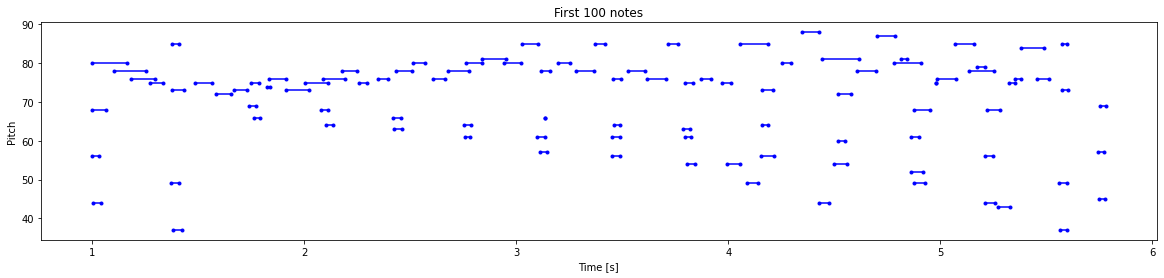

In [19]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.

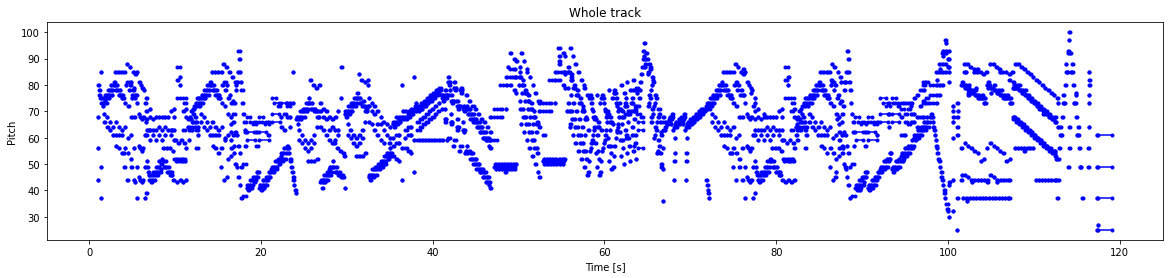

In [20]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [21]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

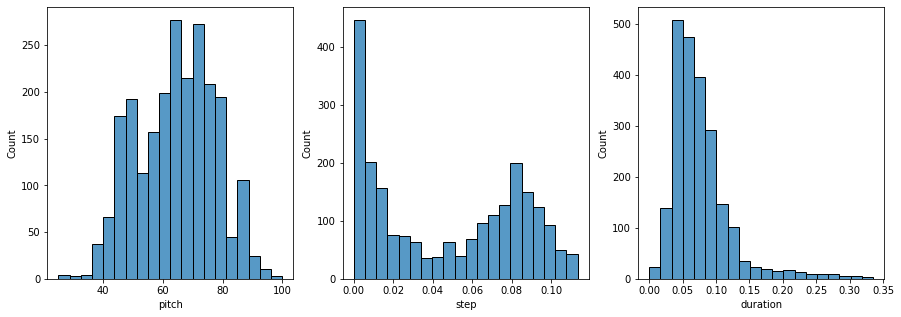

In [22]:
plot_distributions(raw_notes)

## Create a MIDI file

You can generate your own MIDI file from a list of notes using the function below.

In [23]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [24]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.

In [25]:
display_audio(example_pm)

As before, you can write ```files.download(example_file)``` to download and play this file.

## Create the training dataset


Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [26]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [27]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 23163


Next, create a [tf.data.Dataset](https://www.tensorflow.org/datasets) from the parsed notes.

In [28]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [29]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

You will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and next note as the label. In this way, the model will be trained to predict the next note in a sequence. You can find a diagram explaining this process (and more details) in [Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

You can use the handy [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) function with size `seq_length` to create the features and labels in this format.

In [30]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [31]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [32]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.578125   0.         0.1484375 ]
 [0.390625   0.00130208 0.0390625 ]
 [0.3828125  0.03255208 0.07421875]
 [0.390625   0.08203125 0.14713542]
 [0.5625     0.14973958 0.07421875]
 [0.546875   0.09375    0.07421875]
 [0.5390625  0.12239583 0.04947917]
 [0.296875   0.01692708 0.31119792]
 [0.5234375  0.09895833 0.04036458]
 [0.5078125  0.12369792 0.06380208]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=67.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.1171875>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.04947916666666652>}


Batch the examples, and configure the dataset for performance.

In [33]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [34]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `pitch` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [35]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [36]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               


 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                


 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   


 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   


 step (Dense)                   (None, 1)            129         ['lstm[0][0]']                   


Total params: 84,354


Trainable params: 84,354


Non-trainable params: 0


__________________________________________________________________________________________________


Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses. 
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [37]:
losses = model.evaluate(train_ds, return_dict=True)
losses

      1/Unknown - 4s 4s/step - loss: 4.8971 - duration_loss: 0.0298 - pitch_loss: 4.8444 - step_loss: 0.0228

     15/Unknown - 5s 4ms/step - loss: 5.0118 - duration_loss: 0.1196 - pitch_loss: 4.8454 - step_loss: 0.0467

     30/Unknown - 5s 4ms/step - loss: 4.9744 - duration_loss: 0.0887 - pitch_loss: 4.8461 - step_loss: 0.0396

     45/Unknown - 5s 4ms/step - loss: 4.9711 - duration_loss: 0.0904 - pitch_loss: 4.8472 - step_loss: 0.0335

     60/Unknown - 5s 4ms/step - loss: 4.9744 - duration_loss: 0.0937 - pitch_loss: 4.8473 - step_loss: 0.0334

     76/Unknown - 5s 3ms/step - loss: 4.9789 - duration_loss: 0.1024 - pitch_loss: 4.8472 - step_loss: 0.0293

     91/Unknown - 5s 3ms/step - loss: 4.9830 - duration_loss: 0.1066 - pitch_loss: 4.8473 - step_loss: 0.0291

    106/Unknown - 5s 3ms/step - loss: 4.9902 - duration_loss: 0.1127 - pitch_loss: 4.8472 - step_loss: 0.0303

    122/Unknown - 5s 3ms/step - loss: 4.9857 - duration_loss: 0.1099 - pitch_loss: 4.8472 - step_loss: 0.0286

    136/Unknown - 5s 3ms/step - loss: 4.9836 - duration_loss: 0.1076 - pitch_loss: 4.8475 - step_loss: 0.0285

    151/Unknown - 5s 3ms/step - loss: 4.9828 - duration_loss: 0.1081 - pitch_loss: 4.8476 - step_loss: 0.0271

    166/Unknown - 5s 3ms/step - loss: 4.9893 - duration_loss: 0.1089 - pitch_loss: 4.8476 - step_loss: 0.0328

    181/Unknown - 5s 3ms/step - loss: 4.9868 - duration_loss: 0.1066 - pitch_loss: 4.8476 - step_loss: 0.0325

    196/Unknown - 5s 3ms/step - loss: 5.0011 - duration_loss: 0.1216 - pitch_loss: 4.8477 - step_loss: 0.0318

    211/Unknown - 5s 3ms/step - loss: 4.9987 - duration_loss: 0.1187 - pitch_loss: 4.8477 - step_loss: 0.0323

    226/Unknown - 5s 3ms/step - loss: 4.9997 - duration_loss: 0.1202 - pitch_loss: 4.8478 - step_loss: 0.0317

    240/Unknown - 5s 3ms/step - loss: 5.0018 - duration_loss: 0.1209 - pitch_loss: 4.8477 - step_loss: 0.0333

    255/Unknown - 5s 3ms/step - loss: 5.0020 - duration_loss: 0.1193 - pitch_loss: 4.8477 - step_loss: 0.0350

    270/Unknown - 5s 3ms/step - loss: 5.0031 - duration_loss: 0.1210 - pitch_loss: 4.8478 - step_loss: 0.0344

    285/Unknown - 5s 3ms/step - loss: 4.9998 - duration_loss: 0.1187 - pitch_loss: 4.8477 - step_loss: 0.0333

    300/Unknown - 5s 3ms/step - loss: 5.0011 - duration_loss: 0.1188 - pitch_loss: 4.8477 - step_loss: 0.0346

    314/Unknown - 6s 3ms/step - loss: 5.0006 - duration_loss: 0.1187 - pitch_loss: 4.8477 - step_loss: 0.0341

    329/Unknown - 6s 3ms/step - loss: 5.0007 - duration_loss: 0.1197 - pitch_loss: 4.8476 - step_loss: 0.0334

    344/Unknown - 6s 3ms/step - loss: 4.9996 - duration_loss: 0.1192 - pitch_loss: 4.8476 - step_loss: 0.0328

    359/Unknown - 6s 3ms/step - loss: 5.0014 - duration_loss: 0.1216 - pitch_loss: 4.8476 - step_loss: 0.0322

361/361 [==============================] - 6s 4ms/step - loss: 5.0011 - duration_loss: 0.1213 - pitch_loss: 4.8476 - step_loss: 0.0322


{'loss': 5.001128196716309,
 'duration_loss': 0.12134315073490143,
 'pitch_loss': 4.847629547119141,
 'step_loss': 0.03215572610497475}

One way balance this is to use the `loss_weights` argument to compile:

In [38]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses.

In [39]:
model.evaluate(train_ds, return_dict=True)

      1/Unknown - 1s 798ms/step - loss: 0.2949 - duration_loss: 0.0298 - pitch_loss: 4.8444 - step_loss: 0.0228

     16/Unknown - 1s 3ms/step - loss: 0.4029 - duration_loss: 0.1165 - pitch_loss: 4.8452 - step_loss: 0.0441  

     31/Unknown - 1s 3ms/step - loss: 0.3718 - duration_loss: 0.0881 - pitch_loss: 4.8463 - step_loss: 0.0414

     46/Unknown - 1s 3ms/step - loss: 0.3715 - duration_loss: 0.0937 - pitch_loss: 4.8474 - step_loss: 0.0354

     61/Unknown - 1s 3ms/step - loss: 0.3680 - duration_loss: 0.0927 - pitch_loss: 4.8472 - step_loss: 0.0329

     76/Unknown - 1s 3ms/step - loss: 0.3740 - duration_loss: 0.1024 - pitch_loss: 4.8472 - step_loss: 0.0293

     91/Unknown - 1s 3ms/step - loss: 0.3780 - duration_loss: 0.1066 - pitch_loss: 4.8473 - step_loss: 0.0291

    106/Unknown - 1s 3ms/step - loss: 0.3854 - duration_loss: 0.1127 - pitch_loss: 4.8472 - step_loss: 0.0303

    121/Unknown - 1s 3ms/step - loss: 0.3814 - duration_loss: 0.1104 - pitch_loss: 4.8472 - step_loss: 0.0286

    136/Unknown - 1s 3ms/step - loss: 0.3785 - duration_loss: 0.1076 - pitch_loss: 4.8475 - step_loss: 0.0285

    151/Unknown - 1s 3ms/step - loss: 0.3776 - duration_loss: 0.1081 - pitch_loss: 4.8476 - step_loss: 0.0271

    166/Unknown - 1s 3ms/step - loss: 0.3841 - duration_loss: 0.1089 - pitch_loss: 4.8476 - step_loss: 0.0328

    181/Unknown - 1s 3ms/step - loss: 0.3815 - duration_loss: 0.1066 - pitch_loss: 4.8476 - step_loss: 0.0325

    195/Unknown - 1s 3ms/step - loss: 0.3883 - duration_loss: 0.1146 - pitch_loss: 4.8476 - step_loss: 0.0313

    210/Unknown - 2s 3ms/step - loss: 0.3936 - duration_loss: 0.1188 - pitch_loss: 4.8477 - step_loss: 0.0323

    224/Unknown - 2s 3ms/step - loss: 0.3954 - duration_loss: 0.1211 - pitch_loss: 4.8478 - step_loss: 0.0319

    238/Unknown - 2s 3ms/step - loss: 0.3965 - duration_loss: 0.1209 - pitch_loss: 4.8477 - step_loss: 0.0332

    253/Unknown - 2s 4ms/step - loss: 0.3974 - duration_loss: 0.1199 - pitch_loss: 4.8477 - step_loss: 0.0352

    268/Unknown - 2s 4ms/step - loss: 0.3981 - duration_loss: 0.1212 - pitch_loss: 4.8478 - step_loss: 0.0345

    283/Unknown - 2s 3ms/step - loss: 0.3949 - duration_loss: 0.1191 - pitch_loss: 4.8477 - step_loss: 0.0334

    298/Unknown - 2s 3ms/step - loss: 0.3962 - duration_loss: 0.1191 - pitch_loss: 4.8477 - step_loss: 0.0347

    313/Unknown - 2s 3ms/step - loss: 0.3953 - duration_loss: 0.1188 - pitch_loss: 4.8477 - step_loss: 0.0341

    328/Unknown - 2s 3ms/step - loss: 0.3956 - duration_loss: 0.1198 - pitch_loss: 4.8477 - step_loss: 0.0334

    343/Unknown - 2s 3ms/step - loss: 0.3946 - duration_loss: 0.1194 - pitch_loss: 4.8475 - step_loss: 0.0328

    358/Unknown - 2s 3ms/step - loss: 0.3963 - duration_loss: 0.1217 - pitch_loss: 4.8476 - step_loss: 0.0323

361/361 [==============================] - 2s 4ms/step - loss: 0.3959 - duration_loss: 0.1213 - pitch_loss: 4.8476 - step_loss: 0.0322


{'loss': 0.39588069915771484,
 'duration_loss': 0.12134315073490143,
 'pitch_loss': 4.847629547119141,
 'step_loss': 0.03215572610497475}

Train the model.

In [40]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [41]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50


      1/Unknown - 2s 2s/step - loss: 0.2949 - duration_loss: 0.0298 - pitch_loss: 4.8444 - step_loss: 0.0228

     10/Unknown - 2s 6ms/step - loss: 0.3880 - duration_loss: 0.1146 - pitch_loss: 4.8016 - step_loss: 0.0333

     20/Unknown - 2s 6ms/step - loss: 0.3664 - duration_loss: 0.0788 - pitch_loss: 4.7657 - step_loss: 0.0493

     30/Unknown - 2s 5ms/step - loss: 0.3447 - duration_loss: 0.0654 - pitch_loss: 4.7236 - step_loss: 0.0431

     40/Unknown - 2s 5ms/step - loss: 0.3292 - duration_loss: 0.0577 - pitch_loss: 4.6721 - step_loss: 0.0379

     50/Unknown - 2s 5ms/step - loss: 0.3298 - duration_loss: 0.0637 - pitch_loss: 4.6098 - step_loss: 0.0356

     60/Unknown - 2s 5ms/step - loss: 0.3288 - duration_loss: 0.0675 - pitch_loss: 4.5429 - step_loss: 0.0341

     70/Unknown - 2s 5ms/step - loss: 0.3295 - duration_loss: 0.0734 - pitch_loss: 4.5051 - step_loss: 0.0309

     80/Unknown - 2s 5ms/step - loss: 0.3242 - duration_loss: 0.0714 - pitch_loss: 4.4632 - step_loss: 0.0297

     90/Unknown - 2s 5ms/step - loss: 0.3217 - duration_loss: 0.0715 - pitch_loss: 4.4215 - step_loss: 0.0291

    100/Unknown - 2s 5ms/step - loss: 0.3268 - duration_loss: 0.0769 - pitch_loss: 4.3834 - step_loss: 0.0308

    110/Unknown - 2s 5ms/step - loss: 0.3214 - duration_loss: 0.0746 - pitch_loss: 4.3556 - step_loss: 0.0291

    120/Unknown - 2s 5ms/step - loss: 0.3173 - duration_loss: 0.0732 - pitch_loss: 4.3263 - step_loss: 0.0278

    130/Unknown - 2s 5ms/step - loss: 0.3149 - duration_loss: 0.0726 - pitch_loss: 4.3027 - step_loss: 0.0272

    140/Unknown - 2s 5ms/step - loss: 0.3121 - duration_loss: 0.0711 - pitch_loss: 4.2781 - step_loss: 0.0271

    150/Unknown - 2s 5ms/step - loss: 0.3106 - duration_loss: 0.0715 - pitch_loss: 4.2583 - step_loss: 0.0262

    160/Unknown - 3s 5ms/step - loss: 0.3108 - duration_loss: 0.0703 - pitch_loss: 4.2402 - step_loss: 0.0285

    170/Unknown - 3s 5ms/step - loss: 0.3127 - duration_loss: 0.0711 - pitch_loss: 4.2233 - step_loss: 0.0304

    180/Unknown - 3s 5ms/step - loss: 0.3114 - duration_loss: 0.0700 - pitch_loss: 4.2122 - step_loss: 0.0308

    190/Unknown - 3s 5ms/step - loss: 0.3122 - duration_loss: 0.0719 - pitch_loss: 4.2033 - step_loss: 0.0302

    200/Unknown - 3s 5ms/step - loss: 0.3177 - duration_loss: 0.0778 - pitch_loss: 4.1946 - step_loss: 0.0301

    210/Unknown - 3s 5ms/step - loss: 0.3165 - duration_loss: 0.0767 - pitch_loss: 4.1863 - step_loss: 0.0305

    220/Unknown - 3s 5ms/step - loss: 0.3151 - duration_loss: 0.0757 - pitch_loss: 4.1797 - step_loss: 0.0304

    230/Unknown - 3s 5ms/step - loss: 0.3136 - duration_loss: 0.0754 - pitch_loss: 4.1717 - step_loss: 0.0296

    240/Unknown - 3s 5ms/step - loss: 0.3141 - duration_loss: 0.0746 - pitch_loss: 4.1657 - step_loss: 0.0312

    250/Unknown - 3s 5ms/step - loss: 0.3133 - duration_loss: 0.0742 - pitch_loss: 4.1571 - step_loss: 0.0312

    260/Unknown - 3s 5ms/step - loss: 0.3128 - duration_loss: 0.0732 - pitch_loss: 4.1514 - step_loss: 0.0320

    269/Unknown - 3s 5ms/step - loss: 0.3126 - duration_loss: 0.0736 - pitch_loss: 4.1446 - step_loss: 0.0317

    278/Unknown - 3s 5ms/step - loss: 0.3109 - duration_loss: 0.0727 - pitch_loss: 4.1405 - step_loss: 0.0311

    287/Unknown - 3s 5ms/step - loss: 0.3100 - duration_loss: 0.0720 - pitch_loss: 4.1360 - step_loss: 0.0312

    296/Unknown - 3s 5ms/step - loss: 0.3102 - duration_loss: 0.0716 - pitch_loss: 4.1306 - step_loss: 0.0321

    306/Unknown - 3s 5ms/step - loss: 0.3090 - duration_loss: 0.0711 - pitch_loss: 4.1265 - step_loss: 0.0315

    316/Unknown - 3s 5ms/step - loss: 0.3086 - duration_loss: 0.0715 - pitch_loss: 4.1196 - step_loss: 0.0311

    326/Unknown - 3s 5ms/step - loss: 0.3081 - duration_loss: 0.0716 - pitch_loss: 4.1140 - step_loss: 0.0308

    336/Unknown - 3s 5ms/step - loss: 0.3063 - duration_loss: 0.0707 - pitch_loss: 4.1082 - step_loss: 0.0301

    346/Unknown - 4s 5ms/step - loss: 0.3058 - duration_loss: 0.0707 - pitch_loss: 4.1032 - step_loss: 0.0300

    356/Unknown - 4s 5ms/step - loss: 0.3082 - duration_loss: 0.0736 - pitch_loss: 4.0997 - step_loss: 0.0296

361/361 [==============================] - 4s 5ms/step - loss: 0.3075 - duration_loss: 0.0732 - pitch_loss: 4.0974 - step_loss: 0.0294


Epoch 2/50


  1/361 [..............................] - ETA: 2s - loss: 0.2747 - duration_loss: 0.0477 - pitch_loss: 4.1309 - step_loss: 0.0204

 11/361 [..............................] - ETA: 1s - loss: 0.3055 - duration_loss: 0.0910 - pitch_loss: 3.9975 - step_loss: 0.0147

 21/361 [>.............................] - ETA: 1s - loss: 0.3003 - duration_loss: 0.0664 - pitch_loss: 3.9761 - step_loss: 0.0351

 30/361 [=>............................] - ETA: 1s - loss: 0.2911 - duration_loss: 0.0581 - pitch_loss: 3.9727 - step_loss: 0.0344

 40/361 [==>...........................] - ETA: 1s - loss: 0.2810 - duration_loss: 0.0517 - pitch_loss: 3.9664 - step_loss: 0.0310

 50/361 [===>..........................] - ETA: 1s - loss: 0.2851 - duration_loss: 0.0567 - pitch_loss: 3.9724 - step_loss: 0.0298

 60/361 [===>..........................] - ETA: 1s - loss: 0.2863 - duration_loss: 0.0592 - pitch_loss: 3.9662 - step_loss: 0.0287

 70/361 [====>.........................] - ETA: 1s - loss: 0.2890 - duration_loss: 0.0646 - pitch_loss: 3.9651 - step_loss: 0.0262

 80/361 [=====>........................] - ETA: 1s - loss: 0.2869 - duration_loss: 0.0632 - pitch_loss: 3.9641 - step_loss: 0.0255

 90/361 [======>.......................] - ETA: 1s - loss: 0.2872 - duration_loss: 0.0637 - pitch_loss: 3.9649 - step_loss: 0.0253

100/361 [=======>......................] - ETA: 1s - loss: 0.2935 - duration_loss: 0.0684 - pitch_loss: 3.9573 - step_loss: 0.0273

110/361 [========>.....................] - ETA: 1s - loss: 0.2908 - duration_loss: 0.0671 - pitch_loss: 3.9577 - step_loss: 0.0259

119/361 [========>.....................] - ETA: 1s - loss: 0.2890 - duration_loss: 0.0662 - pitch_loss: 3.9567 - step_loss: 0.0249

129/361 [=========>....................] - ETA: 1s - loss: 0.2888 - duration_loss: 0.0664 - pitch_loss: 3.9590 - step_loss: 0.0245

139/361 [==========>...................] - ETA: 1s - loss: 0.2883 - duration_loss: 0.0661 - pitch_loss: 3.9567 - step_loss: 0.0244

149/361 [===========>..................] - ETA: 1s - loss: 0.2879 - duration_loss: 0.0664 - pitch_loss: 3.9571 - step_loss: 0.0237

159/361 [============>.................] - ETA: 1s - loss: 0.2894 - duration_loss: 0.0657 - pitch_loss: 3.9564 - step_loss: 0.0260

169/361 [=============>................] - ETA: 1s - loss: 0.2921 - duration_loss: 0.0665 - pitch_loss: 3.9540 - step_loss: 0.0279

179/361 [=============>................] - ETA: 0s - loss: 0.2911 - duration_loss: 0.0656 - pitch_loss: 3.9551 - step_loss: 0.0277

189/361 [==============>...............] - ETA: 0s - loss: 0.2896 - duration_loss: 0.0649 - pitch_loss: 3.9535 - step_loss: 0.0271

199/361 [===============>..............] - ETA: 0s - loss: 0.2982 - duration_loss: 0.0732 - pitch_loss: 3.9544 - step_loss: 0.0273

209/361 [================>.............] - ETA: 0s - loss: 0.2963 - duration_loss: 0.0719 - pitch_loss: 3.9546 - step_loss: 0.0266

219/361 [=================>............] - ETA: 0s - loss: 0.2966 - duration_loss: 0.0710 - pitch_loss: 3.9551 - step_loss: 0.0278

229/361 [==================>...........] - ETA: 0s - loss: 0.2957 - duration_loss: 0.0708 - pitch_loss: 3.9548 - step_loss: 0.0272

239/361 [==================>...........] - ETA: 0s - loss: 0.2969 - duration_loss: 0.0702 - pitch_loss: 3.9562 - step_loss: 0.0289

249/361 [===================>..........] - ETA: 0s - loss: 0.2968 - duration_loss: 0.0700 - pitch_loss: 3.9549 - step_loss: 0.0290

259/361 [====================>.........] - ETA: 0s - loss: 0.2968 - duration_loss: 0.0691 - pitch_loss: 3.9562 - step_loss: 0.0299

269/361 [=====================>........] - ETA: 0s - loss: 0.2970 - duration_loss: 0.0695 - pitch_loss: 3.9557 - step_loss: 0.0296

279/361 [======================>.......] - ETA: 0s - loss: 0.2957 - duration_loss: 0.0688 - pitch_loss: 3.9572 - step_loss: 0.0290

289/361 [=======================>......] - ETA: 0s - loss: 0.2964 - duration_loss: 0.0679 - pitch_loss: 3.9577 - step_loss: 0.0306

299/361 [=======================>......] - ETA: 0s - loss: 0.2949 - duration_loss: 0.0671 - pitch_loss: 3.9577 - step_loss: 0.0299

309/361 [========================>.....] - ETA: 0s - loss: 0.2944 - duration_loss: 0.0669 - pitch_loss: 3.9578 - step_loss: 0.0296

319/361 [=========================>....] - ETA: 0s - loss: 0.2947 - duration_loss: 0.0676 - pitch_loss: 3.9562 - step_loss: 0.0293

329/361 [==========================>...] - ETA: 0s - loss: 0.2941 - duration_loss: 0.0675 - pitch_loss: 3.9550 - step_loss: 0.0289

339/361 [===========================>..] - ETA: 0s - loss: 0.2938 - duration_loss: 0.0679 - pitch_loss: 3.9528 - step_loss: 0.0283

349/361 [============================>.] - ETA: 0s - loss: 0.2925 - duration_loss: 0.0667 - pitch_loss: 3.9527 - step_loss: 0.0281

359/361 [============================>.] - ETA: 0s - loss: 0.2953 - duration_loss: 0.0698 - pitch_loss: 3.9531 - step_loss: 0.0279

361/361 [==============================] - 2s 5ms/step - loss: 0.2950 - duration_loss: 0.0696 - pitch_loss: 3.9526 - step_loss: 0.0278


Epoch 3/50


  1/361 [..............................] - ETA: 2s - loss: 0.2687 - duration_loss: 0.0438 - pitch_loss: 4.1127 - step_loss: 0.0192

 11/361 [..............................] - ETA: 1s - loss: 0.3015 - duration_loss: 0.0877 - pitch_loss: 3.9804 - step_loss: 0.0148

 21/361 [>.............................] - ETA: 1s - loss: 0.2981 - duration_loss: 0.0652 - pitch_loss: 3.9602 - step_loss: 0.0349

 31/361 [=>............................] - ETA: 1s - loss: 0.2905 - duration_loss: 0.0576 - pitch_loss: 3.9561 - step_loss: 0.0350

 41/361 [==>...........................] - ETA: 1s - loss: 0.2779 - duration_loss: 0.0504 - pitch_loss: 3.9500 - step_loss: 0.0301

 51/361 [===>..........................] - ETA: 1s - loss: 0.2815 - duration_loss: 0.0546 - pitch_loss: 3.9532 - step_loss: 0.0292

 61/361 [====>.........................] - ETA: 1s - loss: 0.2832 - duration_loss: 0.0575 - pitch_loss: 3.9492 - step_loss: 0.0282

 71/361 [====>.........................] - ETA: 1s - loss: 0.2873 - duration_loss: 0.0640 - pitch_loss: 3.9490 - step_loss: 0.0259

 81/361 [=====>........................] - ETA: 1s - loss: 0.2847 - duration_loss: 0.0623 - pitch_loss: 3.9470 - step_loss: 0.0251

 91/361 [======>.......................] - ETA: 1s - loss: 0.2857 - duration_loss: 0.0635 - pitch_loss: 3.9471 - step_loss: 0.0248

101/361 [=======>......................] - ETA: 1s - loss: 0.2917 - duration_loss: 0.0678 - pitch_loss: 3.9395 - step_loss: 0.0269

111/361 [========>.....................] - ETA: 1s - loss: 0.2889 - duration_loss: 0.0665 - pitch_loss: 3.9392 - step_loss: 0.0255

121/361 [=========>....................] - ETA: 1s - loss: 0.2881 - duration_loss: 0.0665 - pitch_loss: 3.9389 - step_loss: 0.0246

131/361 [=========>....................] - ETA: 1s - loss: 0.2872 - duration_loss: 0.0660 - pitch_loss: 3.9401 - step_loss: 0.0242

141/361 [==========>...................] - ETA: 1s - loss: 0.2854 - duration_loss: 0.0646 - pitch_loss: 3.9396 - step_loss: 0.0238

151/361 [===========>..................] - ETA: 1s - loss: 0.2848 - duration_loss: 0.0647 - pitch_loss: 3.9383 - step_loss: 0.0232

161/361 [============>.................] - ETA: 1s - loss: 0.2865 - duration_loss: 0.0640 - pitch_loss: 3.9391 - step_loss: 0.0256

171/361 [=============>................] - ETA: 0s - loss: 0.2893 - duration_loss: 0.0649 - pitch_loss: 3.9366 - step_loss: 0.0276

180/361 [=============>................] - ETA: 0s - loss: 0.2884 - duration_loss: 0.0641 - pitch_loss: 3.9378 - step_loss: 0.0274

190/361 [==============>...............] - ETA: 0s - loss: 0.2898 - duration_loss: 0.0661 - pitch_loss: 3.9375 - step_loss: 0.0268

200/361 [===============>..............] - ETA: 0s - loss: 0.2956 - duration_loss: 0.0717 - pitch_loss: 3.9376 - step_loss: 0.0270

210/361 [================>.............] - ETA: 0s - loss: 0.2947 - duration_loss: 0.0703 - pitch_loss: 3.9380 - step_loss: 0.0275

220/361 [=================>............] - ETA: 0s - loss: 0.2939 - duration_loss: 0.0694 - pitch_loss: 3.9386 - step_loss: 0.0276

230/361 [==================>...........] - ETA: 0s - loss: 0.2932 - duration_loss: 0.0693 - pitch_loss: 3.9380 - step_loss: 0.0269

240/361 [==================>...........] - ETA: 0s - loss: 0.2938 - duration_loss: 0.0686 - pitch_loss: 3.9398 - step_loss: 0.0282

250/361 [===================>..........] - ETA: 0s - loss: 0.2936 - duration_loss: 0.0684 - pitch_loss: 3.9387 - step_loss: 0.0283

260/361 [====================>.........] - ETA: 0s - loss: 0.2939 - duration_loss: 0.0676 - pitch_loss: 3.9403 - step_loss: 0.0293

270/361 [=====================>........] - ETA: 0s - loss: 0.2947 - duration_loss: 0.0683 - pitch_loss: 3.9405 - step_loss: 0.0294

280/361 [======================>.......] - ETA: 0s - loss: 0.2932 - duration_loss: 0.0675 - pitch_loss: 3.9413 - step_loss: 0.0287

290/361 [=======================>......] - ETA: 0s - loss: 0.2939 - duration_loss: 0.0665 - pitch_loss: 3.9424 - step_loss: 0.0303

300/361 [=======================>......] - ETA: 0s - loss: 0.2926 - duration_loss: 0.0658 - pitch_loss: 3.9423 - step_loss: 0.0297

310/361 [========================>.....] - ETA: 0s - loss: 0.2930 - duration_loss: 0.0665 - pitch_loss: 3.9419 - step_loss: 0.0295

320/361 [=========================>....] - ETA: 0s - loss: 0.2925 - duration_loss: 0.0664 - pitch_loss: 3.9406 - step_loss: 0.0291

330/361 [==========================>...] - ETA: 0s - loss: 0.2920 - duration_loss: 0.0664 - pitch_loss: 3.9393 - step_loss: 0.0286

340/361 [===========================>..] - ETA: 0s - loss: 0.2915 - duration_loss: 0.0666 - pitch_loss: 3.9372 - step_loss: 0.0280

350/361 [============================>.] - ETA: 0s - loss: 0.2902 - duration_loss: 0.0655 - pitch_loss: 3.9372 - step_loss: 0.0279

360/361 [============================>.] - ETA: 0s - loss: 0.2928 - duration_loss: 0.0683 - pitch_loss: 3.9375 - step_loss: 0.0277

361/361 [==============================] - 2s 5ms/step - loss: 0.2927 - duration_loss: 0.0682 - pitch_loss: 3.9372 - step_loss: 0.0276


Epoch 4/50


  1/361 [..............................] - ETA: 2s - loss: 0.2611 - duration_loss: 0.0361 - pitch_loss: 4.1102 - step_loss: 0.0195

 10/361 [..............................] - ETA: 1s - loss: 0.3053 - duration_loss: 0.0919 - pitch_loss: 3.9600 - step_loss: 0.0154

 20/361 [>.............................] - ETA: 1s - loss: 0.2994 - duration_loss: 0.0666 - pitch_loss: 3.9413 - step_loss: 0.0357

 30/361 [=>............................] - ETA: 1s - loss: 0.2870 - duration_loss: 0.0567 - pitch_loss: 3.9374 - step_loss: 0.0335

 40/361 [==>...........................] - ETA: 1s - loss: 0.2772 - duration_loss: 0.0506 - pitch_loss: 3.9318 - step_loss: 0.0299

 50/361 [===>..........................] - ETA: 1s - loss: 0.2793 - duration_loss: 0.0538 - pitch_loss: 3.9331 - step_loss: 0.0289

 60/361 [===>..........................] - ETA: 1s - loss: 0.2809 - duration_loss: 0.0567 - pitch_loss: 3.9246 - step_loss: 0.0280

 70/361 [====>.........................] - ETA: 1s - loss: 0.2843 - duration_loss: 0.0628 - pitch_loss: 3.9191 - step_loss: 0.0256

 80/361 [=====>........................] - ETA: 1s - loss: 0.2817 - duration_loss: 0.0612 - pitch_loss: 3.9112 - step_loss: 0.0249

 90/361 [======>.......................] - ETA: 1s - loss: 0.2824 - duration_loss: 0.0622 - pitch_loss: 3.9092 - step_loss: 0.0247

100/361 [=======>......................] - ETA: 1s - loss: 0.2912 - duration_loss: 0.0693 - pitch_loss: 3.9036 - step_loss: 0.0267

109/361 [========>.....................] - ETA: 1s - loss: 0.2880 - duration_loss: 0.0673 - pitch_loss: 3.9061 - step_loss: 0.0254

118/361 [========>.....................] - ETA: 1s - loss: 0.2864 - duration_loss: 0.0666 - pitch_loss: 3.9065 - step_loss: 0.0245

128/361 [=========>....................] - ETA: 1s - loss: 0.2858 - duration_loss: 0.0663 - pitch_loss: 3.9099 - step_loss: 0.0240

138/361 [==========>...................] - ETA: 1s - loss: 0.2853 - duration_loss: 0.0659 - pitch_loss: 3.9091 - step_loss: 0.0239

148/361 [===========>..................] - ETA: 1s - loss: 0.2837 - duration_loss: 0.0650 - pitch_loss: 3.9099 - step_loss: 0.0232

158/361 [============>.................] - ETA: 1s - loss: 0.2858 - duration_loss: 0.0649 - pitch_loss: 3.9076 - step_loss: 0.0255

168/361 [============>.................] - ETA: 1s - loss: 0.2888 - duration_loss: 0.0660 - pitch_loss: 3.9052 - step_loss: 0.0275

178/361 [=============>................] - ETA: 0s - loss: 0.2880 - duration_loss: 0.0649 - pitch_loss: 3.9075 - step_loss: 0.0277

188/361 [==============>...............] - ETA: 0s - loss: 0.2878 - duration_loss: 0.0648 - pitch_loss: 3.9082 - step_loss: 0.0275

198/361 [===============>..............] - ETA: 0s - loss: 0.2965 - duration_loss: 0.0732 - pitch_loss: 3.9114 - step_loss: 0.0277

208/361 [================>.............] - ETA: 0s - loss: 0.2946 - duration_loss: 0.0720 - pitch_loss: 3.9126 - step_loss: 0.0270

218/361 [=================>............] - ETA: 0s - loss: 0.2946 - duration_loss: 0.0706 - pitch_loss: 3.9147 - step_loss: 0.0282

228/361 [=================>............] - ETA: 0s - loss: 0.2939 - duration_loss: 0.0705 - pitch_loss: 3.9157 - step_loss: 0.0276

238/361 [==================>...........] - ETA: 0s - loss: 0.2947 - duration_loss: 0.0697 - pitch_loss: 3.9178 - step_loss: 0.0290

248/361 [===================>..........] - ETA: 0s - loss: 0.2947 - duration_loss: 0.0696 - pitch_loss: 3.9173 - step_loss: 0.0292

258/361 [====================>.........] - ETA: 0s - loss: 0.2942 - duration_loss: 0.0681 - pitch_loss: 3.9203 - step_loss: 0.0300

268/361 [=====================>........] - ETA: 0s - loss: 0.2947 - duration_loss: 0.0690 - pitch_loss: 3.9209 - step_loss: 0.0297

278/361 [======================>.......] - ETA: 0s - loss: 0.2932 - duration_loss: 0.0681 - pitch_loss: 3.9229 - step_loss: 0.0290

288/361 [======================>.......] - ETA: 0s - loss: 0.2939 - duration_loss: 0.0673 - pitch_loss: 3.9242 - step_loss: 0.0304

298/361 [=======================>......] - ETA: 0s - loss: 0.2924 - duration_loss: 0.0662 - pitch_loss: 3.9245 - step_loss: 0.0299

308/361 [========================>.....] - ETA: 0s - loss: 0.2918 - duration_loss: 0.0659 - pitch_loss: 3.9257 - step_loss: 0.0296

318/361 [=========================>....] - ETA: 0s - loss: 0.2921 - duration_loss: 0.0667 - pitch_loss: 3.9245 - step_loss: 0.0291

328/361 [==========================>...] - ETA: 0s - loss: 0.2915 - duration_loss: 0.0665 - pitch_loss: 3.9240 - step_loss: 0.0287

338/361 [===========================>..] - ETA: 0s - loss: 0.2907 - duration_loss: 0.0665 - pitch_loss: 3.9221 - step_loss: 0.0281

348/361 [===========================>..] - ETA: 0s - loss: 0.2899 - duration_loss: 0.0658 - pitch_loss: 3.9225 - step_loss: 0.0280

358/361 [============================>.] - ETA: 0s - loss: 0.2921 - duration_loss: 0.0683 - pitch_loss: 3.9235 - step_loss: 0.0276

361/361 [==============================] - 2s 5ms/step - loss: 0.2918 - duration_loss: 0.0681 - pitch_loss: 3.9232 - step_loss: 0.0275


Epoch 5/50


  1/361 [..............................] - ETA: 2s - loss: 0.2646 - duration_loss: 0.0398 - pitch_loss: 4.1055 - step_loss: 0.0195

 11/361 [..............................] - ETA: 1s - loss: 0.3007 - duration_loss: 0.0867 - pitch_loss: 3.9637 - step_loss: 0.0158

 21/361 [>.............................] - ETA: 1s - loss: 0.2957 - duration_loss: 0.0643 - pitch_loss: 3.9391 - step_loss: 0.0344

 31/361 [=>............................] - ETA: 1s - loss: 0.2877 - duration_loss: 0.0573 - pitch_loss: 3.9364 - step_loss: 0.0335

 41/361 [==>...........................] - ETA: 1s - loss: 0.2754 - duration_loss: 0.0498 - pitch_loss: 3.9327 - step_loss: 0.0289

 51/361 [===>..........................] - ETA: 1s - loss: 0.2775 - duration_loss: 0.0524 - pitch_loss: 3.9363 - step_loss: 0.0283

 61/361 [====>.........................] - ETA: 1s - loss: 0.2797 - duration_loss: 0.0556 - pitch_loss: 3.9333 - step_loss: 0.0275

 71/361 [====>.........................] - ETA: 1s - loss: 0.2849 - duration_loss: 0.0630 - pitch_loss: 3.9342 - step_loss: 0.0252

 81/361 [=====>........................] - ETA: 1s - loss: 0.2823 - duration_loss: 0.0612 - pitch_loss: 3.9328 - step_loss: 0.0245

 91/361 [======>.......................] - ETA: 1s - loss: 0.2842 - duration_loss: 0.0631 - pitch_loss: 3.9335 - step_loss: 0.0244

101/361 [=======>......................] - ETA: 1s - loss: 0.2902 - duration_loss: 0.0672 - pitch_loss: 3.9274 - step_loss: 0.0265

111/361 [========>.....................] - ETA: 1s - loss: 0.2873 - duration_loss: 0.0657 - pitch_loss: 3.9274 - step_loss: 0.0252

121/361 [=========>....................] - ETA: 1s - loss: 0.2861 - duration_loss: 0.0654 - pitch_loss: 3.9271 - step_loss: 0.0243

131/361 [=========>....................] - ETA: 1s - loss: 0.2850 - duration_loss: 0.0648 - pitch_loss: 3.9287 - step_loss: 0.0238

141/361 [==========>...................] - ETA: 1s - loss: 0.2834 - duration_loss: 0.0637 - pitch_loss: 3.9276 - step_loss: 0.0233

151/361 [===========>..................] - ETA: 1s - loss: 0.2824 - duration_loss: 0.0634 - pitch_loss: 3.9262 - step_loss: 0.0227

161/361 [============>.................] - ETA: 1s - loss: 0.2839 - duration_loss: 0.0629 - pitch_loss: 3.9269 - step_loss: 0.0247

171/361 [=============>................] - ETA: 0s - loss: 0.2866 - duration_loss: 0.0636 - pitch_loss: 3.9240 - step_loss: 0.0267

181/361 [==============>...............] - ETA: 0s - loss: 0.2854 - duration_loss: 0.0627 - pitch_loss: 3.9244 - step_loss: 0.0265

191/361 [==============>...............] - ETA: 0s - loss: 0.2875 - duration_loss: 0.0652 - pitch_loss: 3.9241 - step_loss: 0.0260

201/361 [===============>..............] - ETA: 0s - loss: 0.2916 - duration_loss: 0.0693 - pitch_loss: 3.9234 - step_loss: 0.0260

211/361 [================>.............] - ETA: 0s - loss: 0.2910 - duration_loss: 0.0682 - pitch_loss: 3.9241 - step_loss: 0.0266

221/361 [=================>............] - ETA: 0s - loss: 0.2903 - duration_loss: 0.0674 - pitch_loss: 3.9241 - step_loss: 0.0267

232/361 [==================>...........] - ETA: 0s - loss: 0.2894 - duration_loss: 0.0672 - pitch_loss: 3.9235 - step_loss: 0.0260

242/361 [===================>..........] - ETA: 0s - loss: 0.2912 - duration_loss: 0.0673 - pitch_loss: 3.9238 - step_loss: 0.0277

252/361 [===================>..........] - ETA: 0s - loss: 0.2906 - duration_loss: 0.0669 - pitch_loss: 3.9241 - step_loss: 0.0276

262/361 [====================>.........] - ETA: 0s - loss: 0.2913 - duration_loss: 0.0665 - pitch_loss: 3.9246 - step_loss: 0.0285

272/361 [=====================>........] - ETA: 0s - loss: 0.2907 - duration_loss: 0.0664 - pitch_loss: 3.9250 - step_loss: 0.0281

282/361 [======================>.......] - ETA: 0s - loss: 0.2896 - duration_loss: 0.0658 - pitch_loss: 3.9259 - step_loss: 0.0275

292/361 [=======================>......] - ETA: 0s - loss: 0.2900 - duration_loss: 0.0648 - pitch_loss: 3.9247 - step_loss: 0.0290

302/361 [========================>.....] - ETA: 0s - loss: 0.2888 - duration_loss: 0.0643 - pitch_loss: 3.9225 - step_loss: 0.0284

312/361 [========================>.....] - ETA: 0s - loss: 0.2887 - duration_loss: 0.0645 - pitch_loss: 3.9201 - step_loss: 0.0282

322/361 [=========================>....] - ETA: 0s - loss: 0.2885 - duration_loss: 0.0649 - pitch_loss: 3.9180 - step_loss: 0.0277

332/361 [==========================>...] - ETA: 0s - loss: 0.2873 - duration_loss: 0.0643 - pitch_loss: 3.9150 - step_loss: 0.0273

341/361 [===========================>..] - ETA: 0s - loss: 0.2870 - duration_loss: 0.0645 - pitch_loss: 3.9119 - step_loss: 0.0269

351/361 [============================>.] - ETA: 0s - loss: 0.2857 - duration_loss: 0.0636 - pitch_loss: 3.9088 - step_loss: 0.0267

361/361 [==============================] - ETA: 0s - loss: 0.2874 - duration_loss: 0.0657 - pitch_loss: 3.9079 - step_loss: 0.0264

361/361 [==============================] - 2s 5ms/step - loss: 0.2874 - duration_loss: 0.0657 - pitch_loss: 3.9079 - step_loss: 0.0264


Epoch 6/50


  1/361 [..............................] - ETA: 2s - loss: 0.2630 - duration_loss: 0.0430 - pitch_loss: 4.0319 - step_loss: 0.0184

 11/361 [..............................] - ETA: 1s - loss: 0.3046 - duration_loss: 0.0949 - pitch_loss: 3.9141 - step_loss: 0.0140

 21/361 [>.............................] - ETA: 1s - loss: 0.2970 - duration_loss: 0.0686 - pitch_loss: 3.8985 - step_loss: 0.0335

 31/361 [=>............................] - ETA: 1s - loss: 0.2873 - duration_loss: 0.0597 - pitch_loss: 3.8982 - step_loss: 0.0327

 41/361 [==>...........................] - ETA: 1s - loss: 0.2744 - duration_loss: 0.0516 - pitch_loss: 3.8946 - step_loss: 0.0281

 51/361 [===>..........................] - ETA: 1s - loss: 0.2759 - duration_loss: 0.0537 - pitch_loss: 3.8954 - step_loss: 0.0274

 61/361 [====>.........................] - ETA: 1s - loss: 0.2779 - duration_loss: 0.0568 - pitch_loss: 3.8891 - step_loss: 0.0266

 71/361 [====>.........................] - ETA: 1s - loss: 0.2827 - duration_loss: 0.0641 - pitch_loss: 3.8837 - step_loss: 0.0245

 81/361 [=====>........................] - ETA: 1s - loss: 0.2800 - duration_loss: 0.0624 - pitch_loss: 3.8765 - step_loss: 0.0238

 91/361 [======>.......................] - ETA: 1s - loss: 0.2813 - duration_loss: 0.0640 - pitch_loss: 3.8753 - step_loss: 0.0235

101/361 [=======>......................] - ETA: 1s - loss: 0.2867 - duration_loss: 0.0677 - pitch_loss: 3.8694 - step_loss: 0.0255

111/361 [========>.....................] - ETA: 1s - loss: 0.2838 - duration_loss: 0.0661 - pitch_loss: 3.8685 - step_loss: 0.0243

121/361 [=========>....................] - ETA: 1s - loss: 0.2825 - duration_loss: 0.0656 - pitch_loss: 3.8675 - step_loss: 0.0235

131/361 [=========>....................] - ETA: 1s - loss: 0.2814 - duration_loss: 0.0649 - pitch_loss: 3.8701 - step_loss: 0.0230

141/361 [==========>...................] - ETA: 1s - loss: 0.2801 - duration_loss: 0.0638 - pitch_loss: 3.8696 - step_loss: 0.0228

151/361 [===========>..................] - ETA: 1s - loss: 0.2789 - duration_loss: 0.0635 - pitch_loss: 3.8679 - step_loss: 0.0220

161/361 [============>.................] - ETA: 1s - loss: 0.2803 - duration_loss: 0.0630 - pitch_loss: 3.8671 - step_loss: 0.0240

171/361 [=============>................] - ETA: 0s - loss: 0.2832 - duration_loss: 0.0639 - pitch_loss: 3.8655 - step_loss: 0.0260

181/361 [==============>...............] - ETA: 0s - loss: 0.2822 - duration_loss: 0.0629 - pitch_loss: 3.8666 - step_loss: 0.0259

191/361 [==============>...............] - ETA: 0s - loss: 0.2844 - duration_loss: 0.0655 - pitch_loss: 3.8676 - step_loss: 0.0256

201/361 [===============>..............] - ETA: 0s - loss: 0.2887 - duration_loss: 0.0694 - pitch_loss: 3.8681 - step_loss: 0.0259

211/361 [================>.............] - ETA: 0s - loss: 0.2880 - duration_loss: 0.0681 - pitch_loss: 3.8700 - step_loss: 0.0264

221/361 [=================>............] - ETA: 0s - loss: 0.2874 - duration_loss: 0.0673 - pitch_loss: 3.8707 - step_loss: 0.0266

231/361 [==================>...........] - ETA: 0s - loss: 0.2867 - duration_loss: 0.0672 - pitch_loss: 3.8703 - step_loss: 0.0260

241/361 [===================>..........] - ETA: 0s - loss: 0.2878 - duration_loss: 0.0667 - pitch_loss: 3.8710 - step_loss: 0.0275

251/361 [===================>..........] - ETA: 0s - loss: 0.2874 - duration_loss: 0.0664 - pitch_loss: 3.8690 - step_loss: 0.0275

260/361 [====================>.........] - ETA: 0s - loss: 0.2876 - duration_loss: 0.0659 - pitch_loss: 3.8689 - step_loss: 0.0283

270/361 [=====================>........] - ETA: 0s - loss: 0.2878 - duration_loss: 0.0664 - pitch_loss: 3.8675 - step_loss: 0.0280

280/361 [======================>.......] - ETA: 0s - loss: 0.2863 - duration_loss: 0.0655 - pitch_loss: 3.8673 - step_loss: 0.0274

290/361 [=======================>......] - ETA: 0s - loss: 0.2869 - duration_loss: 0.0645 - pitch_loss: 3.8666 - step_loss: 0.0290

299/361 [=======================>......] - ETA: 0s - loss: 0.2852 - duration_loss: 0.0636 - pitch_loss: 3.8647 - step_loss: 0.0284

308/361 [========================>.....] - ETA: 0s - loss: 0.2848 - duration_loss: 0.0635 - pitch_loss: 3.8634 - step_loss: 0.0281

317/361 [=========================>....] - ETA: 0s - loss: 0.2853 - duration_loss: 0.0645 - pitch_loss: 3.8599 - step_loss: 0.0278

326/361 [==========================>...] - ETA: 0s - loss: 0.2845 - duration_loss: 0.0641 - pitch_loss: 3.8580 - step_loss: 0.0275

336/361 [==========================>...] - ETA: 0s - loss: 0.2831 - duration_loss: 0.0634 - pitch_loss: 3.8554 - step_loss: 0.0269

346/361 [===========================>..] - ETA: 0s - loss: 0.2827 - duration_loss: 0.0633 - pitch_loss: 3.8520 - step_loss: 0.0268

356/361 [============================>.] - ETA: 0s - loss: 0.2846 - duration_loss: 0.0656 - pitch_loss: 3.8511 - step_loss: 0.0265

361/361 [==============================] - 2s 5ms/step - loss: 0.2842 - duration_loss: 0.0653 - pitch_loss: 3.8509 - step_loss: 0.0263


Epoch 7/50


  1/361 [..............................] - ETA: 2s - loss: 0.2587 - duration_loss: 0.0377 - pitch_loss: 4.0420 - step_loss: 0.0189

 10/361 [..............................] - ETA: 1s - loss: 0.3071 - duration_loss: 0.0981 - pitch_loss: 3.8725 - step_loss: 0.0154

 20/361 [>.............................] - ETA: 1s - loss: 0.2982 - duration_loss: 0.0699 - pitch_loss: 3.8581 - step_loss: 0.0354

 30/361 [=>............................] - ETA: 1s - loss: 0.2839 - duration_loss: 0.0583 - pitch_loss: 3.8479 - step_loss: 0.0331

 40/361 [==>...........................] - ETA: 1s - loss: 0.2731 - duration_loss: 0.0516 - pitch_loss: 3.8425 - step_loss: 0.0293

 50/361 [===>..........................] - ETA: 1s - loss: 0.2720 - duration_loss: 0.0521 - pitch_loss: 3.8355 - step_loss: 0.0282

 60/361 [===>..........................] - ETA: 1s - loss: 0.2741 - duration_loss: 0.0554 - pitch_loss: 3.8269 - step_loss: 0.0274

 70/361 [====>.........................] - ETA: 1s - loss: 0.2780 - duration_loss: 0.0620 - pitch_loss: 3.8211 - step_loss: 0.0250

 80/361 [=====>........................] - ETA: 1s - loss: 0.2755 - duration_loss: 0.0604 - pitch_loss: 3.8142 - step_loss: 0.0243

 90/361 [======>.......................] - ETA: 1s - loss: 0.2753 - duration_loss: 0.0605 - pitch_loss: 3.8165 - step_loss: 0.0240

100/361 [=======>......................] - ETA: 1s - loss: 0.2798 - duration_loss: 0.0632 - pitch_loss: 3.8108 - step_loss: 0.0260

110/361 [========>.....................] - ETA: 1s - loss: 0.2779 - duration_loss: 0.0623 - pitch_loss: 3.8159 - step_loss: 0.0248

119/361 [========>.....................] - ETA: 1s - loss: 0.2757 - duration_loss: 0.0609 - pitch_loss: 3.8172 - step_loss: 0.0239

129/361 [=========>....................] - ETA: 1s - loss: 0.2757 - duration_loss: 0.0611 - pitch_loss: 3.8233 - step_loss: 0.0235

139/361 [==========>...................] - ETA: 1s - loss: 0.2752 - duration_loss: 0.0609 - pitch_loss: 3.8223 - step_loss: 0.0232

149/361 [===========>..................] - ETA: 1s - loss: 0.2736 - duration_loss: 0.0601 - pitch_loss: 3.8232 - step_loss: 0.0223

159/361 [============>.................] - ETA: 1s - loss: 0.2755 - duration_loss: 0.0598 - pitch_loss: 3.8225 - step_loss: 0.0246

169/361 [=============>................] - ETA: 1s - loss: 0.2798 - duration_loss: 0.0619 - pitch_loss: 3.8184 - step_loss: 0.0269

179/361 [=============>................] - ETA: 0s - loss: 0.2791 - duration_loss: 0.0615 - pitch_loss: 3.8177 - step_loss: 0.0268

189/361 [==============>...............] - ETA: 0s - loss: 0.2777 - duration_loss: 0.0608 - pitch_loss: 3.8153 - step_loss: 0.0261

199/361 [===============>..............] - ETA: 0s - loss: 0.2859 - duration_loss: 0.0685 - pitch_loss: 3.8170 - step_loss: 0.0266

209/361 [================>.............] - ETA: 0s - loss: 0.2839 - duration_loss: 0.0672 - pitch_loss: 3.8179 - step_loss: 0.0259

219/361 [=================>............] - ETA: 0s - loss: 0.2844 - duration_loss: 0.0664 - pitch_loss: 3.8187 - step_loss: 0.0271

229/361 [==================>...........] - ETA: 0s - loss: 0.2840 - duration_loss: 0.0665 - pitch_loss: 3.8182 - step_loss: 0.0265

239/361 [==================>...........] - ETA: 0s - loss: 0.2849 - duration_loss: 0.0659 - pitch_loss: 3.8194 - step_loss: 0.0280

249/361 [===================>..........] - ETA: 0s - loss: 0.2846 - duration_loss: 0.0657 - pitch_loss: 3.8182 - step_loss: 0.0280

259/361 [====================>.........] - ETA: 0s - loss: 0.2847 - duration_loss: 0.0651 - pitch_loss: 3.8186 - step_loss: 0.0286

269/361 [=====================>........] - ETA: 0s - loss: 0.2849 - duration_loss: 0.0656 - pitch_loss: 3.8183 - step_loss: 0.0283

279/361 [======================>.......] - ETA: 0s - loss: 0.2835 - duration_loss: 0.0649 - pitch_loss: 3.8198 - step_loss: 0.0277

289/361 [=======================>......] - ETA: 0s - loss: 0.2843 - duration_loss: 0.0641 - pitch_loss: 3.8198 - step_loss: 0.0292

299/361 [=======================>......] - ETA: 0s - loss: 0.2827 - duration_loss: 0.0633 - pitch_loss: 3.8184 - step_loss: 0.0285

309/361 [========================>.....] - ETA: 0s - loss: 0.2823 - duration_loss: 0.0631 - pitch_loss: 3.8174 - step_loss: 0.0283

319/361 [=========================>....] - ETA: 0s - loss: 0.2826 - duration_loss: 0.0640 - pitch_loss: 3.8147 - step_loss: 0.0279

329/361 [==========================>...] - ETA: 0s - loss: 0.2819 - duration_loss: 0.0637 - pitch_loss: 3.8138 - step_loss: 0.0275

339/361 [===========================>..] - ETA: 0s - loss: 0.2814 - duration_loss: 0.0638 - pitch_loss: 3.8114 - step_loss: 0.0270

349/361 [============================>.] - ETA: 0s - loss: 0.2801 - duration_loss: 0.0627 - pitch_loss: 3.8093 - step_loss: 0.0269

359/361 [============================>.] - ETA: 0s - loss: 0.2822 - duration_loss: 0.0652 - pitch_loss: 3.8093 - step_loss: 0.0266

361/361 [==============================] - 2s 5ms/step - loss: 0.2820 - duration_loss: 0.0650 - pitch_loss: 3.8090 - step_loss: 0.0265


Epoch 8/50


  1/361 [..............................] - ETA: 2s - loss: 0.2525 - duration_loss: 0.0358 - pitch_loss: 3.9658 - step_loss: 0.0184

 11/361 [..............................] - ETA: 1s - loss: 0.2950 - duration_loss: 0.0895 - pitch_loss: 3.8234 - step_loss: 0.0143

 21/361 [>.............................] - ETA: 1s - loss: 0.2921 - duration_loss: 0.0678 - pitch_loss: 3.8197 - step_loss: 0.0333

 31/361 [=>............................] - ETA: 1s - loss: 0.2821 - duration_loss: 0.0597 - pitch_loss: 3.8176 - step_loss: 0.0315

 41/361 [==>...........................] - ETA: 1s - loss: 0.2694 - duration_loss: 0.0516 - pitch_loss: 3.8109 - step_loss: 0.0272

 51/361 [===>..........................] - ETA: 1s - loss: 0.2693 - duration_loss: 0.0523 - pitch_loss: 3.8058 - step_loss: 0.0267

 61/361 [====>.........................] - ETA: 1s - loss: 0.2718 - duration_loss: 0.0556 - pitch_loss: 3.8012 - step_loss: 0.0261

 71/361 [====>.........................] - ETA: 1s - loss: 0.2765 - duration_loss: 0.0626 - pitch_loss: 3.7984 - step_loss: 0.0240

 81/361 [=====>........................] - ETA: 1s - loss: 0.2738 - duration_loss: 0.0607 - pitch_loss: 3.7919 - step_loss: 0.0234

 91/361 [======>.......................] - ETA: 1s - loss: 0.2749 - duration_loss: 0.0618 - pitch_loss: 3.7962 - step_loss: 0.0232

101/361 [=======>......................] - ETA: 1s - loss: 0.2791 - duration_loss: 0.0642 - pitch_loss: 3.7931 - step_loss: 0.0252

111/361 [========>.....................] - ETA: 1s - loss: 0.2769 - duration_loss: 0.0628 - pitch_loss: 3.7945 - step_loss: 0.0243

121/361 [=========>....................] - ETA: 1s - loss: 0.2761 - duration_loss: 0.0629 - pitch_loss: 3.7936 - step_loss: 0.0235

131/361 [=========>....................] - ETA: 1s - loss: 0.2753 - duration_loss: 0.0624 - pitch_loss: 3.7984 - step_loss: 0.0230

141/361 [==========>...................] - ETA: 1s - loss: 0.2739 - duration_loss: 0.0614 - pitch_loss: 3.7979 - step_loss: 0.0226

151/361 [===========>..................] - ETA: 1s - loss: 0.2729 - duration_loss: 0.0612 - pitch_loss: 3.7969 - step_loss: 0.0219

161/361 [============>.................] - ETA: 1s - loss: 0.2748 - duration_loss: 0.0608 - pitch_loss: 3.7963 - step_loss: 0.0242

171/361 [=============>................] - ETA: 0s - loss: 0.2783 - duration_loss: 0.0622 - pitch_loss: 3.7933 - step_loss: 0.0265

181/361 [==============>...............] - ETA: 0s - loss: 0.2772 - duration_loss: 0.0613 - pitch_loss: 3.7924 - step_loss: 0.0262

191/361 [==============>...............] - ETA: 0s - loss: 0.2792 - duration_loss: 0.0636 - pitch_loss: 3.7921 - step_loss: 0.0260

201/361 [===============>..............] - ETA: 0s - loss: 0.2833 - duration_loss: 0.0677 - pitch_loss: 3.7912 - step_loss: 0.0261

211/361 [================>.............] - ETA: 0s - loss: 0.2830 - duration_loss: 0.0669 - pitch_loss: 3.7930 - step_loss: 0.0265

221/361 [=================>............] - ETA: 0s - loss: 0.2832 - duration_loss: 0.0670 - pitch_loss: 3.7934 - step_loss: 0.0265

231/361 [==================>...........] - ETA: 0s - loss: 0.2825 - duration_loss: 0.0669 - pitch_loss: 3.7934 - step_loss: 0.0260

241/361 [===================>..........] - ETA: 0s - loss: 0.2833 - duration_loss: 0.0663 - pitch_loss: 3.7944 - step_loss: 0.0273

251/361 [===================>..........] - ETA: 0s - loss: 0.2831 - duration_loss: 0.0660 - pitch_loss: 3.7947 - step_loss: 0.0273

261/361 [====================>.........] - ETA: 0s - loss: 0.2836 - duration_loss: 0.0660 - pitch_loss: 3.7948 - step_loss: 0.0278

271/361 [=====================>........] - ETA: 0s - loss: 0.2833 - duration_loss: 0.0661 - pitch_loss: 3.7966 - step_loss: 0.0274

281/361 [======================>.......] - ETA: 0s - loss: 0.2821 - duration_loss: 0.0654 - pitch_loss: 3.7987 - step_loss: 0.0268

291/361 [=======================>......] - ETA: 0s - loss: 0.2825 - duration_loss: 0.0644 - pitch_loss: 3.7980 - step_loss: 0.0282

301/361 [========================>.....] - ETA: 0s - loss: 0.2809 - duration_loss: 0.0635 - pitch_loss: 3.7967 - step_loss: 0.0275

311/361 [========================>.....] - ETA: 0s - loss: 0.2812 - duration_loss: 0.0641 - pitch_loss: 3.7955 - step_loss: 0.0274

321/361 [=========================>....] - ETA: 0s - loss: 0.2809 - duration_loss: 0.0642 - pitch_loss: 3.7935 - step_loss: 0.0270

331/361 [==========================>...] - ETA: 0s - loss: 0.2801 - duration_loss: 0.0638 - pitch_loss: 3.7935 - step_loss: 0.0266

341/361 [===========================>..] - ETA: 0s - loss: 0.2799 - duration_loss: 0.0640 - pitch_loss: 3.7925 - step_loss: 0.0262

351/361 [============================>.] - ETA: 0s - loss: 0.2787 - duration_loss: 0.0631 - pitch_loss: 3.7908 - step_loss: 0.0261

361/361 [==============================] - ETA: 0s - loss: 0.2806 - duration_loss: 0.0654 - pitch_loss: 3.7903 - step_loss: 0.0257

361/361 [==============================] - 2s 5ms/step - loss: 0.2806 - duration_loss: 0.0654 - pitch_loss: 3.7903 - step_loss: 0.0257


Epoch 9/50


  1/361 [..............................] - ETA: 2s - loss: 0.2497 - duration_loss: 0.0386 - pitch_loss: 3.8825 - step_loss: 0.0170

 11/361 [..............................] - ETA: 1s - loss: 0.2912 - duration_loss: 0.0859 - pitch_loss: 3.7945 - step_loss: 0.0156

 21/361 [>.............................] - ETA: 1s - loss: 0.2887 - duration_loss: 0.0651 - pitch_loss: 3.7963 - step_loss: 0.0338

 31/361 [=>............................] - ETA: 1s - loss: 0.2796 - duration_loss: 0.0591 - pitch_loss: 3.7967 - step_loss: 0.0307

 41/361 [==>...........................] - ETA: 1s - loss: 0.2671 - duration_loss: 0.0510 - pitch_loss: 3.7920 - step_loss: 0.0265

 50/361 [===>..........................] - ETA: 1s - loss: 0.2673 - duration_loss: 0.0513 - pitch_loss: 3.7915 - step_loss: 0.0264

 59/361 [===>..........................] - ETA: 1s - loss: 0.2707 - duration_loss: 0.0553 - pitch_loss: 3.7844 - step_loss: 0.0262

 68/361 [====>.........................] - ETA: 1s - loss: 0.2756 - duration_loss: 0.0623 - pitch_loss: 3.7849 - step_loss: 0.0241

 78/361 [=====>........................] - ETA: 1s - loss: 0.2723 - duration_loss: 0.0604 - pitch_loss: 3.7753 - step_loss: 0.0231

 88/361 [======>.......................] - ETA: 1s - loss: 0.2723 - duration_loss: 0.0602 - pitch_loss: 3.7806 - step_loss: 0.0231

 97/361 [=======>......................] - ETA: 1s - loss: 0.2739 - duration_loss: 0.0592 - pitch_loss: 3.7808 - step_loss: 0.0256

106/361 [=======>......................] - ETA: 1s - loss: 0.2741 - duration_loss: 0.0606 - pitch_loss: 3.7830 - step_loss: 0.0244

116/361 [========>.....................] - ETA: 1s - loss: 0.2718 - duration_loss: 0.0592 - pitch_loss: 3.7833 - step_loss: 0.0234

125/361 [=========>....................] - ETA: 1s - loss: 0.2731 - duration_loss: 0.0609 - pitch_loss: 3.7826 - step_loss: 0.0230

135/361 [==========>...................] - ETA: 1s - loss: 0.2727 - duration_loss: 0.0607 - pitch_loss: 3.7861 - step_loss: 0.0228

145/361 [===========>..................] - ETA: 1s - loss: 0.2703 - duration_loss: 0.0588 - pitch_loss: 3.7875 - step_loss: 0.0221

154/361 [===========>..................] - ETA: 1s - loss: 0.2697 - duration_loss: 0.0584 - pitch_loss: 3.7866 - step_loss: 0.0220

163/361 [============>.................] - ETA: 1s - loss: 0.2760 - duration_loss: 0.0602 - pitch_loss: 3.7883 - step_loss: 0.0264

173/361 [=============>................] - ETA: 1s - loss: 0.2768 - duration_loss: 0.0611 - pitch_loss: 3.7858 - step_loss: 0.0264

182/361 [==============>...............] - ETA: 0s - loss: 0.2753 - duration_loss: 0.0598 - pitch_loss: 3.7876 - step_loss: 0.0261

192/361 [==============>...............] - ETA: 0s - loss: 0.2774 - duration_loss: 0.0622 - pitch_loss: 3.7886 - step_loss: 0.0257

202/361 [===============>..............] - ETA: 0s - loss: 0.2818 - duration_loss: 0.0665 - pitch_loss: 3.7887 - step_loss: 0.0258

212/361 [================>.............] - ETA: 0s - loss: 0.2811 - duration_loss: 0.0653 - pitch_loss: 3.7897 - step_loss: 0.0263

222/361 [=================>............] - ETA: 0s - loss: 0.2813 - duration_loss: 0.0655 - pitch_loss: 3.7903 - step_loss: 0.0263

232/361 [==================>...........] - ETA: 0s - loss: 0.2803 - duration_loss: 0.0651 - pitch_loss: 3.7897 - step_loss: 0.0257

241/361 [===================>..........] - ETA: 0s - loss: 0.2815 - duration_loss: 0.0648 - pitch_loss: 3.7904 - step_loss: 0.0272

251/361 [===================>..........] - ETA: 0s - loss: 0.2813 - duration_loss: 0.0646 - pitch_loss: 3.7906 - step_loss: 0.0272

261/361 [====================>.........] - ETA: 0s - loss: 0.2814 - duration_loss: 0.0642 - pitch_loss: 3.7908 - step_loss: 0.0276

270/361 [=====================>........] - ETA: 0s - loss: 0.2818 - duration_loss: 0.0648 - pitch_loss: 3.7920 - step_loss: 0.0274

280/361 [======================>.......] - ETA: 0s - loss: 0.2805 - duration_loss: 0.0640 - pitch_loss: 3.7940 - step_loss: 0.0268

289/361 [=======================>......] - ETA: 0s - loss: 0.2811 - duration_loss: 0.0632 - pitch_loss: 3.7940 - step_loss: 0.0282

299/361 [=======================>......] - ETA: 0s - loss: 0.2793 - duration_loss: 0.0621 - pitch_loss: 3.7931 - step_loss: 0.0276

308/361 [========================>.....] - ETA: 0s - loss: 0.2791 - duration_loss: 0.0621 - pitch_loss: 3.7927 - step_loss: 0.0274

317/361 [=========================>....] - ETA: 0s - loss: 0.2798 - duration_loss: 0.0632 - pitch_loss: 3.7904 - step_loss: 0.0271

327/361 [==========================>...] - ETA: 0s - loss: 0.2799 - duration_loss: 0.0637 - pitch_loss: 3.7898 - step_loss: 0.0267

337/361 [===========================>..] - ETA: 0s - loss: 0.2795 - duration_loss: 0.0639 - pitch_loss: 3.7886 - step_loss: 0.0262

347/361 [===========================>..] - ETA: 0s - loss: 0.2789 - duration_loss: 0.0630 - pitch_loss: 3.7882 - step_loss: 0.0266

357/361 [============================>.] - ETA: 0s - loss: 0.2810 - duration_loss: 0.0653 - pitch_loss: 3.7888 - step_loss: 0.0262

361/361 [==============================] - 2s 6ms/step - loss: 0.2806 - duration_loss: 0.0651 - pitch_loss: 3.7888 - step_loss: 0.0261


Epoch 10/50


  1/361 [..............................] - ETA: 2s - loss: 0.2515 - duration_loss: 0.0407 - pitch_loss: 3.8735 - step_loss: 0.0171

 11/361 [..............................] - ETA: 1s - loss: 0.3014 - duration_loss: 0.0968 - pitch_loss: 3.8123 - step_loss: 0.0140

 21/361 [>.............................] - ETA: 1s - loss: 0.2943 - duration_loss: 0.0710 - pitch_loss: 3.8083 - step_loss: 0.0329

 31/361 [=>............................] - ETA: 1s - loss: 0.2843 - duration_loss: 0.0617 - pitch_loss: 3.8097 - step_loss: 0.0321

 41/361 [==>...........................] - ETA: 1s - loss: 0.2709 - duration_loss: 0.0532 - pitch_loss: 3.8026 - step_loss: 0.0276

 51/361 [===>..........................] - ETA: 1s - loss: 0.2721 - duration_loss: 0.0551 - pitch_loss: 3.7960 - step_loss: 0.0272

 61/361 [====>.........................] - ETA: 1s - loss: 0.2740 - duration_loss: 0.0579 - pitch_loss: 3.7907 - step_loss: 0.0265

 71/361 [====>.........................] - ETA: 1s - loss: 0.2786 - duration_loss: 0.0650 - pitch_loss: 3.7869 - step_loss: 0.0243

 81/361 [=====>........................] - ETA: 1s - loss: 0.2752 - duration_loss: 0.0626 - pitch_loss: 3.7792 - step_loss: 0.0236

 91/361 [======>.......................] - ETA: 1s - loss: 0.2753 - duration_loss: 0.0629 - pitch_loss: 3.7815 - step_loss: 0.0233

101/361 [=======>......................] - ETA: 1s - loss: 0.2811 - duration_loss: 0.0669 - pitch_loss: 3.7754 - step_loss: 0.0254

111/361 [========>.....................] - ETA: 1s - loss: 0.2782 - duration_loss: 0.0652 - pitch_loss: 3.7761 - step_loss: 0.0242

121/361 [=========>....................] - ETA: 1s - loss: 0.2769 - duration_loss: 0.0648 - pitch_loss: 3.7735 - step_loss: 0.0234

131/361 [=========>....................] - ETA: 1s - loss: 0.2760 - duration_loss: 0.0642 - pitch_loss: 3.7767 - step_loss: 0.0229

141/361 [==========>...................] - ETA: 1s - loss: 0.2742 - duration_loss: 0.0629 - pitch_loss: 3.7762 - step_loss: 0.0224

151/361 [===========>..................] - ETA: 1s - loss: 0.2720 - duration_loss: 0.0616 - pitch_loss: 3.7762 - step_loss: 0.0216

160/361 [============>.................] - ETA: 1s - loss: 0.2734 - duration_loss: 0.0612 - pitch_loss: 3.7754 - step_loss: 0.0234

170/361 [=============>................] - ETA: 1s - loss: 0.2765 - duration_loss: 0.0622 - pitch_loss: 3.7728 - step_loss: 0.0257

180/361 [=============>................] - ETA: 0s - loss: 0.2757 - duration_loss: 0.0615 - pitch_loss: 3.7710 - step_loss: 0.0256

190/361 [==============>...............] - ETA: 0s - loss: 0.2765 - duration_loss: 0.0629 - pitch_loss: 3.7695 - step_loss: 0.0251

200/361 [===============>..............] - ETA: 0s - loss: 0.2816 - duration_loss: 0.0673 - pitch_loss: 3.7688 - step_loss: 0.0259

210/361 [================>.............] - ETA: 0s - loss: 0.2806 - duration_loss: 0.0659 - pitch_loss: 3.7683 - step_loss: 0.0263

220/361 [=================>............] - ETA: 0s - loss: 0.2809 - duration_loss: 0.0661 - pitch_loss: 3.7688 - step_loss: 0.0264

230/361 [==================>...........] - ETA: 0s - loss: 0.2803 - duration_loss: 0.0660 - pitch_loss: 3.7687 - step_loss: 0.0258

240/361 [==================>...........] - ETA: 0s - loss: 0.2809 - duration_loss: 0.0653 - pitch_loss: 3.7696 - step_loss: 0.0272

250/361 [===================>..........] - ETA: 0s - loss: 0.2807 - duration_loss: 0.0650 - pitch_loss: 3.7704 - step_loss: 0.0272

260/361 [====================>.........] - ETA: 0s - loss: 0.2807 - duration_loss: 0.0644 - pitch_loss: 3.7716 - step_loss: 0.0277

270/361 [=====================>........] - ETA: 0s - loss: 0.2810 - duration_loss: 0.0649 - pitch_loss: 3.7727 - step_loss: 0.0274

280/361 [======================>.......] - ETA: 0s - loss: 0.2796 - duration_loss: 0.0641 - pitch_loss: 3.7753 - step_loss: 0.0268

290/361 [=======================>......] - ETA: 0s - loss: 0.2801 - duration_loss: 0.0632 - pitch_loss: 3.7764 - step_loss: 0.0281

300/361 [=======================>......] - ETA: 0s - loss: 0.2782 - duration_loss: 0.0620 - pitch_loss: 3.7755 - step_loss: 0.0274

310/361 [========================>.....] - ETA: 0s - loss: 0.2788 - duration_loss: 0.0628 - pitch_loss: 3.7748 - step_loss: 0.0272

320/361 [=========================>....] - ETA: 0s - loss: 0.2785 - duration_loss: 0.0630 - pitch_loss: 3.7730 - step_loss: 0.0268

330/361 [==========================>...] - ETA: 0s - loss: 0.2777 - duration_loss: 0.0626 - pitch_loss: 3.7727 - step_loss: 0.0264

340/361 [===========================>..] - ETA: 0s - loss: 0.2770 - duration_loss: 0.0625 - pitch_loss: 3.7709 - step_loss: 0.0260

350/361 [============================>.] - ETA: 0s - loss: 0.2757 - duration_loss: 0.0614 - pitch_loss: 3.7696 - step_loss: 0.0259

360/361 [============================>.] - ETA: 0s - loss: 0.2779 - duration_loss: 0.0638 - pitch_loss: 3.7695 - step_loss: 0.0257

361/361 [==============================] - 2s 5ms/step - loss: 0.2778 - duration_loss: 0.0637 - pitch_loss: 3.7690 - step_loss: 0.0256


Epoch 11/50


  1/361 [..............................] - ETA: 2s - loss: 0.2398 - duration_loss: 0.0298 - pitch_loss: 3.8453 - step_loss: 0.0177

 11/361 [..............................] - ETA: 1s - loss: 0.2878 - duration_loss: 0.0835 - pitch_loss: 3.7925 - step_loss: 0.0147

 21/361 [>.............................] - ETA: 1s - loss: 0.2855 - duration_loss: 0.0624 - pitch_loss: 3.8021 - step_loss: 0.0329

 31/361 [=>............................] - ETA: 1s - loss: 0.2768 - duration_loss: 0.0557 - pitch_loss: 3.8080 - step_loss: 0.0308

 41/361 [==>...........................] - ETA: 1s - loss: 0.2649 - duration_loss: 0.0482 - pitch_loss: 3.8031 - step_loss: 0.0265

 51/361 [===>..........................] - ETA: 1s - loss: 0.2635 - duration_loss: 0.0478 - pitch_loss: 3.7958 - step_loss: 0.0260

 61/361 [====>.........................] - ETA: 1s - loss: 0.2664 - duration_loss: 0.0515 - pitch_loss: 3.7896 - step_loss: 0.0254

 71/361 [====>.........................] - ETA: 1s - loss: 0.2713 - duration_loss: 0.0587 - pitch_loss: 3.7830 - step_loss: 0.0234

 81/361 [=====>........................] - ETA: 1s - loss: 0.2684 - duration_loss: 0.0567 - pitch_loss: 3.7748 - step_loss: 0.0229

 91/361 [======>.......................] - ETA: 1s - loss: 0.2691 - duration_loss: 0.0577 - pitch_loss: 3.7760 - step_loss: 0.0226

101/361 [=======>......................] - ETA: 1s - loss: 0.2744 - duration_loss: 0.0614 - pitch_loss: 3.7695 - step_loss: 0.0245

111/361 [========>.....................] - ETA: 1s - loss: 0.2721 - duration_loss: 0.0602 - pitch_loss: 3.7705 - step_loss: 0.0234

121/361 [=========>....................] - ETA: 1s - loss: 0.2712 - duration_loss: 0.0602 - pitch_loss: 3.7683 - step_loss: 0.0226

131/361 [=========>....................] - ETA: 1s - loss: 0.2705 - duration_loss: 0.0597 - pitch_loss: 3.7720 - step_loss: 0.0222

141/361 [==========>...................] - ETA: 1s - loss: 0.2690 - duration_loss: 0.0589 - pitch_loss: 3.7716 - step_loss: 0.0215

151/361 [===========>..................] - ETA: 1s - loss: 0.2671 - duration_loss: 0.0577 - pitch_loss: 3.7715 - step_loss: 0.0208

161/361 [============>.................] - ETA: 1s - loss: 0.2684 - duration_loss: 0.0575 - pitch_loss: 3.7710 - step_loss: 0.0223

171/361 [=============>................] - ETA: 0s - loss: 0.2736 - duration_loss: 0.0601 - pitch_loss: 3.7677 - step_loss: 0.0251

181/361 [==============>...............] - ETA: 0s - loss: 0.2725 - duration_loss: 0.0592 - pitch_loss: 3.7666 - step_loss: 0.0250

191/361 [==============>...............] - ETA: 0s - loss: 0.2749 - duration_loss: 0.0616 - pitch_loss: 3.7669 - step_loss: 0.0250

201/361 [===============>..............] - ETA: 0s - loss: 0.2795 - duration_loss: 0.0656 - pitch_loss: 3.7665 - step_loss: 0.0256

211/361 [================>.............] - ETA: 0s - loss: 0.2792 - duration_loss: 0.0646 - pitch_loss: 3.7684 - step_loss: 0.0262

221/361 [=================>............] - ETA: 0s - loss: 0.2787 - duration_loss: 0.0641 - pitch_loss: 3.7696 - step_loss: 0.0261

231/361 [==================>...........] - ETA: 0s - loss: 0.2781 - duration_loss: 0.0641 - pitch_loss: 3.7704 - step_loss: 0.0254

241/361 [===================>..........] - ETA: 0s - loss: 0.2789 - duration_loss: 0.0638 - pitch_loss: 3.7713 - step_loss: 0.0266

251/361 [===================>..........] - ETA: 0s - loss: 0.2788 - duration_loss: 0.0636 - pitch_loss: 3.7730 - step_loss: 0.0265

261/361 [====================>.........] - ETA: 0s - loss: 0.2788 - duration_loss: 0.0632 - pitch_loss: 3.7738 - step_loss: 0.0269

271/361 [=====================>........] - ETA: 0s - loss: 0.2787 - duration_loss: 0.0633 - pitch_loss: 3.7757 - step_loss: 0.0266

281/361 [======================>.......] - ETA: 0s - loss: 0.2778 - duration_loss: 0.0627 - pitch_loss: 3.7779 - step_loss: 0.0262

291/361 [=======================>......] - ETA: 0s - loss: 0.2781 - duration_loss: 0.0618 - pitch_loss: 3.7773 - step_loss: 0.0274

301/361 [========================>.....] - ETA: 0s - loss: 0.2766 - duration_loss: 0.0609 - pitch_loss: 3.7768 - step_loss: 0.0268

311/361 [========================>.....] - ETA: 0s - loss: 0.2770 - duration_loss: 0.0615 - pitch_loss: 3.7760 - step_loss: 0.0267

321/361 [=========================>....] - ETA: 0s - loss: 0.2766 - duration_loss: 0.0616 - pitch_loss: 3.7739 - step_loss: 0.0263

330/361 [==========================>...] - ETA: 0s - loss: 0.2761 - duration_loss: 0.0614 - pitch_loss: 3.7738 - step_loss: 0.0260

340/361 [===========================>..] - ETA: 0s - loss: 0.2755 - duration_loss: 0.0611 - pitch_loss: 3.7719 - step_loss: 0.0258

350/361 [============================>.] - ETA: 0s - loss: 0.2742 - duration_loss: 0.0600 - pitch_loss: 3.7706 - step_loss: 0.0257

359/361 [============================>.] - ETA: 0s - loss: 0.2765 - duration_loss: 0.0625 - pitch_loss: 3.7709 - step_loss: 0.0254

361/361 [==============================] - 2s 5ms/step - loss: 0.2762 - duration_loss: 0.0624 - pitch_loss: 3.7704 - step_loss: 0.0253


Epoch 12/50


  1/361 [..............................] - ETA: 2s - loss: 0.2460 - duration_loss: 0.0362 - pitch_loss: 3.8540 - step_loss: 0.0171

 11/361 [..............................] - ETA: 1s - loss: 0.3120 - duration_loss: 0.1018 - pitch_loss: 3.8021 - step_loss: 0.0201

 21/361 [>.............................] - ETA: 1s - loss: 0.2985 - duration_loss: 0.0719 - pitch_loss: 3.8117 - step_loss: 0.0360

 31/361 [=>............................] - ETA: 1s - loss: 0.2857 - duration_loss: 0.0628 - pitch_loss: 3.8143 - step_loss: 0.0321

 41/361 [==>...........................] - ETA: 1s - loss: 0.2719 - duration_loss: 0.0538 - pitch_loss: 3.8087 - step_loss: 0.0276

 50/361 [===>..........................] - ETA: 1s - loss: 0.2715 - duration_loss: 0.0539 - pitch_loss: 3.8056 - step_loss: 0.0274

 60/361 [===>..........................] - ETA: 1s - loss: 0.2729 - duration_loss: 0.0566 - pitch_loss: 3.7974 - step_loss: 0.0264

 70/361 [====>.........................] - ETA: 1s - loss: 0.2759 - duration_loss: 0.0622 - pitch_loss: 3.7913 - step_loss: 0.0241

 79/361 [=====>........................] - ETA: 1s - loss: 0.2736 - duration_loss: 0.0606 - pitch_loss: 3.7842 - step_loss: 0.0238

 88/361 [======>.......................] - ETA: 1s - loss: 0.2722 - duration_loss: 0.0593 - pitch_loss: 3.7829 - step_loss: 0.0237

 97/361 [=======>......................] - ETA: 1s - loss: 0.2729 - duration_loss: 0.0583 - pitch_loss: 3.7794 - step_loss: 0.0256

106/361 [=======>......................] - ETA: 1s - loss: 0.2749 - duration_loss: 0.0617 - pitch_loss: 3.7776 - step_loss: 0.0244

116/361 [========>.....................] - ETA: 1s - loss: 0.2721 - duration_loss: 0.0600 - pitch_loss: 3.7757 - step_loss: 0.0234

126/361 [=========>....................] - ETA: 1s - loss: 0.2718 - duration_loss: 0.0604 - pitch_loss: 3.7740 - step_loss: 0.0227

136/361 [==========>...................] - ETA: 1s - loss: 0.2711 - duration_loss: 0.0602 - pitch_loss: 3.7755 - step_loss: 0.0221

146/361 [===========>..................] - ETA: 1s - loss: 0.2687 - duration_loss: 0.0582 - pitch_loss: 3.7752 - step_loss: 0.0218

156/361 [===========>..................] - ETA: 1s - loss: 0.2682 - duration_loss: 0.0581 - pitch_loss: 3.7725 - step_loss: 0.0215

166/361 [============>.................] - ETA: 1s - loss: 0.2736 - duration_loss: 0.0595 - pitch_loss: 3.7732 - step_loss: 0.0255

176/361 [=============>................] - ETA: 1s - loss: 0.2737 - duration_loss: 0.0598 - pitch_loss: 3.7707 - step_loss: 0.0253

186/361 [==============>...............] - ETA: 0s - loss: 0.2720 - duration_loss: 0.0587 - pitch_loss: 3.7668 - step_loss: 0.0250

195/361 [===============>..............] - ETA: 0s - loss: 0.2740 - duration_loss: 0.0606 - pitch_loss: 3.7693 - step_loss: 0.0249

205/361 [================>.............] - ETA: 0s - loss: 0.2785 - duration_loss: 0.0647 - pitch_loss: 3.7678 - step_loss: 0.0253

215/361 [================>.............] - ETA: 0s - loss: 0.2776 - duration_loss: 0.0631 - pitch_loss: 3.7686 - step_loss: 0.0260

225/361 [=================>............] - ETA: 0s - loss: 0.2773 - duration_loss: 0.0631 - pitch_loss: 3.7704 - step_loss: 0.0256

235/361 [==================>...........] - ETA: 0s - loss: 0.2766 - duration_loss: 0.0624 - pitch_loss: 3.7695 - step_loss: 0.0257

245/361 [===================>..........] - ETA: 0s - loss: 0.2780 - duration_loss: 0.0631 - pitch_loss: 3.7694 - step_loss: 0.0264

255/361 [====================>.........] - ETA: 0s - loss: 0.2776 - duration_loss: 0.0620 - pitch_loss: 3.7695 - step_loss: 0.0271

265/361 [=====================>........] - ETA: 0s - loss: 0.2773 - duration_loss: 0.0622 - pitch_loss: 3.7694 - step_loss: 0.0267

275/361 [=====================>........] - ETA: 0s - loss: 0.2769 - duration_loss: 0.0621 - pitch_loss: 3.7711 - step_loss: 0.0262

284/361 [======================>.......] - ETA: 0s - loss: 0.2757 - duration_loss: 0.0613 - pitch_loss: 3.7721 - step_loss: 0.0259

294/361 [=======================>......] - ETA: 0s - loss: 0.2761 - duration_loss: 0.0606 - pitch_loss: 3.7719 - step_loss: 0.0269

304/361 [========================>.....] - ETA: 0s - loss: 0.2750 - duration_loss: 0.0601 - pitch_loss: 3.7717 - step_loss: 0.0264

314/361 [=========================>....] - ETA: 0s - loss: 0.2752 - duration_loss: 0.0605 - pitch_loss: 3.7702 - step_loss: 0.0262

324/361 [=========================>....] - ETA: 0s - loss: 0.2748 - duration_loss: 0.0605 - pitch_loss: 3.7690 - step_loss: 0.0258

334/361 [==========================>...] - ETA: 0s - loss: 0.2741 - duration_loss: 0.0603 - pitch_loss: 3.7678 - step_loss: 0.0254

343/361 [===========================>..] - ETA: 0s - loss: 0.2737 - duration_loss: 0.0600 - pitch_loss: 3.7662 - step_loss: 0.0254

353/361 [============================>.] - ETA: 0s - loss: 0.2754 - duration_loss: 0.0620 - pitch_loss: 3.7652 - step_loss: 0.0251

361/361 [==============================] - 2s 6ms/step - loss: 0.2746 - duration_loss: 0.0616 - pitch_loss: 3.7644 - step_loss: 0.0248


Epoch 13/50


  1/361 [..............................] - ETA: 2s - loss: 0.2395 - duration_loss: 0.0285 - pitch_loss: 3.8702 - step_loss: 0.0175

 11/361 [..............................] - ETA: 1s - loss: 0.2839 - duration_loss: 0.0795 - pitch_loss: 3.7917 - step_loss: 0.0148

 21/361 [>.............................] - ETA: 1s - loss: 0.2833 - duration_loss: 0.0607 - pitch_loss: 3.8031 - step_loss: 0.0324

 31/361 [=>............................] - ETA: 1s - loss: 0.2742 - duration_loss: 0.0542 - pitch_loss: 3.8055 - step_loss: 0.0297

 41/361 [==>...........................] - ETA: 1s - loss: 0.2627 - duration_loss: 0.0471 - pitch_loss: 3.8005 - step_loss: 0.0256

 51/361 [===>..........................] - ETA: 1s - loss: 0.2621 - duration_loss: 0.0471 - pitch_loss: 3.7946 - step_loss: 0.0253

 61/361 [====>.........................] - ETA: 1s - loss: 0.2654 - duration_loss: 0.0514 - pitch_loss: 3.7874 - step_loss: 0.0246

 70/361 [====>.........................] - ETA: 1s - loss: 0.2699 - duration_loss: 0.0579 - pitch_loss: 3.7813 - step_loss: 0.0229

 79/361 [=====>........................] - ETA: 1s - loss: 0.2681 - duration_loss: 0.0569 - pitch_loss: 3.7749 - step_loss: 0.0225

 89/361 [======>.......................] - ETA: 1s - loss: 0.2680 - duration_loss: 0.0572 - pitch_loss: 3.7734 - step_loss: 0.0222

 98/361 [=======>......................] - ETA: 1s - loss: 0.2681 - duration_loss: 0.0554 - pitch_loss: 3.7706 - step_loss: 0.0241

107/361 [=======>......................] - ETA: 1s - loss: 0.2702 - duration_loss: 0.0587 - pitch_loss: 3.7685 - step_loss: 0.0231

116/361 [========>.....................] - ETA: 1s - loss: 0.2676 - duration_loss: 0.0570 - pitch_loss: 3.7689 - step_loss: 0.0222

125/361 [=========>....................] - ETA: 1s - loss: 0.2675 - duration_loss: 0.0573 - pitch_loss: 3.7675 - step_loss: 0.0218

134/361 [==========>...................] - ETA: 1s - loss: 0.2674 - duration_loss: 0.0573 - pitch_loss: 3.7698 - step_loss: 0.0216

143/361 [==========>...................] - ETA: 1s - loss: 0.2658 - duration_loss: 0.0564 - pitch_loss: 3.7704 - step_loss: 0.0209

153/361 [===========>..................] - ETA: 1s - loss: 0.2648 - duration_loss: 0.0558 - pitch_loss: 3.7681 - step_loss: 0.0206

163/361 [============>.................] - ETA: 1s - loss: 0.2701 - duration_loss: 0.0573 - pitch_loss: 3.7690 - step_loss: 0.0244

173/361 [=============>................] - ETA: 1s - loss: 0.2700 - duration_loss: 0.0576 - pitch_loss: 3.7649 - step_loss: 0.0242

183/361 [==============>...............] - ETA: 0s - loss: 0.2686 - duration_loss: 0.0564 - pitch_loss: 3.7628 - step_loss: 0.0240

192/361 [==============>...............] - ETA: 0s - loss: 0.2705 - duration_loss: 0.0585 - pitch_loss: 3.7631 - step_loss: 0.0239

201/361 [===============>..............] - ETA: 0s - loss: 0.2746 - duration_loss: 0.0621 - pitch_loss: 3.7615 - step_loss: 0.0244

211/361 [================>.............] - ETA: 0s - loss: 0.2740 - duration_loss: 0.0610 - pitch_loss: 3.7631 - step_loss: 0.0248

220/361 [=================>............] - ETA: 0s - loss: 0.2746 - duration_loss: 0.0612 - pitch_loss: 3.7633 - step_loss: 0.0252

229/361 [==================>...........] - ETA: 0s - loss: 0.2746 - duration_loss: 0.0616 - pitch_loss: 3.7629 - step_loss: 0.0248

238/361 [==================>...........] - ETA: 0s - loss: 0.2754 - duration_loss: 0.0615 - pitch_loss: 3.7630 - step_loss: 0.0258

247/361 [===================>..........] - ETA: 0s - loss: 0.2759 - duration_loss: 0.0617 - pitch_loss: 3.7631 - step_loss: 0.0261

257/361 [====================>.........] - ETA: 0s - loss: 0.2755 - duration_loss: 0.0607 - pitch_loss: 3.7651 - step_loss: 0.0265

267/361 [=====================>........] - ETA: 0s - loss: 0.2759 - duration_loss: 0.0614 - pitch_loss: 3.7659 - step_loss: 0.0261

277/361 [======================>.......] - ETA: 0s - loss: 0.2750 - duration_loss: 0.0610 - pitch_loss: 3.7672 - step_loss: 0.0257

287/361 [======================>.......] - ETA: 0s - loss: 0.2747 - duration_loss: 0.0604 - pitch_loss: 3.7678 - step_loss: 0.0259

297/361 [=======================>......] - ETA: 0s - loss: 0.2739 - duration_loss: 0.0592 - pitch_loss: 3.7669 - step_loss: 0.0264

307/361 [========================>.....] - ETA: 0s - loss: 0.2736 - duration_loss: 0.0591 - pitch_loss: 3.7663 - step_loss: 0.0261

316/361 [=========================>....] - ETA: 0s - loss: 0.2740 - duration_loss: 0.0600 - pitch_loss: 3.7642 - step_loss: 0.0258

326/361 [==========================>...] - ETA: 0s - loss: 0.2734 - duration_loss: 0.0597 - pitch_loss: 3.7632 - step_loss: 0.0255

335/361 [==========================>...] - ETA: 0s - loss: 0.2725 - duration_loss: 0.0593 - pitch_loss: 3.7621 - step_loss: 0.0250

344/361 [===========================>..] - ETA: 0s - loss: 0.2719 - duration_loss: 0.0588 - pitch_loss: 3.7603 - step_loss: 0.0250

353/361 [============================>.] - ETA: 0s - loss: 0.2735 - duration_loss: 0.0608 - pitch_loss: 3.7597 - step_loss: 0.0248

361/361 [==============================] - 2s 6ms/step - loss: 0.2728 - duration_loss: 0.0604 - pitch_loss: 3.7591 - step_loss: 0.0244


Epoch 14/50


  1/361 [..............................] - ETA: 2s - loss: 0.2451 - duration_loss: 0.0262 - pitch_loss: 3.8472 - step_loss: 0.0265

 11/361 [..............................] - ETA: 1s - loss: 0.2886 - duration_loss: 0.0831 - pitch_loss: 3.8043 - step_loss: 0.0152

 20/361 [>.............................] - ETA: 1s - loss: 0.2894 - duration_loss: 0.0653 - pitch_loss: 3.8107 - step_loss: 0.0335

 30/361 [=>............................] - ETA: 1s - loss: 0.2760 - duration_loss: 0.0556 - pitch_loss: 3.8067 - step_loss: 0.0300

 40/361 [==>...........................] - ETA: 1s - loss: 0.2652 - duration_loss: 0.0491 - pitch_loss: 3.8003 - step_loss: 0.0260

 50/361 [===>..........................] - ETA: 1s - loss: 0.2627 - duration_loss: 0.0479 - pitch_loss: 3.7929 - step_loss: 0.0252

 60/361 [===>..........................] - ETA: 1s - loss: 0.2655 - duration_loss: 0.0515 - pitch_loss: 3.7846 - step_loss: 0.0249

 70/361 [====>.........................] - ETA: 1s - loss: 0.2684 - duration_loss: 0.0567 - pitch_loss: 3.7790 - step_loss: 0.0228

 80/361 [=====>........................] - ETA: 1s - loss: 0.2654 - duration_loss: 0.0549 - pitch_loss: 3.7690 - step_loss: 0.0221

 90/361 [======>.......................] - ETA: 1s - loss: 0.2637 - duration_loss: 0.0539 - pitch_loss: 3.7720 - step_loss: 0.0213

100/361 [=======>......................] - ETA: 1s - loss: 0.2679 - duration_loss: 0.0567 - pitch_loss: 3.7649 - step_loss: 0.0230

110/361 [========>.....................] - ETA: 1s - loss: 0.2663 - duration_loss: 0.0562 - pitch_loss: 3.7639 - step_loss: 0.0220

120/361 [========>.....................] - ETA: 1s - loss: 0.2656 - duration_loss: 0.0560 - pitch_loss: 3.7645 - step_loss: 0.0213

129/361 [=========>....................] - ETA: 1s - loss: 0.2650 - duration_loss: 0.0554 - pitch_loss: 3.7680 - step_loss: 0.0212

139/361 [==========>...................] - ETA: 1s - loss: 0.2647 - duration_loss: 0.0556 - pitch_loss: 3.7669 - step_loss: 0.0207

149/361 [===========>..................] - ETA: 1s - loss: 0.2631 - duration_loss: 0.0545 - pitch_loss: 3.7682 - step_loss: 0.0202

159/361 [============>.................] - ETA: 1s - loss: 0.2641 - duration_loss: 0.0544 - pitch_loss: 3.7667 - step_loss: 0.0214

169/361 [=============>................] - ETA: 1s - loss: 0.2671 - duration_loss: 0.0554 - pitch_loss: 3.7638 - step_loss: 0.0234

179/361 [=============>................] - ETA: 0s - loss: 0.2678 - duration_loss: 0.0560 - pitch_loss: 3.7619 - step_loss: 0.0237

189/361 [==============>...............] - ETA: 0s - loss: 0.2665 - duration_loss: 0.0554 - pitch_loss: 3.7589 - step_loss: 0.0232

198/361 [===============>..............] - ETA: 0s - loss: 0.2730 - duration_loss: 0.0606 - pitch_loss: 3.7594 - step_loss: 0.0244

208/361 [================>.............] - ETA: 0s - loss: 0.2710 - duration_loss: 0.0592 - pitch_loss: 3.7602 - step_loss: 0.0238

218/361 [=================>............] - ETA: 0s - loss: 0.2717 - duration_loss: 0.0588 - pitch_loss: 3.7615 - step_loss: 0.0248

228/361 [=================>............] - ETA: 0s - loss: 0.2714 - duration_loss: 0.0590 - pitch_loss: 3.7619 - step_loss: 0.0243

238/361 [==================>...........] - ETA: 0s - loss: 0.2723 - duration_loss: 0.0585 - pitch_loss: 3.7620 - step_loss: 0.0258

248/361 [===================>..........] - ETA: 0s - loss: 0.2728 - duration_loss: 0.0586 - pitch_loss: 3.7617 - step_loss: 0.0260

258/361 [====================>.........] - ETA: 0s - loss: 0.2721 - duration_loss: 0.0576 - pitch_loss: 3.7626 - step_loss: 0.0263

268/361 [=====================>........] - ETA: 0s - loss: 0.2727 - duration_loss: 0.0585 - pitch_loss: 3.7628 - step_loss: 0.0260

278/361 [======================>.......] - ETA: 0s - loss: 0.2717 - duration_loss: 0.0580 - pitch_loss: 3.7650 - step_loss: 0.0255

288/361 [======================>.......] - ETA: 0s - loss: 0.2724 - duration_loss: 0.0575 - pitch_loss: 3.7657 - step_loss: 0.0267

298/361 [=======================>......] - ETA: 0s - loss: 0.2708 - duration_loss: 0.0563 - pitch_loss: 3.7644 - step_loss: 0.0263

308/361 [========================>.....] - ETA: 0s - loss: 0.2706 - duration_loss: 0.0563 - pitch_loss: 3.7648 - step_loss: 0.0261

318/361 [=========================>....] - ETA: 0s - loss: 0.2716 - duration_loss: 0.0576 - pitch_loss: 3.7626 - step_loss: 0.0259

328/361 [==========================>...] - ETA: 0s - loss: 0.2708 - duration_loss: 0.0571 - pitch_loss: 3.7619 - step_loss: 0.0256

338/361 [===========================>..] - ETA: 0s - loss: 0.2701 - duration_loss: 0.0569 - pitch_loss: 3.7595 - step_loss: 0.0252

348/361 [===========================>..] - ETA: 0s - loss: 0.2692 - duration_loss: 0.0561 - pitch_loss: 3.7582 - step_loss: 0.0252

358/361 [============================>.] - ETA: 0s - loss: 0.2713 - duration_loss: 0.0586 - pitch_loss: 3.7579 - step_loss: 0.0248

361/361 [==============================] - 2s 5ms/step - loss: 0.2710 - duration_loss: 0.0584 - pitch_loss: 3.7573 - step_loss: 0.0247


Epoch 15/50


  1/361 [..............................] - ETA: 2s - loss: 0.2333 - duration_loss: 0.0235 - pitch_loss: 3.8545 - step_loss: 0.0171

 11/361 [..............................] - ETA: 1s - loss: 0.2840 - duration_loss: 0.0802 - pitch_loss: 3.8133 - step_loss: 0.0131

 21/361 [>.............................] - ETA: 1s - loss: 0.2834 - duration_loss: 0.0618 - pitch_loss: 3.8179 - step_loss: 0.0307

 31/361 [=>............................] - ETA: 1s - loss: 0.2735 - duration_loss: 0.0545 - pitch_loss: 3.8140 - step_loss: 0.0282

 41/361 [==>...........................] - ETA: 1s - loss: 0.2619 - duration_loss: 0.0472 - pitch_loss: 3.8053 - step_loss: 0.0245

 51/361 [===>..........................] - ETA: 1s - loss: 0.2608 - duration_loss: 0.0467 - pitch_loss: 3.7979 - step_loss: 0.0243

 60/361 [===>..........................] - ETA: 1s - loss: 0.2646 - duration_loss: 0.0509 - pitch_loss: 3.7923 - step_loss: 0.0241

 69/361 [====>.........................] - ETA: 1s - loss: 0.2681 - duration_loss: 0.0563 - pitch_loss: 3.7872 - step_loss: 0.0224

 78/361 [=====>........................] - ETA: 1s - loss: 0.2655 - duration_loss: 0.0549 - pitch_loss: 3.7773 - step_loss: 0.0218

 87/361 [======>.......................] - ETA: 1s - loss: 0.2639 - duration_loss: 0.0538 - pitch_loss: 3.7790 - step_loss: 0.0211

 96/361 [======>.......................] - ETA: 1s - loss: 0.2658 - duration_loss: 0.0534 - pitch_loss: 3.7737 - step_loss: 0.0237

105/361 [=======>......................] - ETA: 1s - loss: 0.2674 - duration_loss: 0.0562 - pitch_loss: 3.7707 - step_loss: 0.0227

114/361 [========>.....................] - ETA: 1s - loss: 0.2645 - duration_loss: 0.0543 - pitch_loss: 3.7676 - step_loss: 0.0218

123/361 [=========>....................] - ETA: 1s - loss: 0.2649 - duration_loss: 0.0551 - pitch_loss: 3.7674 - step_loss: 0.0214

132/361 [=========>....................] - ETA: 1s - loss: 0.2644 - duration_loss: 0.0547 - pitch_loss: 3.7695 - step_loss: 0.0213

141/361 [==========>...................] - ETA: 1s - loss: 0.2635 - duration_loss: 0.0544 - pitch_loss: 3.7692 - step_loss: 0.0206

149/361 [===========>..................] - ETA: 1s - loss: 0.2623 - duration_loss: 0.0538 - pitch_loss: 3.7685 - step_loss: 0.0201

157/361 [============>.................] - ETA: 1s - loss: 0.2627 - duration_loss: 0.0530 - pitch_loss: 3.7670 - step_loss: 0.0213

166/361 [============>.................] - ETA: 1s - loss: 0.2669 - duration_loss: 0.0549 - pitch_loss: 3.7673 - step_loss: 0.0237

175/361 [=============>................] - ETA: 1s - loss: 0.2664 - duration_loss: 0.0550 - pitch_loss: 3.7629 - step_loss: 0.0233

184/361 [==============>...............] - ETA: 1s - loss: 0.2650 - duration_loss: 0.0539 - pitch_loss: 3.7602 - step_loss: 0.0230

194/361 [===============>..............] - ETA: 0s - loss: 0.2655 - duration_loss: 0.0545 - pitch_loss: 3.7623 - step_loss: 0.0230

203/361 [===============>..............] - ETA: 0s - loss: 0.2691 - duration_loss: 0.0576 - pitch_loss: 3.7614 - step_loss: 0.0234

213/361 [================>.............] - ETA: 0s - loss: 0.2692 - duration_loss: 0.0568 - pitch_loss: 3.7632 - step_loss: 0.0242

223/361 [=================>............] - ETA: 0s - loss: 0.2708 - duration_loss: 0.0583 - pitch_loss: 3.7651 - step_loss: 0.0242

233/361 [==================>...........] - ETA: 0s - loss: 0.2697 - duration_loss: 0.0577 - pitch_loss: 3.7662 - step_loss: 0.0237

243/361 [===================>..........] - ETA: 0s - loss: 0.2717 - duration_loss: 0.0579 - pitch_loss: 3.7674 - step_loss: 0.0254

253/361 [====================>.........] - ETA: 0s - loss: 0.2720 - duration_loss: 0.0577 - pitch_loss: 3.7673 - step_loss: 0.0260

263/361 [====================>.........] - ETA: 0s - loss: 0.2715 - duration_loss: 0.0575 - pitch_loss: 3.7684 - step_loss: 0.0256

273/361 [=====================>........] - ETA: 0s - loss: 0.2713 - duration_loss: 0.0576 - pitch_loss: 3.7695 - step_loss: 0.0253

283/361 [======================>.......] - ETA: 0s - loss: 0.2704 - duration_loss: 0.0571 - pitch_loss: 3.7702 - step_loss: 0.0248

293/361 [=======================>......] - ETA: 0s - loss: 0.2709 - duration_loss: 0.0564 - pitch_loss: 3.7693 - step_loss: 0.0260

303/361 [========================>.....] - ETA: 0s - loss: 0.2703 - duration_loss: 0.0564 - pitch_loss: 3.7686 - step_loss: 0.0255

313/361 [=========================>....] - ETA: 0s - loss: 0.2704 - duration_loss: 0.0568 - pitch_loss: 3.7670 - step_loss: 0.0253

323/361 [=========================>....] - ETA: 0s - loss: 0.2702 - duration_loss: 0.0570 - pitch_loss: 3.7657 - step_loss: 0.0250

333/361 [==========================>...] - ETA: 0s - loss: 0.2694 - duration_loss: 0.0566 - pitch_loss: 3.7640 - step_loss: 0.0246

343/361 [===========================>..] - ETA: 0s - loss: 0.2691 - duration_loss: 0.0563 - pitch_loss: 3.7623 - step_loss: 0.0246

353/361 [============================>.] - ETA: 0s - loss: 0.2701 - duration_loss: 0.0577 - pitch_loss: 3.7618 - step_loss: 0.0242

361/361 [==============================] - 2s 6ms/step - loss: 0.2694 - duration_loss: 0.0574 - pitch_loss: 3.7610 - step_loss: 0.0239


Epoch 16/50


  1/361 [..............................] - ETA: 2s - loss: 0.2369 - duration_loss: 0.0271 - pitch_loss: 3.8692 - step_loss: 0.0164

 11/361 [..............................] - ETA: 1s - loss: 0.2742 - duration_loss: 0.0693 - pitch_loss: 3.8042 - step_loss: 0.0148

 21/361 [>.............................] - ETA: 1s - loss: 0.2776 - duration_loss: 0.0551 - pitch_loss: 3.8043 - step_loss: 0.0323

 31/361 [=>............................] - ETA: 1s - loss: 0.2707 - duration_loss: 0.0508 - pitch_loss: 3.7965 - step_loss: 0.0301

 41/361 [==>...........................] - ETA: 1s - loss: 0.2597 - duration_loss: 0.0445 - pitch_loss: 3.7877 - step_loss: 0.0258

 51/361 [===>..........................] - ETA: 1s - loss: 0.2584 - duration_loss: 0.0441 - pitch_loss: 3.7832 - step_loss: 0.0252

 61/361 [====>.........................] - ETA: 1s - loss: 0.2619 - duration_loss: 0.0484 - pitch_loss: 3.7770 - step_loss: 0.0247

 71/361 [====>.........................] - ETA: 1s - loss: 0.2650 - duration_loss: 0.0536 - pitch_loss: 3.7720 - step_loss: 0.0229

 81/361 [=====>........................] - ETA: 1s - loss: 0.2619 - duration_loss: 0.0516 - pitch_loss: 3.7617 - step_loss: 0.0223

 91/361 [======>.......................] - ETA: 1s - loss: 0.2618 - duration_loss: 0.0520 - pitch_loss: 3.7637 - step_loss: 0.0217

101/361 [=======>......................] - ETA: 1s - loss: 0.2671 - duration_loss: 0.0556 - pitch_loss: 3.7575 - step_loss: 0.0236

111/361 [========>.....................] - ETA: 1s - loss: 0.2655 - duration_loss: 0.0550 - pitch_loss: 3.7578 - step_loss: 0.0226

121/361 [=========>....................] - ETA: 1s - loss: 0.2650 - duration_loss: 0.0554 - pitch_loss: 3.7570 - step_loss: 0.0218

131/361 [=========>....................] - ETA: 1s - loss: 0.2643 - duration_loss: 0.0548 - pitch_loss: 3.7598 - step_loss: 0.0214

141/361 [==========>...................] - ETA: 1s - loss: 0.2647 - duration_loss: 0.0554 - pitch_loss: 3.7596 - step_loss: 0.0214

150/361 [===========>..................] - ETA: 1s - loss: 0.2633 - duration_loss: 0.0545 - pitch_loss: 3.7592 - step_loss: 0.0208

160/361 [============>.................] - ETA: 1s - loss: 0.2641 - duration_loss: 0.0543 - pitch_loss: 3.7583 - step_loss: 0.0219

170/361 [=============>................] - ETA: 1s - loss: 0.2671 - duration_loss: 0.0552 - pitch_loss: 3.7558 - step_loss: 0.0241

180/361 [=============>................] - ETA: 0s - loss: 0.2663 - duration_loss: 0.0548 - pitch_loss: 3.7534 - step_loss: 0.0238

190/361 [==============>...............] - ETA: 0s - loss: 0.2657 - duration_loss: 0.0547 - pitch_loss: 3.7515 - step_loss: 0.0234

199/361 [===============>..............] - ETA: 0s - loss: 0.2689 - duration_loss: 0.0571 - pitch_loss: 3.7508 - step_loss: 0.0242

209/361 [================>.............] - ETA: 0s - loss: 0.2673 - duration_loss: 0.0561 - pitch_loss: 3.7517 - step_loss: 0.0237

219/361 [=================>............] - ETA: 0s - loss: 0.2698 - duration_loss: 0.0573 - pitch_loss: 3.7518 - step_loss: 0.0249

229/361 [==================>...........] - ETA: 0s - loss: 0.2697 - duration_loss: 0.0576 - pitch_loss: 3.7527 - step_loss: 0.0245

239/361 [==================>...........] - ETA: 0s - loss: 0.2708 - duration_loss: 0.0572 - pitch_loss: 3.7549 - step_loss: 0.0259

249/361 [===================>..........] - ETA: 0s - loss: 0.2711 - duration_loss: 0.0573 - pitch_loss: 3.7565 - step_loss: 0.0260

259/361 [====================>.........] - ETA: 0s - loss: 0.2708 - duration_loss: 0.0568 - pitch_loss: 3.7580 - step_loss: 0.0261

269/361 [=====================>........] - ETA: 0s - loss: 0.2711 - duration_loss: 0.0574 - pitch_loss: 3.7581 - step_loss: 0.0258

279/361 [======================>.......] - ETA: 0s - loss: 0.2702 - duration_loss: 0.0569 - pitch_loss: 3.7602 - step_loss: 0.0253

289/361 [=======================>......] - ETA: 0s - loss: 0.2706 - duration_loss: 0.0563 - pitch_loss: 3.7604 - step_loss: 0.0263

299/361 [=======================>......] - ETA: 0s - loss: 0.2689 - duration_loss: 0.0552 - pitch_loss: 3.7605 - step_loss: 0.0257

309/361 [========================>.....] - ETA: 0s - loss: 0.2688 - duration_loss: 0.0553 - pitch_loss: 3.7603 - step_loss: 0.0255

318/361 [=========================>....] - ETA: 0s - loss: 0.2698 - duration_loss: 0.0567 - pitch_loss: 3.7582 - step_loss: 0.0252

328/361 [==========================>...] - ETA: 0s - loss: 0.2690 - duration_loss: 0.0562 - pitch_loss: 3.7574 - step_loss: 0.0249

338/361 [===========================>..] - ETA: 0s - loss: 0.2683 - duration_loss: 0.0561 - pitch_loss: 3.7553 - step_loss: 0.0244

348/361 [===========================>..] - ETA: 0s - loss: 0.2675 - duration_loss: 0.0553 - pitch_loss: 3.7540 - step_loss: 0.0245

357/361 [============================>.] - ETA: 0s - loss: 0.2690 - duration_loss: 0.0572 - pitch_loss: 3.7535 - step_loss: 0.0241

361/361 [==============================] - 2s 5ms/step - loss: 0.2686 - duration_loss: 0.0569 - pitch_loss: 3.7529 - step_loss: 0.0240


Epoch 17/50


  1/361 [..............................] - ETA: 2s - loss: 0.2296 - duration_loss: 0.0235 - pitch_loss: 3.8187 - step_loss: 0.0152

 10/361 [..............................] - ETA: 1s - loss: 0.2761 - duration_loss: 0.0731 - pitch_loss: 3.7546 - step_loss: 0.0153

 19/361 [>.............................] - ETA: 1s - loss: 0.2830 - duration_loss: 0.0610 - pitch_loss: 3.7779 - step_loss: 0.0331

 29/361 [=>............................] - ETA: 1s - loss: 0.2690 - duration_loss: 0.0512 - pitch_loss: 3.7785 - step_loss: 0.0288

 39/361 [==>...........................] - ETA: 1s - loss: 0.2585 - duration_loss: 0.0455 - pitch_loss: 3.7669 - step_loss: 0.0247

 49/361 [===>..........................] - ETA: 1s - loss: 0.2576 - duration_loss: 0.0457 - pitch_loss: 3.7614 - step_loss: 0.0239

 59/361 [===>..........................] - ETA: 1s - loss: 0.2606 - duration_loss: 0.0493 - pitch_loss: 3.7529 - step_loss: 0.0237

 69/361 [====>.........................] - ETA: 1s - loss: 0.2626 - duration_loss: 0.0531 - pitch_loss: 3.7563 - step_loss: 0.0217

 79/361 [=====>........................] - ETA: 1s - loss: 0.2604 - duration_loss: 0.0516 - pitch_loss: 3.7542 - step_loss: 0.0210

 89/361 [======>.......................] - ETA: 1s - loss: 0.2594 - duration_loss: 0.0510 - pitch_loss: 3.7566 - step_loss: 0.0205

 99/361 [=======>......................] - ETA: 1s - loss: 0.2608 - duration_loss: 0.0510 - pitch_loss: 3.7507 - step_loss: 0.0223

109/361 [========>.....................] - ETA: 1s - loss: 0.2590 - duration_loss: 0.0501 - pitch_loss: 3.7502 - step_loss: 0.0214

119/361 [========>.....................] - ETA: 1s - loss: 0.2582 - duration_loss: 0.0501 - pitch_loss: 3.7473 - step_loss: 0.0207

129/361 [=========>....................] - ETA: 1s - loss: 0.2587 - duration_loss: 0.0505 - pitch_loss: 3.7503 - step_loss: 0.0207

139/361 [==========>...................] - ETA: 1s - loss: 0.2586 - duration_loss: 0.0510 - pitch_loss: 3.7487 - step_loss: 0.0201

149/361 [===========>..................] - ETA: 1s - loss: 0.2574 - duration_loss: 0.0503 - pitch_loss: 3.7503 - step_loss: 0.0195

159/361 [============>.................] - ETA: 1s - loss: 0.2585 - duration_loss: 0.0505 - pitch_loss: 3.7500 - step_loss: 0.0206

168/361 [============>.................] - ETA: 1s - loss: 0.2627 - duration_loss: 0.0520 - pitch_loss: 3.7486 - step_loss: 0.0233

178/361 [=============>................] - ETA: 0s - loss: 0.2621 - duration_loss: 0.0515 - pitch_loss: 3.7468 - step_loss: 0.0232

188/361 [==============>...............] - ETA: 0s - loss: 0.2611 - duration_loss: 0.0512 - pitch_loss: 3.7432 - step_loss: 0.0227

198/361 [===============>..............] - ETA: 0s - loss: 0.2645 - duration_loss: 0.0541 - pitch_loss: 3.7449 - step_loss: 0.0232

208/361 [================>.............] - ETA: 0s - loss: 0.2629 - duration_loss: 0.0530 - pitch_loss: 3.7448 - step_loss: 0.0226

218/361 [=================>............] - ETA: 0s - loss: 0.2649 - duration_loss: 0.0535 - pitch_loss: 3.7460 - step_loss: 0.0241

228/361 [=================>............] - ETA: 0s - loss: 0.2648 - duration_loss: 0.0539 - pitch_loss: 3.7465 - step_loss: 0.0236

238/361 [==================>...........] - ETA: 0s - loss: 0.2662 - duration_loss: 0.0539 - pitch_loss: 3.7484 - step_loss: 0.0249

248/361 [===================>..........] - ETA: 0s - loss: 0.2669 - duration_loss: 0.0543 - pitch_loss: 3.7490 - step_loss: 0.0252

258/361 [====================>.........] - ETA: 0s - loss: 0.2669 - duration_loss: 0.0538 - pitch_loss: 3.7513 - step_loss: 0.0256

268/361 [=====================>........] - ETA: 0s - loss: 0.2689 - duration_loss: 0.0556 - pitch_loss: 3.7525 - step_loss: 0.0256

278/361 [======================>.......] - ETA: 0s - loss: 0.2681 - duration_loss: 0.0553 - pitch_loss: 3.7543 - step_loss: 0.0251

288/361 [======================>.......] - ETA: 0s - loss: 0.2699 - duration_loss: 0.0557 - pitch_loss: 3.7554 - step_loss: 0.0264

298/361 [=======================>......] - ETA: 0s - loss: 0.2695 - duration_loss: 0.0556 - pitch_loss: 3.7543 - step_loss: 0.0262

308/361 [========================>.....] - ETA: 0s - loss: 0.2693 - duration_loss: 0.0555 - pitch_loss: 3.7554 - step_loss: 0.0260

318/361 [=========================>....] - ETA: 0s - loss: 0.2701 - duration_loss: 0.0568 - pitch_loss: 3.7534 - step_loss: 0.0256

328/361 [==========================>...] - ETA: 0s - loss: 0.2693 - duration_loss: 0.0564 - pitch_loss: 3.7528 - step_loss: 0.0253

338/361 [===========================>..] - ETA: 0s - loss: 0.2686 - duration_loss: 0.0563 - pitch_loss: 3.7504 - step_loss: 0.0248

348/361 [===========================>..] - ETA: 0s - loss: 0.2681 - duration_loss: 0.0559 - pitch_loss: 3.7493 - step_loss: 0.0247

358/361 [============================>.] - ETA: 0s - loss: 0.2698 - duration_loss: 0.0579 - pitch_loss: 3.7490 - step_loss: 0.0244

361/361 [==============================] - 2s 5ms/step - loss: 0.2695 - duration_loss: 0.0577 - pitch_loss: 3.7486 - step_loss: 0.0243


Epoch 18/50


  1/361 [..............................] - ETA: 2s - loss: 0.2381 - duration_loss: 0.0311 - pitch_loss: 3.8101 - step_loss: 0.0165

 11/361 [..............................] - ETA: 1s - loss: 0.2688 - duration_loss: 0.0672 - pitch_loss: 3.7747 - step_loss: 0.0129

 21/361 [>.............................] - ETA: 1s - loss: 0.2746 - duration_loss: 0.0544 - pitch_loss: 3.7817 - step_loss: 0.0310

 31/361 [=>............................] - ETA: 1s - loss: 0.2678 - duration_loss: 0.0508 - pitch_loss: 3.7736 - step_loss: 0.0282

 41/361 [==>...........................] - ETA: 1s - loss: 0.2574 - duration_loss: 0.0446 - pitch_loss: 3.7671 - step_loss: 0.0244

 51/361 [===>..........................] - ETA: 1s - loss: 0.2564 - duration_loss: 0.0444 - pitch_loss: 3.7622 - step_loss: 0.0239

 61/361 [====>.........................] - ETA: 1s - loss: 0.2601 - duration_loss: 0.0486 - pitch_loss: 3.7589 - step_loss: 0.0235

 71/361 [====>.........................] - ETA: 1s - loss: 0.2625 - duration_loss: 0.0523 - pitch_loss: 3.7590 - step_loss: 0.0222

 81/361 [=====>........................] - ETA: 1s - loss: 0.2598 - duration_loss: 0.0505 - pitch_loss: 3.7507 - step_loss: 0.0217

 91/361 [======>.......................] - ETA: 1s - loss: 0.2602 - duration_loss: 0.0506 - pitch_loss: 3.7547 - step_loss: 0.0219

101/361 [=======>......................] - ETA: 1s - loss: 0.2658 - duration_loss: 0.0545 - pitch_loss: 3.7496 - step_loss: 0.0238

111/361 [========>.....................] - ETA: 1s - loss: 0.2640 - duration_loss: 0.0538 - pitch_loss: 3.7490 - step_loss: 0.0228

120/361 [========>.....................] - ETA: 1s - loss: 0.2633 - duration_loss: 0.0539 - pitch_loss: 3.7470 - step_loss: 0.0220

130/361 [=========>....................] - ETA: 1s - loss: 0.2628 - duration_loss: 0.0536 - pitch_loss: 3.7502 - step_loss: 0.0217

140/361 [==========>...................] - ETA: 1s - loss: 0.2621 - duration_loss: 0.0533 - pitch_loss: 3.7494 - step_loss: 0.0213

150/361 [===========>..................] - ETA: 1s - loss: 0.2605 - duration_loss: 0.0525 - pitch_loss: 3.7500 - step_loss: 0.0205

160/361 [============>.................] - ETA: 1s - loss: 0.2611 - duration_loss: 0.0523 - pitch_loss: 3.7490 - step_loss: 0.0213

170/361 [=============>................] - ETA: 1s - loss: 0.2644 - duration_loss: 0.0533 - pitch_loss: 3.7467 - step_loss: 0.0238

180/361 [=============>................] - ETA: 0s - loss: 0.2635 - duration_loss: 0.0527 - pitch_loss: 3.7452 - step_loss: 0.0236

190/361 [==============>...............] - ETA: 0s - loss: 0.2627 - duration_loss: 0.0524 - pitch_loss: 3.7435 - step_loss: 0.0231

200/361 [===============>..............] - ETA: 0s - loss: 0.2646 - duration_loss: 0.0539 - pitch_loss: 3.7432 - step_loss: 0.0235

210/361 [================>.............] - ETA: 0s - loss: 0.2636 - duration_loss: 0.0529 - pitch_loss: 3.7439 - step_loss: 0.0235

220/361 [=================>............] - ETA: 0s - loss: 0.2643 - duration_loss: 0.0536 - pitch_loss: 3.7454 - step_loss: 0.0234

229/361 [==================>...........] - ETA: 0s - loss: 0.2658 - duration_loss: 0.0551 - pitch_loss: 3.7466 - step_loss: 0.0234

238/361 [==================>...........] - ETA: 0s - loss: 0.2665 - duration_loss: 0.0550 - pitch_loss: 3.7481 - step_loss: 0.0242

248/361 [===================>..........] - ETA: 0s - loss: 0.2671 - duration_loss: 0.0553 - pitch_loss: 3.7480 - step_loss: 0.0244

257/361 [====================>.........] - ETA: 0s - loss: 0.2669 - duration_loss: 0.0546 - pitch_loss: 3.7491 - step_loss: 0.0248

267/361 [=====================>........] - ETA: 0s - loss: 0.2672 - duration_loss: 0.0553 - pitch_loss: 3.7499 - step_loss: 0.0244

277/361 [======================>.......] - ETA: 0s - loss: 0.2676 - duration_loss: 0.0557 - pitch_loss: 3.7523 - step_loss: 0.0243

287/361 [======================>.......] - ETA: 0s - loss: 0.2675 - duration_loss: 0.0552 - pitch_loss: 3.7537 - step_loss: 0.0246

297/361 [=======================>......] - ETA: 0s - loss: 0.2667 - duration_loss: 0.0542 - pitch_loss: 3.7538 - step_loss: 0.0247

307/361 [========================>.....] - ETA: 0s - loss: 0.2665 - duration_loss: 0.0543 - pitch_loss: 3.7540 - step_loss: 0.0245

317/361 [=========================>....] - ETA: 0s - loss: 0.2674 - duration_loss: 0.0556 - pitch_loss: 3.7519 - step_loss: 0.0242

327/361 [==========================>...] - ETA: 0s - loss: 0.2666 - duration_loss: 0.0552 - pitch_loss: 3.7511 - step_loss: 0.0239

337/361 [===========================>..] - ETA: 0s - loss: 0.2659 - duration_loss: 0.0550 - pitch_loss: 3.7496 - step_loss: 0.0234

347/361 [===========================>..] - ETA: 0s - loss: 0.2653 - duration_loss: 0.0544 - pitch_loss: 3.7483 - step_loss: 0.0234

357/361 [============================>.] - ETA: 0s - loss: 0.2667 - duration_loss: 0.0563 - pitch_loss: 3.7479 - step_loss: 0.0231

361/361 [==============================] - 2s 5ms/step - loss: 0.2663 - duration_loss: 0.0560 - pitch_loss: 3.7473 - step_loss: 0.0229


Epoch 19/50


  1/361 [..............................] - ETA: 2s - loss: 0.2309 - duration_loss: 0.0244 - pitch_loss: 3.8085 - step_loss: 0.0161

 10/361 [..............................] - ETA: 2s - loss: 0.2724 - duration_loss: 0.0697 - pitch_loss: 3.7675 - step_loss: 0.0144

 19/361 [>.............................] - ETA: 1s - loss: 0.2791 - duration_loss: 0.0579 - pitch_loss: 3.7825 - step_loss: 0.0321

 29/361 [=>............................] - ETA: 1s - loss: 0.2666 - duration_loss: 0.0493 - pitch_loss: 3.7759 - step_loss: 0.0285

 39/361 [==>...........................] - ETA: 1s - loss: 0.2567 - duration_loss: 0.0440 - pitch_loss: 3.7634 - step_loss: 0.0245

 48/361 [==>...........................] - ETA: 1s - loss: 0.2562 - duration_loss: 0.0443 - pitch_loss: 3.7603 - step_loss: 0.0239

 57/361 [===>..........................] - ETA: 1s - loss: 0.2579 - duration_loss: 0.0458 - pitch_loss: 3.7548 - step_loss: 0.0244

 66/361 [====>.........................] - ETA: 1s - loss: 0.2602 - duration_loss: 0.0502 - pitch_loss: 3.7486 - step_loss: 0.0226

 76/361 [=====>........................] - ETA: 1s - loss: 0.2580 - duration_loss: 0.0500 - pitch_loss: 3.7401 - step_loss: 0.0210

 86/361 [======>.......................] - ETA: 1s - loss: 0.2566 - duration_loss: 0.0487 - pitch_loss: 3.7430 - step_loss: 0.0207

 96/361 [======>.......................] - ETA: 1s - loss: 0.2584 - duration_loss: 0.0485 - pitch_loss: 3.7393 - step_loss: 0.0229

106/361 [=======>......................] - ETA: 1s - loss: 0.2583 - duration_loss: 0.0494 - pitch_loss: 3.7378 - step_loss: 0.0220

116/361 [========>.....................] - ETA: 1s - loss: 0.2564 - duration_loss: 0.0484 - pitch_loss: 3.7375 - step_loss: 0.0211

126/361 [=========>....................] - ETA: 1s - loss: 0.2565 - duration_loss: 0.0490 - pitch_loss: 3.7366 - step_loss: 0.0207

136/361 [==========>...................] - ETA: 1s - loss: 0.2568 - duration_loss: 0.0495 - pitch_loss: 3.7393 - step_loss: 0.0203

146/361 [===========>..................] - ETA: 1s - loss: 0.2551 - duration_loss: 0.0483 - pitch_loss: 3.7410 - step_loss: 0.0197

156/361 [===========>..................] - ETA: 1s - loss: 0.2555 - duration_loss: 0.0490 - pitch_loss: 3.7393 - step_loss: 0.0196

166/361 [============>.................] - ETA: 1s - loss: 0.2601 - duration_loss: 0.0507 - pitch_loss: 3.7414 - step_loss: 0.0223

176/361 [=============>................] - ETA: 1s - loss: 0.2595 - duration_loss: 0.0503 - pitch_loss: 3.7391 - step_loss: 0.0222

186/361 [==============>...............] - ETA: 0s - loss: 0.2581 - duration_loss: 0.0495 - pitch_loss: 3.7355 - step_loss: 0.0219

196/361 [===============>..............] - ETA: 0s - loss: 0.2601 - duration_loss: 0.0512 - pitch_loss: 3.7371 - step_loss: 0.0220

206/361 [================>.............] - ETA: 0s - loss: 0.2588 - duration_loss: 0.0503 - pitch_loss: 3.7350 - step_loss: 0.0218

215/361 [================>.............] - ETA: 0s - loss: 0.2586 - duration_loss: 0.0495 - pitch_loss: 3.7358 - step_loss: 0.0223

224/361 [=================>............] - ETA: 0s - loss: 0.2608 - duration_loss: 0.0515 - pitch_loss: 3.7374 - step_loss: 0.0225

233/361 [==================>...........] - ETA: 0s - loss: 0.2608 - duration_loss: 0.0518 - pitch_loss: 3.7375 - step_loss: 0.0221

243/361 [===================>..........] - ETA: 0s - loss: 0.2642 - duration_loss: 0.0531 - pitch_loss: 3.7376 - step_loss: 0.0242

253/361 [====================>.........] - ETA: 0s - loss: 0.2654 - duration_loss: 0.0535 - pitch_loss: 3.7386 - step_loss: 0.0250

263/361 [====================>.........] - ETA: 0s - loss: 0.2650 - duration_loss: 0.0535 - pitch_loss: 3.7399 - step_loss: 0.0245

272/361 [=====================>........] - ETA: 0s - loss: 0.2651 - duration_loss: 0.0537 - pitch_loss: 3.7405 - step_loss: 0.0244

282/361 [======================>.......] - ETA: 0s - loss: 0.2646 - duration_loss: 0.0536 - pitch_loss: 3.7424 - step_loss: 0.0239

292/361 [=======================>......] - ETA: 0s - loss: 0.2654 - duration_loss: 0.0531 - pitch_loss: 3.7423 - step_loss: 0.0252

302/361 [========================>.....] - ETA: 0s - loss: 0.2646 - duration_loss: 0.0529 - pitch_loss: 3.7415 - step_loss: 0.0247

312/361 [========================>.....] - ETA: 0s - loss: 0.2648 - duration_loss: 0.0533 - pitch_loss: 3.7407 - step_loss: 0.0245

321/361 [=========================>....] - ETA: 0s - loss: 0.2650 - duration_loss: 0.0538 - pitch_loss: 3.7395 - step_loss: 0.0242

331/361 [==========================>...] - ETA: 0s - loss: 0.2645 - duration_loss: 0.0536 - pitch_loss: 3.7396 - step_loss: 0.0239

341/361 [===========================>..] - ETA: 0s - loss: 0.2641 - duration_loss: 0.0536 - pitch_loss: 3.7385 - step_loss: 0.0236

351/361 [============================>.] - ETA: 0s - loss: 0.2632 - duration_loss: 0.0529 - pitch_loss: 3.7372 - step_loss: 0.0234

361/361 [==============================] - ETA: 0s - loss: 0.2642 - duration_loss: 0.0543 - pitch_loss: 3.7366 - step_loss: 0.0231

361/361 [==============================] - 2s 5ms/step - loss: 0.2642 - duration_loss: 0.0543 - pitch_loss: 3.7366 - step_loss: 0.0231


Epoch 20/50


  1/361 [..............................] - ETA: 2s - loss: 0.2309 - duration_loss: 0.0256 - pitch_loss: 3.8033 - step_loss: 0.0151

 11/361 [..............................] - ETA: 1s - loss: 0.2649 - duration_loss: 0.0643 - pitch_loss: 3.7656 - step_loss: 0.0123

 21/361 [>.............................] - ETA: 1s - loss: 0.2714 - duration_loss: 0.0525 - pitch_loss: 3.7735 - step_loss: 0.0302

 31/361 [=>............................] - ETA: 1s - loss: 0.2628 - duration_loss: 0.0482 - pitch_loss: 3.7623 - step_loss: 0.0265

 41/361 [==>...........................] - ETA: 1s - loss: 0.2532 - duration_loss: 0.0425 - pitch_loss: 3.7531 - step_loss: 0.0231

 51/361 [===>..........................] - ETA: 1s - loss: 0.2534 - duration_loss: 0.0432 - pitch_loss: 3.7476 - step_loss: 0.0228

 61/361 [====>.........................] - ETA: 1s - loss: 0.2572 - duration_loss: 0.0471 - pitch_loss: 3.7451 - step_loss: 0.0227

 71/361 [====>.........................] - ETA: 1s - loss: 0.2573 - duration_loss: 0.0487 - pitch_loss: 3.7478 - step_loss: 0.0213

 81/361 [=====>........................] - ETA: 1s - loss: 0.2555 - duration_loss: 0.0476 - pitch_loss: 3.7450 - step_loss: 0.0207

 91/361 [======>.......................] - ETA: 1s - loss: 0.2563 - duration_loss: 0.0473 - pitch_loss: 3.7526 - step_loss: 0.0214

101/361 [=======>......................] - ETA: 1s - loss: 0.2604 - duration_loss: 0.0493 - pitch_loss: 3.7495 - step_loss: 0.0236

111/361 [========>.....................] - ETA: 1s - loss: 0.2591 - duration_loss: 0.0490 - pitch_loss: 3.7497 - step_loss: 0.0226

121/361 [=========>....................] - ETA: 1s - loss: 0.2594 - duration_loss: 0.0498 - pitch_loss: 3.7499 - step_loss: 0.0220

131/361 [=========>....................] - ETA: 1s - loss: 0.2592 - duration_loss: 0.0500 - pitch_loss: 3.7529 - step_loss: 0.0216

141/361 [==========>...................] - ETA: 1s - loss: 0.2582 - duration_loss: 0.0496 - pitch_loss: 3.7520 - step_loss: 0.0210

151/361 [===========>..................] - ETA: 1s - loss: 0.2568 - duration_loss: 0.0488 - pitch_loss: 3.7511 - step_loss: 0.0205

161/361 [============>.................] - ETA: 1s - loss: 0.2579 - duration_loss: 0.0492 - pitch_loss: 3.7513 - step_loss: 0.0212

171/361 [=============>................] - ETA: 0s - loss: 0.2612 - duration_loss: 0.0504 - pitch_loss: 3.7479 - step_loss: 0.0234

181/361 [==============>...............] - ETA: 0s - loss: 0.2651 - duration_loss: 0.0545 - pitch_loss: 3.7459 - step_loss: 0.0233

191/361 [==============>...............] - ETA: 0s - loss: 0.2653 - duration_loss: 0.0550 - pitch_loss: 3.7444 - step_loss: 0.0230

201/361 [===============>..............] - ETA: 0s - loss: 0.2688 - duration_loss: 0.0580 - pitch_loss: 3.7440 - step_loss: 0.0236

211/361 [================>.............] - ETA: 0s - loss: 0.2682 - duration_loss: 0.0570 - pitch_loss: 3.7466 - step_loss: 0.0238

221/361 [=================>............] - ETA: 0s - loss: 0.2680 - duration_loss: 0.0567 - pitch_loss: 3.7474 - step_loss: 0.0239

230/361 [==================>...........] - ETA: 0s - loss: 0.2681 - duration_loss: 0.0572 - pitch_loss: 3.7477 - step_loss: 0.0236

240/361 [==================>...........] - ETA: 0s - loss: 0.2684 - duration_loss: 0.0567 - pitch_loss: 3.7482 - step_loss: 0.0244

250/361 [===================>..........] - ETA: 0s - loss: 0.2698 - duration_loss: 0.0580 - pitch_loss: 3.7479 - step_loss: 0.0244

260/361 [====================>.........] - ETA: 0s - loss: 0.2695 - duration_loss: 0.0576 - pitch_loss: 3.7483 - step_loss: 0.0244

270/361 [=====================>........] - ETA: 0s - loss: 0.2702 - duration_loss: 0.0583 - pitch_loss: 3.7487 - step_loss: 0.0244

280/361 [======================>.......] - ETA: 0s - loss: 0.2692 - duration_loss: 0.0577 - pitch_loss: 3.7501 - step_loss: 0.0239

290/361 [=======================>......] - ETA: 0s - loss: 0.2699 - duration_loss: 0.0571 - pitch_loss: 3.7506 - step_loss: 0.0253

300/361 [=======================>......] - ETA: 0s - loss: 0.2686 - duration_loss: 0.0564 - pitch_loss: 3.7493 - step_loss: 0.0248

310/361 [========================>.....] - ETA: 0s - loss: 0.2692 - duration_loss: 0.0572 - pitch_loss: 3.7488 - step_loss: 0.0246

319/361 [=========================>....] - ETA: 0s - loss: 0.2691 - duration_loss: 0.0574 - pitch_loss: 3.7474 - step_loss: 0.0244

329/361 [==========================>...] - ETA: 0s - loss: 0.2689 - duration_loss: 0.0576 - pitch_loss: 3.7466 - step_loss: 0.0240

339/361 [===========================>..] - ETA: 0s - loss: 0.2686 - duration_loss: 0.0576 - pitch_loss: 3.7446 - step_loss: 0.0238

349/361 [============================>.] - ETA: 0s - loss: 0.2674 - duration_loss: 0.0566 - pitch_loss: 3.7427 - step_loss: 0.0237

358/361 [============================>.] - ETA: 0s - loss: 0.2694 - duration_loss: 0.0589 - pitch_loss: 3.7425 - step_loss: 0.0234

361/361 [==============================] - 2s 5ms/step - loss: 0.2691 - duration_loss: 0.0587 - pitch_loss: 3.7421 - step_loss: 0.0233


Epoch 21/50


  1/361 [..............................] - ETA: 2s - loss: 0.2298 - duration_loss: 0.0255 - pitch_loss: 3.7916 - step_loss: 0.0147

 11/361 [..............................] - ETA: 1s - loss: 0.2645 - duration_loss: 0.0646 - pitch_loss: 3.7511 - step_loss: 0.0123

 21/361 [>.............................] - ETA: 1s - loss: 0.2704 - duration_loss: 0.0514 - pitch_loss: 3.7638 - step_loss: 0.0308

 31/361 [=>............................] - ETA: 1s - loss: 0.2635 - duration_loss: 0.0476 - pitch_loss: 3.7551 - step_loss: 0.0282

 41/361 [==>...........................] - ETA: 1s - loss: 0.2536 - duration_loss: 0.0420 - pitch_loss: 3.7461 - step_loss: 0.0243

 51/361 [===>..........................] - ETA: 1s - loss: 0.2531 - duration_loss: 0.0424 - pitch_loss: 3.7411 - step_loss: 0.0237

 61/361 [====>.........................] - ETA: 1s - loss: 0.2571 - duration_loss: 0.0463 - pitch_loss: 3.7394 - step_loss: 0.0238

 71/361 [====>.........................] - ETA: 1s - loss: 0.2569 - duration_loss: 0.0477 - pitch_loss: 3.7392 - step_loss: 0.0223

 81/361 [=====>........................] - ETA: 1s - loss: 0.2546 - duration_loss: 0.0465 - pitch_loss: 3.7338 - step_loss: 0.0214

 91/361 [======>.......................] - ETA: 1s - loss: 0.2547 - duration_loss: 0.0463 - pitch_loss: 3.7410 - step_loss: 0.0214

101/361 [=======>......................] - ETA: 1s - loss: 0.2599 - duration_loss: 0.0500 - pitch_loss: 3.7369 - step_loss: 0.0230

111/361 [========>.....................] - ETA: 1s - loss: 0.2581 - duration_loss: 0.0494 - pitch_loss: 3.7359 - step_loss: 0.0219

121/361 [=========>....................] - ETA: 1s - loss: 0.2579 - duration_loss: 0.0499 - pitch_loss: 3.7348 - step_loss: 0.0213

131/361 [=========>....................] - ETA: 1s - loss: 0.2575 - duration_loss: 0.0497 - pitch_loss: 3.7375 - step_loss: 0.0209

141/361 [==========>...................] - ETA: 1s - loss: 0.2563 - duration_loss: 0.0492 - pitch_loss: 3.7383 - step_loss: 0.0202

150/361 [===========>..................] - ETA: 1s - loss: 0.2554 - duration_loss: 0.0489 - pitch_loss: 3.7380 - step_loss: 0.0196

160/361 [============>.................] - ETA: 1s - loss: 0.2560 - duration_loss: 0.0489 - pitch_loss: 3.7376 - step_loss: 0.0202

170/361 [=============>................] - ETA: 1s - loss: 0.2596 - duration_loss: 0.0503 - pitch_loss: 3.7363 - step_loss: 0.0224

180/361 [=============>................] - ETA: 0s - loss: 0.2593 - duration_loss: 0.0503 - pitch_loss: 3.7359 - step_loss: 0.0222

190/361 [==============>...............] - ETA: 0s - loss: 0.2585 - duration_loss: 0.0500 - pitch_loss: 3.7340 - step_loss: 0.0217

200/361 [===============>..............] - ETA: 0s - loss: 0.2607 - duration_loss: 0.0521 - pitch_loss: 3.7330 - step_loss: 0.0220

210/361 [================>.............] - ETA: 0s - loss: 0.2599 - duration_loss: 0.0512 - pitch_loss: 3.7335 - step_loss: 0.0221

220/361 [=================>............] - ETA: 0s - loss: 0.2608 - duration_loss: 0.0516 - pitch_loss: 3.7342 - step_loss: 0.0226

230/361 [==================>...........] - ETA: 0s - loss: 0.2609 - duration_loss: 0.0519 - pitch_loss: 3.7350 - step_loss: 0.0222

239/361 [==================>...........] - ETA: 0s - loss: 0.2619 - duration_loss: 0.0517 - pitch_loss: 3.7354 - step_loss: 0.0234

249/361 [===================>..........] - ETA: 0s - loss: 0.2625 - duration_loss: 0.0523 - pitch_loss: 3.7353 - step_loss: 0.0234

258/361 [====================>.........] - ETA: 0s - loss: 0.2621 - duration_loss: 0.0516 - pitch_loss: 3.7357 - step_loss: 0.0237

267/361 [=====================>........] - ETA: 0s - loss: 0.2627 - duration_loss: 0.0524 - pitch_loss: 3.7360 - step_loss: 0.0235

277/361 [======================>.......] - ETA: 0s - loss: 0.2629 - duration_loss: 0.0528 - pitch_loss: 3.7374 - step_loss: 0.0232

287/361 [======================>.......] - ETA: 0s - loss: 0.2631 - duration_loss: 0.0525 - pitch_loss: 3.7383 - step_loss: 0.0236

297/361 [=======================>......] - ETA: 0s - loss: 0.2625 - duration_loss: 0.0517 - pitch_loss: 3.7377 - step_loss: 0.0239

307/361 [========================>.....] - ETA: 0s - loss: 0.2624 - duration_loss: 0.0518 - pitch_loss: 3.7373 - step_loss: 0.0238

317/361 [=========================>....] - ETA: 0s - loss: 0.2632 - duration_loss: 0.0530 - pitch_loss: 3.7352 - step_loss: 0.0234

327/361 [==========================>...] - ETA: 0s - loss: 0.2625 - duration_loss: 0.0526 - pitch_loss: 3.7343 - step_loss: 0.0232

337/361 [===========================>..] - ETA: 0s - loss: 0.2620 - duration_loss: 0.0527 - pitch_loss: 3.7328 - step_loss: 0.0227

347/361 [===========================>..] - ETA: 0s - loss: 0.2615 - duration_loss: 0.0524 - pitch_loss: 3.7314 - step_loss: 0.0225

357/361 [============================>.] - ETA: 0s - loss: 0.2639 - duration_loss: 0.0550 - pitch_loss: 3.7310 - step_loss: 0.0224

361/361 [==============================] - 2s 5ms/step - loss: 0.2636 - duration_loss: 0.0547 - pitch_loss: 3.7314 - step_loss: 0.0223


Epoch 22/50


  1/361 [..............................] - ETA: 2s - loss: 0.2372 - duration_loss: 0.0251 - pitch_loss: 3.8907 - step_loss: 0.0176

 11/361 [..............................] - ETA: 1s - loss: 0.2698 - duration_loss: 0.0653 - pitch_loss: 3.8087 - step_loss: 0.0141

 21/361 [>.............................] - ETA: 1s - loss: 0.2739 - duration_loss: 0.0525 - pitch_loss: 3.8003 - step_loss: 0.0315

 31/361 [=>............................] - ETA: 1s - loss: 0.2671 - duration_loss: 0.0490 - pitch_loss: 3.7836 - step_loss: 0.0289

 41/361 [==>...........................] - ETA: 1s - loss: 0.2571 - duration_loss: 0.0437 - pitch_loss: 3.7724 - step_loss: 0.0248

 51/361 [===>..........................] - ETA: 1s - loss: 0.2556 - duration_loss: 0.0435 - pitch_loss: 3.7641 - step_loss: 0.0239

 61/361 [====>.........................] - ETA: 1s - loss: 0.2595 - duration_loss: 0.0476 - pitch_loss: 3.7567 - step_loss: 0.0240

 71/361 [====>.........................] - ETA: 1s - loss: 0.2629 - duration_loss: 0.0532 - pitch_loss: 3.7504 - step_loss: 0.0222

 81/361 [=====>........................] - ETA: 1s - loss: 0.2599 - duration_loss: 0.0515 - pitch_loss: 3.7407 - step_loss: 0.0214

 91/361 [======>.......................] - ETA: 1s - loss: 0.2597 - duration_loss: 0.0511 - pitch_loss: 3.7430 - step_loss: 0.0215

101/361 [=======>......................] - ETA: 1s - loss: 0.2608 - duration_loss: 0.0509 - pitch_loss: 3.7372 - step_loss: 0.0230

111/361 [========>.....................] - ETA: 1s - loss: 0.2590 - duration_loss: 0.0502 - pitch_loss: 3.7365 - step_loss: 0.0220

121/361 [=========>....................] - ETA: 1s - loss: 0.2586 - duration_loss: 0.0505 - pitch_loss: 3.7352 - step_loss: 0.0213

131/361 [=========>....................] - ETA: 1s - loss: 0.2584 - duration_loss: 0.0504 - pitch_loss: 3.7383 - step_loss: 0.0210

141/361 [==========>...................] - ETA: 1s - loss: 0.2571 - duration_loss: 0.0499 - pitch_loss: 3.7374 - step_loss: 0.0203

151/361 [===========>..................] - ETA: 1s - loss: 0.2557 - duration_loss: 0.0492 - pitch_loss: 3.7365 - step_loss: 0.0197

161/361 [============>.................] - ETA: 1s - loss: 0.2565 - duration_loss: 0.0494 - pitch_loss: 3.7365 - step_loss: 0.0203

171/361 [=============>................] - ETA: 1s - loss: 0.2597 - duration_loss: 0.0504 - pitch_loss: 3.7334 - step_loss: 0.0226

181/361 [==============>...............] - ETA: 0s - loss: 0.2588 - duration_loss: 0.0499 - pitch_loss: 3.7316 - step_loss: 0.0223

191/361 [==============>...............] - ETA: 0s - loss: 0.2585 - duration_loss: 0.0500 - pitch_loss: 3.7306 - step_loss: 0.0220

201/361 [===============>..............] - ETA: 0s - loss: 0.2600 - duration_loss: 0.0510 - pitch_loss: 3.7288 - step_loss: 0.0226

211/361 [================>.............] - ETA: 0s - loss: 0.2597 - duration_loss: 0.0505 - pitch_loss: 3.7309 - step_loss: 0.0227

221/361 [=================>............] - ETA: 0s - loss: 0.2593 - duration_loss: 0.0499 - pitch_loss: 3.7337 - step_loss: 0.0226

231/361 [==================>...........] - ETA: 0s - loss: 0.2595 - duration_loss: 0.0504 - pitch_loss: 3.7366 - step_loss: 0.0222

241/361 [===================>..........] - ETA: 0s - loss: 0.2609 - duration_loss: 0.0509 - pitch_loss: 3.7372 - step_loss: 0.0232

251/361 [===================>..........] - ETA: 0s - loss: 0.2611 - duration_loss: 0.0510 - pitch_loss: 3.7376 - step_loss: 0.0232

261/361 [====================>.........] - ETA: 0s - loss: 0.2610 - duration_loss: 0.0509 - pitch_loss: 3.7380 - step_loss: 0.0232

271/361 [=====================>........] - ETA: 0s - loss: 0.2615 - duration_loss: 0.0515 - pitch_loss: 3.7396 - step_loss: 0.0231

281/361 [======================>.......] - ETA: 0s - loss: 0.2609 - duration_loss: 0.0512 - pitch_loss: 3.7404 - step_loss: 0.0226

291/361 [=======================>......] - ETA: 0s - loss: 0.2611 - duration_loss: 0.0507 - pitch_loss: 3.7401 - step_loss: 0.0234

301/361 [========================>.....] - ETA: 0s - loss: 0.2599 - duration_loss: 0.0501 - pitch_loss: 3.7391 - step_loss: 0.0229

311/361 [========================>.....] - ETA: 0s - loss: 0.2605 - duration_loss: 0.0508 - pitch_loss: 3.7380 - step_loss: 0.0228

321/361 [=========================>....] - ETA: 0s - loss: 0.2605 - duration_loss: 0.0512 - pitch_loss: 3.7356 - step_loss: 0.0225

331/361 [==========================>...] - ETA: 0s - loss: 0.2604 - duration_loss: 0.0515 - pitch_loss: 3.7351 - step_loss: 0.0221

341/361 [===========================>..] - ETA: 0s - loss: 0.2600 - duration_loss: 0.0514 - pitch_loss: 3.7337 - step_loss: 0.0219

351/361 [============================>.] - ETA: 0s - loss: 0.2590 - duration_loss: 0.0507 - pitch_loss: 3.7320 - step_loss: 0.0217

361/361 [==============================] - ETA: 0s - loss: 0.2613 - duration_loss: 0.0533 - pitch_loss: 3.7313 - step_loss: 0.0215

361/361 [==============================] - 2s 5ms/step - loss: 0.2613 - duration_loss: 0.0533 - pitch_loss: 3.7313 - step_loss: 0.0215


Epoch 23/50


  1/361 [..............................] - ETA: 2s - loss: 0.2311 - duration_loss: 0.0259 - pitch_loss: 3.7890 - step_loss: 0.0158

 11/361 [..............................] - ETA: 1s - loss: 0.2682 - duration_loss: 0.0608 - pitch_loss: 3.7536 - step_loss: 0.0197

 21/361 [>.............................] - ETA: 1s - loss: 0.2737 - duration_loss: 0.0525 - pitch_loss: 3.7587 - step_loss: 0.0333

 31/361 [=>............................] - ETA: 1s - loss: 0.2665 - duration_loss: 0.0491 - pitch_loss: 3.7518 - step_loss: 0.0299

 41/361 [==>...........................] - ETA: 1s - loss: 0.2559 - duration_loss: 0.0431 - pitch_loss: 3.7440 - step_loss: 0.0256

 51/361 [===>..........................] - ETA: 1s - loss: 0.2552 - duration_loss: 0.0437 - pitch_loss: 3.7381 - step_loss: 0.0246

 61/361 [====>.........................] - ETA: 1s - loss: 0.2582 - duration_loss: 0.0475 - pitch_loss: 3.7345 - step_loss: 0.0240

 71/361 [====>.........................] - ETA: 1s - loss: 0.2592 - duration_loss: 0.0505 - pitch_loss: 3.7315 - step_loss: 0.0222

 81/361 [=====>........................] - ETA: 1s - loss: 0.2563 - duration_loss: 0.0487 - pitch_loss: 3.7228 - step_loss: 0.0214

 91/361 [======>.......................] - ETA: 1s - loss: 0.2584 - duration_loss: 0.0506 - pitch_loss: 3.7286 - step_loss: 0.0214

101/361 [=======>......................] - ETA: 1s - loss: 0.2590 - duration_loss: 0.0497 - pitch_loss: 3.7231 - step_loss: 0.0231

111/361 [========>.....................] - ETA: 1s - loss: 0.2571 - duration_loss: 0.0489 - pitch_loss: 3.7224 - step_loss: 0.0221

120/361 [========>.....................] - ETA: 1s - loss: 0.2563 - duration_loss: 0.0490 - pitch_loss: 3.7206 - step_loss: 0.0213

130/361 [=========>....................] - ETA: 1s - loss: 0.2561 - duration_loss: 0.0489 - pitch_loss: 3.7246 - step_loss: 0.0209

140/361 [==========>...................] - ETA: 1s - loss: 0.2558 - duration_loss: 0.0490 - pitch_loss: 3.7237 - step_loss: 0.0206

149/361 [===========>..................] - ETA: 1s - loss: 0.2547 - duration_loss: 0.0485 - pitch_loss: 3.7252 - step_loss: 0.0200

159/361 [============>.................] - ETA: 1s - loss: 0.2555 - duration_loss: 0.0485 - pitch_loss: 3.7251 - step_loss: 0.0207

169/361 [=============>................] - ETA: 1s - loss: 0.2588 - duration_loss: 0.0497 - pitch_loss: 3.7229 - step_loss: 0.0229

179/361 [=============>................] - ETA: 0s - loss: 0.2582 - duration_loss: 0.0493 - pitch_loss: 3.7222 - step_loss: 0.0228

189/361 [==============>...............] - ETA: 0s - loss: 0.2569 - duration_loss: 0.0487 - pitch_loss: 3.7196 - step_loss: 0.0222

199/361 [===============>..............] - ETA: 0s - loss: 0.2582 - duration_loss: 0.0498 - pitch_loss: 3.7191 - step_loss: 0.0224

209/361 [================>.............] - ETA: 0s - loss: 0.2567 - duration_loss: 0.0489 - pitch_loss: 3.7196 - step_loss: 0.0218

218/361 [=================>............] - ETA: 0s - loss: 0.2579 - duration_loss: 0.0495 - pitch_loss: 3.7210 - step_loss: 0.0224

228/361 [=================>............] - ETA: 0s - loss: 0.2579 - duration_loss: 0.0498 - pitch_loss: 3.7218 - step_loss: 0.0220

238/361 [==================>...........] - ETA: 0s - loss: 0.2586 - duration_loss: 0.0497 - pitch_loss: 3.7220 - step_loss: 0.0228

248/361 [===================>..........] - ETA: 0s - loss: 0.2598 - duration_loss: 0.0506 - pitch_loss: 3.7222 - step_loss: 0.0230

258/361 [====================>.........] - ETA: 0s - loss: 0.2592 - duration_loss: 0.0497 - pitch_loss: 3.7247 - step_loss: 0.0232

268/361 [=====================>........] - ETA: 0s - loss: 0.2601 - duration_loss: 0.0508 - pitch_loss: 3.7256 - step_loss: 0.0230

278/361 [======================>.......] - ETA: 0s - loss: 0.2594 - duration_loss: 0.0505 - pitch_loss: 3.7270 - step_loss: 0.0225

288/361 [======================>.......] - ETA: 0s - loss: 0.2600 - duration_loss: 0.0503 - pitch_loss: 3.7280 - step_loss: 0.0233

298/361 [=======================>......] - ETA: 0s - loss: 0.2586 - duration_loss: 0.0495 - pitch_loss: 3.7271 - step_loss: 0.0228

308/361 [========================>.....] - ETA: 0s - loss: 0.2585 - duration_loss: 0.0495 - pitch_loss: 3.7275 - step_loss: 0.0226

317/361 [=========================>....] - ETA: 0s - loss: 0.2593 - duration_loss: 0.0506 - pitch_loss: 3.7255 - step_loss: 0.0224

327/361 [==========================>...] - ETA: 0s - loss: 0.2587 - duration_loss: 0.0503 - pitch_loss: 3.7248 - step_loss: 0.0221

337/361 [===========================>..] - ETA: 0s - loss: 0.2581 - duration_loss: 0.0502 - pitch_loss: 3.7239 - step_loss: 0.0217

347/361 [===========================>..] - ETA: 0s - loss: 0.2576 - duration_loss: 0.0494 - pitch_loss: 3.7226 - step_loss: 0.0221

357/361 [============================>.] - ETA: 0s - loss: 0.2597 - duration_loss: 0.0518 - pitch_loss: 3.7222 - step_loss: 0.0219

361/361 [==============================] - 2s 5ms/step - loss: 0.2595 - duration_loss: 0.0516 - pitch_loss: 3.7219 - step_loss: 0.0218


Epoch 24/50


  1/361 [..............................] - ETA: 2s - loss: 0.2289 - duration_loss: 0.0263 - pitch_loss: 3.7740 - step_loss: 0.0139

 10/361 [..............................] - ETA: 1s - loss: 0.2624 - duration_loss: 0.0612 - pitch_loss: 3.7319 - step_loss: 0.0145

 20/361 [>.............................] - ETA: 1s - loss: 0.2691 - duration_loss: 0.0511 - pitch_loss: 3.7509 - step_loss: 0.0305

 30/361 [=>............................] - ETA: 1s - loss: 0.2611 - duration_loss: 0.0462 - pitch_loss: 3.7439 - step_loss: 0.0277

 39/361 [==>...........................] - ETA: 1s - loss: 0.2539 - duration_loss: 0.0425 - pitch_loss: 3.7359 - step_loss: 0.0246

 49/361 [===>..........................] - ETA: 1s - loss: 0.2534 - duration_loss: 0.0432 - pitch_loss: 3.7340 - step_loss: 0.0235

 59/361 [===>..........................] - ETA: 1s - loss: 0.2566 - duration_loss: 0.0467 - pitch_loss: 3.7287 - step_loss: 0.0234

 69/361 [====>.........................] - ETA: 1s - loss: 0.2563 - duration_loss: 0.0483 - pitch_loss: 3.7287 - step_loss: 0.0215

 79/361 [=====>........................] - ETA: 1s - loss: 0.2544 - duration_loss: 0.0475 - pitch_loss: 3.7240 - step_loss: 0.0207

 89/361 [======>.......................] - ETA: 1s - loss: 0.2537 - duration_loss: 0.0464 - pitch_loss: 3.7280 - step_loss: 0.0209

 99/361 [=======>......................] - ETA: 1s - loss: 0.2540 - duration_loss: 0.0452 - pitch_loss: 3.7254 - step_loss: 0.0225

109/361 [========>.....................] - ETA: 1s - loss: 0.2523 - duration_loss: 0.0447 - pitch_loss: 3.7247 - step_loss: 0.0213

119/361 [========>.....................] - ETA: 1s - loss: 0.2516 - duration_loss: 0.0447 - pitch_loss: 3.7223 - step_loss: 0.0208

129/361 [=========>....................] - ETA: 1s - loss: 0.2520 - duration_loss: 0.0451 - pitch_loss: 3.7255 - step_loss: 0.0206

139/361 [==========>...................] - ETA: 1s - loss: 0.2524 - duration_loss: 0.0459 - pitch_loss: 3.7242 - step_loss: 0.0203

149/361 [===========>..................] - ETA: 1s - loss: 0.2513 - duration_loss: 0.0454 - pitch_loss: 3.7261 - step_loss: 0.0195

159/361 [============>.................] - ETA: 1s - loss: 0.2517 - duration_loss: 0.0456 - pitch_loss: 3.7256 - step_loss: 0.0198

169/361 [=============>................] - ETA: 1s - loss: 0.2552 - duration_loss: 0.0472 - pitch_loss: 3.7234 - step_loss: 0.0218

179/361 [=============>................] - ETA: 0s - loss: 0.2545 - duration_loss: 0.0468 - pitch_loss: 3.7231 - step_loss: 0.0215

189/361 [==============>...............] - ETA: 0s - loss: 0.2533 - duration_loss: 0.0463 - pitch_loss: 3.7200 - step_loss: 0.0210

199/361 [===============>..............] - ETA: 0s - loss: 0.2544 - duration_loss: 0.0471 - pitch_loss: 3.7193 - step_loss: 0.0213

209/361 [================>.............] - ETA: 0s - loss: 0.2530 - duration_loss: 0.0462 - pitch_loss: 3.7193 - step_loss: 0.0208

219/361 [=================>............] - ETA: 0s - loss: 0.2536 - duration_loss: 0.0463 - pitch_loss: 3.7189 - step_loss: 0.0213

229/361 [==================>...........] - ETA: 0s - loss: 0.2535 - duration_loss: 0.0466 - pitch_loss: 3.7191 - step_loss: 0.0209

239/361 [==================>...........] - ETA: 0s - loss: 0.2540 - duration_loss: 0.0466 - pitch_loss: 3.7196 - step_loss: 0.0214

249/361 [===================>..........] - ETA: 0s - loss: 0.2547 - duration_loss: 0.0472 - pitch_loss: 3.7200 - step_loss: 0.0215

259/361 [====================>.........] - ETA: 0s - loss: 0.2545 - duration_loss: 0.0470 - pitch_loss: 3.7209 - step_loss: 0.0214

269/361 [=====================>........] - ETA: 0s - loss: 0.2551 - duration_loss: 0.0478 - pitch_loss: 3.7203 - step_loss: 0.0212

279/361 [======================>.......] - ETA: 0s - loss: 0.2546 - duration_loss: 0.0477 - pitch_loss: 3.7227 - step_loss: 0.0208

289/361 [=======================>......] - ETA: 0s - loss: 0.2549 - duration_loss: 0.0473 - pitch_loss: 3.7227 - step_loss: 0.0215

299/361 [=======================>......] - ETA: 0s - loss: 0.2537 - duration_loss: 0.0465 - pitch_loss: 3.7222 - step_loss: 0.0210

309/361 [========================>.....] - ETA: 0s - loss: 0.2537 - duration_loss: 0.0466 - pitch_loss: 3.7218 - step_loss: 0.0210

319/361 [=========================>....] - ETA: 0s - loss: 0.2544 - duration_loss: 0.0478 - pitch_loss: 3.7198 - step_loss: 0.0207

329/361 [==========================>...] - ETA: 0s - loss: 0.2540 - duration_loss: 0.0477 - pitch_loss: 3.7190 - step_loss: 0.0204

339/361 [===========================>..] - ETA: 0s - loss: 0.2539 - duration_loss: 0.0479 - pitch_loss: 3.7172 - step_loss: 0.0201

349/361 [============================>.] - ETA: 0s - loss: 0.2528 - duration_loss: 0.0471 - pitch_loss: 3.7154 - step_loss: 0.0200

358/361 [============================>.] - ETA: 0s - loss: 0.2550 - duration_loss: 0.0494 - pitch_loss: 3.7151 - step_loss: 0.0199

361/361 [==============================] - 2s 5ms/step - loss: 0.2548 - duration_loss: 0.0493 - pitch_loss: 3.7148 - step_loss: 0.0198


Epoch 25/50


  1/361 [..............................] - ETA: 2s - loss: 0.2259 - duration_loss: 0.0229 - pitch_loss: 3.7933 - step_loss: 0.0134

 11/361 [..............................] - ETA: 1s - loss: 0.2592 - duration_loss: 0.0593 - pitch_loss: 3.7524 - step_loss: 0.0123

 21/361 [>.............................] - ETA: 1s - loss: 0.2647 - duration_loss: 0.0489 - pitch_loss: 3.7467 - step_loss: 0.0284

 30/361 [=>............................] - ETA: 1s - loss: 0.2599 - duration_loss: 0.0466 - pitch_loss: 3.7423 - step_loss: 0.0262

 40/361 [==>...........................] - ETA: 1s - loss: 0.2515 - duration_loss: 0.0421 - pitch_loss: 3.7337 - step_loss: 0.0227

 49/361 [===>..........................] - ETA: 1s - loss: 0.2514 - duration_loss: 0.0430 - pitch_loss: 3.7265 - step_loss: 0.0221

 59/361 [===>..........................] - ETA: 1s - loss: 0.2547 - duration_loss: 0.0466 - pitch_loss: 3.7195 - step_loss: 0.0222

 68/361 [====>.........................] - ETA: 1s - loss: 0.2544 - duration_loss: 0.0476 - pitch_loss: 3.7191 - step_loss: 0.0208

 77/361 [=====>........................] - ETA: 1s - loss: 0.2520 - duration_loss: 0.0469 - pitch_loss: 3.7119 - step_loss: 0.0196

 87/361 [======>.......................] - ETA: 1s - loss: 0.2514 - duration_loss: 0.0450 - pitch_loss: 3.7185 - step_loss: 0.0205

 97/361 [=======>......................] - ETA: 1s - loss: 0.2535 - duration_loss: 0.0449 - pitch_loss: 3.7195 - step_loss: 0.0227

107/361 [=======>......................] - ETA: 1s - loss: 0.2524 - duration_loss: 0.0448 - pitch_loss: 3.7200 - step_loss: 0.0216

117/361 [========>.....................] - ETA: 1s - loss: 0.2507 - duration_loss: 0.0441 - pitch_loss: 3.7190 - step_loss: 0.0207

127/361 [=========>....................] - ETA: 1s - loss: 0.2516 - duration_loss: 0.0452 - pitch_loss: 3.7209 - step_loss: 0.0204

137/361 [==========>...................] - ETA: 1s - loss: 0.2513 - duration_loss: 0.0454 - pitch_loss: 3.7217 - step_loss: 0.0198

146/361 [===========>..................] - ETA: 1s - loss: 0.2501 - duration_loss: 0.0442 - pitch_loss: 3.7234 - step_loss: 0.0197

156/361 [===========>..................] - ETA: 1s - loss: 0.2505 - duration_loss: 0.0449 - pitch_loss: 3.7211 - step_loss: 0.0195

166/361 [============>.................] - ETA: 1s - loss: 0.2549 - duration_loss: 0.0469 - pitch_loss: 3.7233 - step_loss: 0.0219

176/361 [=============>................] - ETA: 1s - loss: 0.2542 - duration_loss: 0.0465 - pitch_loss: 3.7220 - step_loss: 0.0217

186/361 [==============>...............] - ETA: 0s - loss: 0.2532 - duration_loss: 0.0457 - pitch_loss: 3.7188 - step_loss: 0.0215

195/361 [===============>..............] - ETA: 0s - loss: 0.2532 - duration_loss: 0.0458 - pitch_loss: 3.7212 - step_loss: 0.0214

205/361 [================>.............] - ETA: 0s - loss: 0.2533 - duration_loss: 0.0462 - pitch_loss: 3.7187 - step_loss: 0.0212

215/361 [================>.............] - ETA: 0s - loss: 0.2527 - duration_loss: 0.0452 - pitch_loss: 3.7186 - step_loss: 0.0215

225/361 [=================>............] - ETA: 0s - loss: 0.2536 - duration_loss: 0.0463 - pitch_loss: 3.7207 - step_loss: 0.0212

235/361 [==================>...........] - ETA: 0s - loss: 0.2536 - duration_loss: 0.0462 - pitch_loss: 3.7191 - step_loss: 0.0215

245/361 [===================>..........] - ETA: 0s - loss: 0.2547 - duration_loss: 0.0472 - pitch_loss: 3.7187 - step_loss: 0.0216

255/361 [====================>.........] - ETA: 0s - loss: 0.2542 - duration_loss: 0.0465 - pitch_loss: 3.7199 - step_loss: 0.0217

265/361 [=====================>........] - ETA: 0s - loss: 0.2542 - duration_loss: 0.0468 - pitch_loss: 3.7197 - step_loss: 0.0214

275/361 [=====================>........] - ETA: 0s - loss: 0.2547 - duration_loss: 0.0475 - pitch_loss: 3.7205 - step_loss: 0.0212

285/361 [======================>.......] - ETA: 0s - loss: 0.2541 - duration_loss: 0.0470 - pitch_loss: 3.7214 - step_loss: 0.0210

295/361 [=======================>......] - ETA: 0s - loss: 0.2540 - duration_loss: 0.0465 - pitch_loss: 3.7221 - step_loss: 0.0214

305/361 [========================>.....] - ETA: 0s - loss: 0.2538 - duration_loss: 0.0466 - pitch_loss: 3.7215 - step_loss: 0.0211

315/361 [=========================>....] - ETA: 0s - loss: 0.2537 - duration_loss: 0.0468 - pitch_loss: 3.7202 - step_loss: 0.0210

325/361 [==========================>...] - ETA: 0s - loss: 0.2538 - duration_loss: 0.0471 - pitch_loss: 3.7186 - step_loss: 0.0208

335/361 [==========================>...] - ETA: 0s - loss: 0.2532 - duration_loss: 0.0469 - pitch_loss: 3.7179 - step_loss: 0.0204

345/361 [===========================>..] - ETA: 0s - loss: 0.2527 - duration_loss: 0.0467 - pitch_loss: 3.7160 - step_loss: 0.0202

355/361 [============================>.] - ETA: 0s - loss: 0.2543 - duration_loss: 0.0485 - pitch_loss: 3.7157 - step_loss: 0.0200

361/361 [==============================] - 2s 5ms/step - loss: 0.2539 - duration_loss: 0.0483 - pitch_loss: 3.7150 - step_loss: 0.0199


Epoch 26/50


  1/361 [..............................] - ETA: 2s - loss: 0.2221 - duration_loss: 0.0193 - pitch_loss: 3.7853 - step_loss: 0.0136

 11/361 [..............................] - ETA: 1s - loss: 0.2632 - duration_loss: 0.0636 - pitch_loss: 3.7510 - step_loss: 0.0120

 21/361 [>.............................] - ETA: 1s - loss: 0.2659 - duration_loss: 0.0507 - pitch_loss: 3.7559 - step_loss: 0.0274

 31/361 [=>............................] - ETA: 1s - loss: 0.2571 - duration_loss: 0.0454 - pitch_loss: 3.7443 - step_loss: 0.0245

 41/361 [==>...........................] - ETA: 1s - loss: 0.2485 - duration_loss: 0.0404 - pitch_loss: 3.7343 - step_loss: 0.0214

 51/361 [===>..........................] - ETA: 1s - loss: 0.2481 - duration_loss: 0.0412 - pitch_loss: 3.7256 - step_loss: 0.0206

 61/361 [====>.........................] - ETA: 1s - loss: 0.2521 - duration_loss: 0.0451 - pitch_loss: 3.7207 - step_loss: 0.0210

 71/361 [====>.........................] - ETA: 1s - loss: 0.2511 - duration_loss: 0.0454 - pitch_loss: 3.7181 - step_loss: 0.0198

 80/361 [=====>........................] - ETA: 1s - loss: 0.2492 - duration_loss: 0.0443 - pitch_loss: 3.7097 - step_loss: 0.0193

 89/361 [======>.......................] - ETA: 1s - loss: 0.2509 - duration_loss: 0.0454 - pitch_loss: 3.7131 - step_loss: 0.0198

 98/361 [=======>......................] - ETA: 1s - loss: 0.2511 - duration_loss: 0.0439 - pitch_loss: 3.7123 - step_loss: 0.0216

108/361 [=======>......................] - ETA: 1s - loss: 0.2499 - duration_loss: 0.0438 - pitch_loss: 3.7115 - step_loss: 0.0205

118/361 [========>.....................] - ETA: 1s - loss: 0.2493 - duration_loss: 0.0440 - pitch_loss: 3.7088 - step_loss: 0.0198

128/361 [=========>....................] - ETA: 1s - loss: 0.2493 - duration_loss: 0.0442 - pitch_loss: 3.7118 - step_loss: 0.0195

138/361 [==========>...................] - ETA: 1s - loss: 0.2497 - duration_loss: 0.0451 - pitch_loss: 3.7121 - step_loss: 0.0190

148/361 [===========>..................] - ETA: 1s - loss: 0.2474 - duration_loss: 0.0433 - pitch_loss: 3.7130 - step_loss: 0.0184

158/361 [============>.................] - ETA: 1s - loss: 0.2489 - duration_loss: 0.0444 - pitch_loss: 3.7136 - step_loss: 0.0188

168/361 [============>.................] - ETA: 1s - loss: 0.2526 - duration_loss: 0.0461 - pitch_loss: 3.7134 - step_loss: 0.0209

178/361 [=============>................] - ETA: 0s - loss: 0.2518 - duration_loss: 0.0455 - pitch_loss: 3.7125 - step_loss: 0.0207

188/361 [==============>...............] - ETA: 0s - loss: 0.2511 - duration_loss: 0.0453 - pitch_loss: 3.7098 - step_loss: 0.0204

198/361 [===============>..............] - ETA: 0s - loss: 0.2518 - duration_loss: 0.0457 - pitch_loss: 3.7099 - step_loss: 0.0206

208/361 [================>.............] - ETA: 0s - loss: 0.2505 - duration_loss: 0.0450 - pitch_loss: 3.7098 - step_loss: 0.0200

217/361 [=================>............] - ETA: 0s - loss: 0.2511 - duration_loss: 0.0449 - pitch_loss: 3.7099 - step_loss: 0.0207

227/361 [=================>............] - ETA: 0s - loss: 0.2506 - duration_loss: 0.0447 - pitch_loss: 3.7117 - step_loss: 0.0203

237/361 [==================>...........] - ETA: 0s - loss: 0.2513 - duration_loss: 0.0448 - pitch_loss: 3.7109 - step_loss: 0.0209

247/361 [===================>..........] - ETA: 0s - loss: 0.2527 - duration_loss: 0.0458 - pitch_loss: 3.7127 - step_loss: 0.0213

257/361 [====================>.........] - ETA: 0s - loss: 0.2523 - duration_loss: 0.0452 - pitch_loss: 3.7173 - step_loss: 0.0213

266/361 [=====================>........] - ETA: 0s - loss: 0.2527 - duration_loss: 0.0458 - pitch_loss: 3.7185 - step_loss: 0.0210

276/361 [=====================>........] - ETA: 0s - loss: 0.2533 - duration_loss: 0.0464 - pitch_loss: 3.7201 - step_loss: 0.0209

286/361 [======================>.......] - ETA: 0s - loss: 0.2530 - duration_loss: 0.0464 - pitch_loss: 3.7204 - step_loss: 0.0206

296/361 [=======================>......] - ETA: 0s - loss: 0.2528 - duration_loss: 0.0457 - pitch_loss: 3.7211 - step_loss: 0.0211

306/361 [========================>.....] - ETA: 0s - loss: 0.2527 - duration_loss: 0.0458 - pitch_loss: 3.7210 - step_loss: 0.0208

316/361 [=========================>....] - ETA: 0s - loss: 0.2530 - duration_loss: 0.0463 - pitch_loss: 3.7198 - step_loss: 0.0207

326/361 [==========================>...] - ETA: 0s - loss: 0.2526 - duration_loss: 0.0462 - pitch_loss: 3.7181 - step_loss: 0.0205

336/361 [==========================>...] - ETA: 0s - loss: 0.2519 - duration_loss: 0.0460 - pitch_loss: 3.7168 - step_loss: 0.0201

346/361 [===========================>..] - ETA: 0s - loss: 0.2513 - duration_loss: 0.0457 - pitch_loss: 3.7146 - step_loss: 0.0199

356/361 [============================>.] - ETA: 0s - loss: 0.2529 - duration_loss: 0.0475 - pitch_loss: 3.7144 - step_loss: 0.0196

361/361 [==============================] - 2s 5ms/step - loss: 0.2526 - duration_loss: 0.0474 - pitch_loss: 3.7138 - step_loss: 0.0196


Epoch 27/50


  1/361 [..............................] - ETA: 2s - loss: 0.2241 - duration_loss: 0.0228 - pitch_loss: 3.7831 - step_loss: 0.0122

 11/361 [..............................] - ETA: 1s - loss: 0.2574 - duration_loss: 0.0565 - pitch_loss: 3.7353 - step_loss: 0.0142

 21/361 [>.............................] - ETA: 1s - loss: 0.2652 - duration_loss: 0.0473 - pitch_loss: 3.7419 - step_loss: 0.0308

 31/361 [=>............................] - ETA: 1s - loss: 0.2581 - duration_loss: 0.0431 - pitch_loss: 3.7322 - step_loss: 0.0285

 40/361 [==>...........................] - ETA: 1s - loss: 0.2504 - duration_loss: 0.0391 - pitch_loss: 3.7275 - step_loss: 0.0249

 50/361 [===>..........................] - ETA: 1s - loss: 0.2491 - duration_loss: 0.0398 - pitch_loss: 3.7183 - step_loss: 0.0234

 59/361 [===>..........................] - ETA: 1s - loss: 0.2524 - duration_loss: 0.0442 - pitch_loss: 3.7103 - step_loss: 0.0227

 69/361 [====>.........................] - ETA: 1s - loss: 0.2500 - duration_loss: 0.0436 - pitch_loss: 3.7109 - step_loss: 0.0209

 79/361 [=====>........................] - ETA: 1s - loss: 0.2488 - duration_loss: 0.0434 - pitch_loss: 3.7044 - step_loss: 0.0202

 88/361 [======>.......................] - ETA: 1s - loss: 0.2489 - duration_loss: 0.0435 - pitch_loss: 3.7072 - step_loss: 0.0200

 98/361 [=======>......................] - ETA: 1s - loss: 0.2499 - duration_loss: 0.0429 - pitch_loss: 3.7065 - step_loss: 0.0217

108/361 [=======>......................] - ETA: 1s - loss: 0.2491 - duration_loss: 0.0430 - pitch_loss: 3.7084 - step_loss: 0.0207

118/361 [========>.....................] - ETA: 1s - loss: 0.2487 - duration_loss: 0.0434 - pitch_loss: 3.7059 - step_loss: 0.0201

128/361 [=========>....................] - ETA: 1s - loss: 0.2493 - duration_loss: 0.0440 - pitch_loss: 3.7090 - step_loss: 0.0198

138/361 [==========>...................] - ETA: 1s - loss: 0.2494 - duration_loss: 0.0447 - pitch_loss: 3.7088 - step_loss: 0.0193

148/361 [===========>..................] - ETA: 1s - loss: 0.2475 - duration_loss: 0.0431 - pitch_loss: 3.7104 - step_loss: 0.0189

158/361 [============>.................] - ETA: 1s - loss: 0.2492 - duration_loss: 0.0442 - pitch_loss: 3.7104 - step_loss: 0.0195

168/361 [============>.................] - ETA: 1s - loss: 0.2532 - duration_loss: 0.0463 - pitch_loss: 3.7101 - step_loss: 0.0215

178/361 [=============>................] - ETA: 0s - loss: 0.2528 - duration_loss: 0.0458 - pitch_loss: 3.7097 - step_loss: 0.0215

188/361 [==============>...............] - ETA: 0s - loss: 0.2521 - duration_loss: 0.0455 - pitch_loss: 3.7076 - step_loss: 0.0212

198/361 [===============>..............] - ETA: 0s - loss: 0.2536 - duration_loss: 0.0469 - pitch_loss: 3.7075 - step_loss: 0.0213

208/361 [================>.............] - ETA: 0s - loss: 0.2523 - duration_loss: 0.0462 - pitch_loss: 3.7071 - step_loss: 0.0208

217/361 [=================>............] - ETA: 0s - loss: 0.2522 - duration_loss: 0.0458 - pitch_loss: 3.7075 - step_loss: 0.0211

227/361 [=================>............] - ETA: 0s - loss: 0.2517 - duration_loss: 0.0456 - pitch_loss: 3.7093 - step_loss: 0.0206

237/361 [==================>...........] - ETA: 0s - loss: 0.2513 - duration_loss: 0.0455 - pitch_loss: 3.7090 - step_loss: 0.0204

247/361 [===================>..........] - ETA: 0s - loss: 0.2522 - duration_loss: 0.0461 - pitch_loss: 3.7079 - step_loss: 0.0207

257/361 [====================>.........] - ETA: 0s - loss: 0.2513 - duration_loss: 0.0455 - pitch_loss: 3.7092 - step_loss: 0.0203

267/361 [=====================>........] - ETA: 0s - loss: 0.2517 - duration_loss: 0.0463 - pitch_loss: 3.7092 - step_loss: 0.0200

277/361 [======================>.......] - ETA: 0s - loss: 0.2514 - duration_loss: 0.0462 - pitch_loss: 3.7103 - step_loss: 0.0197

287/361 [======================>.......] - ETA: 0s - loss: 0.2517 - duration_loss: 0.0460 - pitch_loss: 3.7109 - step_loss: 0.0201

297/361 [=======================>......] - ETA: 0s - loss: 0.2504 - duration_loss: 0.0451 - pitch_loss: 3.7107 - step_loss: 0.0198

307/361 [========================>.....] - ETA: 0s - loss: 0.2504 - duration_loss: 0.0452 - pitch_loss: 3.7104 - step_loss: 0.0197

317/361 [=========================>....] - ETA: 0s - loss: 0.2509 - duration_loss: 0.0459 - pitch_loss: 3.7082 - step_loss: 0.0196

327/361 [==========================>...] - ETA: 0s - loss: 0.2504 - duration_loss: 0.0456 - pitch_loss: 3.7074 - step_loss: 0.0194

337/361 [===========================>..] - ETA: 0s - loss: 0.2500 - duration_loss: 0.0456 - pitch_loss: 3.7059 - step_loss: 0.0191

347/361 [===========================>..] - ETA: 0s - loss: 0.2494 - duration_loss: 0.0449 - pitch_loss: 3.7043 - step_loss: 0.0193

357/361 [============================>.] - ETA: 0s - loss: 0.2505 - duration_loss: 0.0462 - pitch_loss: 3.7039 - step_loss: 0.0191

361/361 [==============================] - 2s 5ms/step - loss: 0.2502 - duration_loss: 0.0460 - pitch_loss: 3.7036 - step_loss: 0.0190


Epoch 28/50


  1/361 [..............................] - ETA: 2s - loss: 0.2261 - duration_loss: 0.0260 - pitch_loss: 3.7580 - step_loss: 0.0122

 11/361 [..............................] - ETA: 1s - loss: 0.2570 - duration_loss: 0.0587 - pitch_loss: 3.7270 - step_loss: 0.0119

 21/361 [>.............................] - ETA: 1s - loss: 0.2591 - duration_loss: 0.0465 - pitch_loss: 3.7337 - step_loss: 0.0259

 30/361 [=>............................] - ETA: 1s - loss: 0.2522 - duration_loss: 0.0431 - pitch_loss: 3.7264 - step_loss: 0.0227

 39/361 [==>...........................] - ETA: 1s - loss: 0.2461 - duration_loss: 0.0398 - pitch_loss: 3.7178 - step_loss: 0.0204

 49/361 [===>..........................] - ETA: 1s - loss: 0.2459 - duration_loss: 0.0410 - pitch_loss: 3.7102 - step_loss: 0.0194

 59/361 [===>..........................] - ETA: 1s - loss: 0.2492 - duration_loss: 0.0445 - pitch_loss: 3.7050 - step_loss: 0.0194

 69/361 [====>.........................] - ETA: 1s - loss: 0.2466 - duration_loss: 0.0432 - pitch_loss: 3.7084 - step_loss: 0.0180

 79/361 [=====>........................] - ETA: 1s - loss: 0.2453 - duration_loss: 0.0424 - pitch_loss: 3.7014 - step_loss: 0.0178

 89/361 [======>.......................] - ETA: 1s - loss: 0.2466 - duration_loss: 0.0431 - pitch_loss: 3.7027 - step_loss: 0.0184

 99/361 [=======>......................] - ETA: 1s - loss: 0.2475 - duration_loss: 0.0422 - pitch_loss: 3.6997 - step_loss: 0.0204

109/361 [========>.....................] - ETA: 1s - loss: 0.2463 - duration_loss: 0.0418 - pitch_loss: 3.7015 - step_loss: 0.0194

119/361 [========>.....................] - ETA: 1s - loss: 0.2458 - duration_loss: 0.0420 - pitch_loss: 3.6998 - step_loss: 0.0188

129/361 [=========>....................] - ETA: 1s - loss: 0.2464 - duration_loss: 0.0426 - pitch_loss: 3.7044 - step_loss: 0.0186

139/361 [==========>...................] - ETA: 1s - loss: 0.2463 - duration_loss: 0.0429 - pitch_loss: 3.7025 - step_loss: 0.0183

149/361 [===========>..................] - ETA: 1s - loss: 0.2455 - duration_loss: 0.0426 - pitch_loss: 3.7047 - step_loss: 0.0177

159/361 [============>.................] - ETA: 1s - loss: 0.2459 - duration_loss: 0.0428 - pitch_loss: 3.7041 - step_loss: 0.0179

169/361 [=============>................] - ETA: 1s - loss: 0.2493 - duration_loss: 0.0442 - pitch_loss: 3.7020 - step_loss: 0.0200

179/361 [=============>................] - ETA: 0s - loss: 0.2486 - duration_loss: 0.0438 - pitch_loss: 3.7022 - step_loss: 0.0197

189/361 [==============>...............] - ETA: 0s - loss: 0.2477 - duration_loss: 0.0434 - pitch_loss: 3.6995 - step_loss: 0.0193

199/361 [===============>..............] - ETA: 0s - loss: 0.2486 - duration_loss: 0.0443 - pitch_loss: 3.6984 - step_loss: 0.0193

209/361 [================>.............] - ETA: 0s - loss: 0.2476 - duration_loss: 0.0437 - pitch_loss: 3.6990 - step_loss: 0.0189

219/361 [=================>............] - ETA: 0s - loss: 0.2479 - duration_loss: 0.0435 - pitch_loss: 3.6992 - step_loss: 0.0194

228/361 [=================>............] - ETA: 0s - loss: 0.2478 - duration_loss: 0.0437 - pitch_loss: 3.7002 - step_loss: 0.0191

237/361 [==================>...........] - ETA: 0s - loss: 0.2473 - duration_loss: 0.0433 - pitch_loss: 3.7005 - step_loss: 0.0190

247/361 [===================>..........] - ETA: 0s - loss: 0.2483 - duration_loss: 0.0439 - pitch_loss: 3.6997 - step_loss: 0.0194

257/361 [====================>.........] - ETA: 0s - loss: 0.2474 - duration_loss: 0.0433 - pitch_loss: 3.7014 - step_loss: 0.0191

267/361 [=====================>........] - ETA: 0s - loss: 0.2479 - duration_loss: 0.0440 - pitch_loss: 3.7017 - step_loss: 0.0188

277/361 [======================>.......] - ETA: 0s - loss: 0.2475 - duration_loss: 0.0439 - pitch_loss: 3.7033 - step_loss: 0.0185

287/361 [======================>.......] - ETA: 0s - loss: 0.2477 - duration_loss: 0.0436 - pitch_loss: 3.7043 - step_loss: 0.0189

297/361 [=======================>......] - ETA: 0s - loss: 0.2469 - duration_loss: 0.0429 - pitch_loss: 3.7042 - step_loss: 0.0188

307/361 [========================>.....] - ETA: 0s - loss: 0.2471 - duration_loss: 0.0431 - pitch_loss: 3.7038 - step_loss: 0.0188

317/361 [=========================>....] - ETA: 0s - loss: 0.2476 - duration_loss: 0.0439 - pitch_loss: 3.7019 - step_loss: 0.0186

327/361 [==========================>...] - ETA: 0s - loss: 0.2472 - duration_loss: 0.0436 - pitch_loss: 3.7010 - step_loss: 0.0185

337/361 [===========================>..] - ETA: 0s - loss: 0.2467 - duration_loss: 0.0436 - pitch_loss: 3.6995 - step_loss: 0.0181

347/361 [===========================>..] - ETA: 0s - loss: 0.2461 - duration_loss: 0.0433 - pitch_loss: 3.6978 - step_loss: 0.0180

357/361 [============================>.] - ETA: 0s - loss: 0.2470 - duration_loss: 0.0443 - pitch_loss: 3.6973 - step_loss: 0.0178

361/361 [==============================] - 2s 5ms/step - loss: 0.2467 - duration_loss: 0.0442 - pitch_loss: 3.6970 - step_loss: 0.0177


Epoch 29/50


  1/361 [..............................] - ETA: 2s - loss: 0.2264 - duration_loss: 0.0268 - pitch_loss: 3.7319 - step_loss: 0.0130

 11/361 [..............................] - ETA: 1s - loss: 0.2627 - duration_loss: 0.0642 - pitch_loss: 3.7158 - step_loss: 0.0126

 21/361 [>.............................] - ETA: 1s - loss: 0.2630 - duration_loss: 0.0502 - pitch_loss: 3.7244 - step_loss: 0.0265

 31/361 [=>............................] - ETA: 1s - loss: 0.2550 - duration_loss: 0.0467 - pitch_loss: 3.7159 - step_loss: 0.0225

 41/361 [==>...........................] - ETA: 1s - loss: 0.2474 - duration_loss: 0.0418 - pitch_loss: 3.7147 - step_loss: 0.0199

 51/361 [===>..........................] - ETA: 1s - loss: 0.2455 - duration_loss: 0.0414 - pitch_loss: 3.7062 - step_loss: 0.0189

 61/361 [====>.........................] - ETA: 1s - loss: 0.2499 - duration_loss: 0.0452 - pitch_loss: 3.7092 - step_loss: 0.0193

 71/361 [====>.........................] - ETA: 1s - loss: 0.2476 - duration_loss: 0.0440 - pitch_loss: 3.7106 - step_loss: 0.0180

 81/361 [=====>........................] - ETA: 1s - loss: 0.2459 - duration_loss: 0.0430 - pitch_loss: 3.7042 - step_loss: 0.0177

 91/361 [======>.......................] - ETA: 1s - loss: 0.2453 - duration_loss: 0.0425 - pitch_loss: 3.7091 - step_loss: 0.0174

101/361 [=======>......................] - ETA: 1s - loss: 0.2463 - duration_loss: 0.0419 - pitch_loss: 3.7043 - step_loss: 0.0192

111/361 [========>.....................] - ETA: 1s - loss: 0.2454 - duration_loss: 0.0417 - pitch_loss: 3.7042 - step_loss: 0.0185

120/361 [========>.....................] - ETA: 1s - loss: 0.2452 - duration_loss: 0.0421 - pitch_loss: 3.7021 - step_loss: 0.0180

129/361 [=========>....................] - ETA: 1s - loss: 0.2455 - duration_loss: 0.0424 - pitch_loss: 3.7063 - step_loss: 0.0178

139/361 [==========>...................] - ETA: 1s - loss: 0.2456 - duration_loss: 0.0429 - pitch_loss: 3.7040 - step_loss: 0.0175

149/361 [===========>..................] - ETA: 1s - loss: 0.2450 - duration_loss: 0.0427 - pitch_loss: 3.7060 - step_loss: 0.0170

159/361 [============>.................] - ETA: 1s - loss: 0.2453 - duration_loss: 0.0429 - pitch_loss: 3.7055 - step_loss: 0.0171

169/361 [=============>................] - ETA: 1s - loss: 0.2482 - duration_loss: 0.0440 - pitch_loss: 3.7035 - step_loss: 0.0191

179/361 [=============>................] - ETA: 0s - loss: 0.2475 - duration_loss: 0.0436 - pitch_loss: 3.7027 - step_loss: 0.0187

189/361 [==============>...............] - ETA: 0s - loss: 0.2465 - duration_loss: 0.0431 - pitch_loss: 3.6996 - step_loss: 0.0184

199/361 [===============>..............] - ETA: 0s - loss: 0.2468 - duration_loss: 0.0435 - pitch_loss: 3.6984 - step_loss: 0.0184

209/361 [================>.............] - ETA: 0s - loss: 0.2458 - duration_loss: 0.0429 - pitch_loss: 3.6986 - step_loss: 0.0181

219/361 [=================>............] - ETA: 0s - loss: 0.2461 - duration_loss: 0.0425 - pitch_loss: 3.6984 - step_loss: 0.0186

229/361 [==================>...........] - ETA: 0s - loss: 0.2460 - duration_loss: 0.0427 - pitch_loss: 3.6987 - step_loss: 0.0183

239/361 [==================>...........] - ETA: 0s - loss: 0.2461 - duration_loss: 0.0427 - pitch_loss: 3.6990 - step_loss: 0.0184

249/361 [===================>..........] - ETA: 0s - loss: 0.2467 - duration_loss: 0.0432 - pitch_loss: 3.6996 - step_loss: 0.0185

259/361 [====================>.........] - ETA: 0s - loss: 0.2463 - duration_loss: 0.0430 - pitch_loss: 3.7008 - step_loss: 0.0183

269/361 [=====================>........] - ETA: 0s - loss: 0.2469 - duration_loss: 0.0436 - pitch_loss: 3.7006 - step_loss: 0.0182

279/361 [======================>.......] - ETA: 0s - loss: 0.2466 - duration_loss: 0.0435 - pitch_loss: 3.7029 - step_loss: 0.0179

289/361 [=======================>......] - ETA: 0s - loss: 0.2467 - duration_loss: 0.0432 - pitch_loss: 3.7027 - step_loss: 0.0184

299/361 [=======================>......] - ETA: 0s - loss: 0.2456 - duration_loss: 0.0425 - pitch_loss: 3.7021 - step_loss: 0.0180

309/361 [========================>.....] - ETA: 0s - loss: 0.2458 - duration_loss: 0.0427 - pitch_loss: 3.7018 - step_loss: 0.0180

319/361 [=========================>....] - ETA: 0s - loss: 0.2463 - duration_loss: 0.0433 - pitch_loss: 3.6993 - step_loss: 0.0180

329/361 [==========================>...] - ETA: 0s - loss: 0.2460 - duration_loss: 0.0432 - pitch_loss: 3.6985 - step_loss: 0.0178

339/361 [===========================>..] - ETA: 0s - loss: 0.2458 - duration_loss: 0.0432 - pitch_loss: 3.6965 - step_loss: 0.0177

349/361 [============================>.] - ETA: 0s - loss: 0.2448 - duration_loss: 0.0426 - pitch_loss: 3.6945 - step_loss: 0.0175

359/361 [============================>.] - ETA: 0s - loss: 0.2457 - duration_loss: 0.0437 - pitch_loss: 3.6946 - step_loss: 0.0173

361/361 [==============================] - 2s 5ms/step - loss: 0.2458 - duration_loss: 0.0438 - pitch_loss: 3.6938 - step_loss: 0.0172


Epoch 30/50


  1/361 [..............................] - ETA: 2s - loss: 0.2197 - duration_loss: 0.0225 - pitch_loss: 3.7064 - step_loss: 0.0119

 11/361 [..............................] - ETA: 1s - loss: 0.2647 - duration_loss: 0.0597 - pitch_loss: 3.7198 - step_loss: 0.0191

 21/361 [>.............................] - ETA: 1s - loss: 0.2639 - duration_loss: 0.0481 - pitch_loss: 3.7206 - step_loss: 0.0297

 31/361 [=>............................] - ETA: 1s - loss: 0.2561 - duration_loss: 0.0447 - pitch_loss: 3.7118 - step_loss: 0.0258

 41/361 [==>...........................] - ETA: 1s - loss: 0.2473 - duration_loss: 0.0398 - pitch_loss: 3.7078 - step_loss: 0.0222

 51/361 [===>..........................] - ETA: 1s - loss: 0.2461 - duration_loss: 0.0398 - pitch_loss: 3.7010 - step_loss: 0.0213

 61/361 [====>.........................] - ETA: 1s - loss: 0.2486 - duration_loss: 0.0437 - pitch_loss: 3.6959 - step_loss: 0.0201

 71/361 [====>.........................] - ETA: 1s - loss: 0.2459 - duration_loss: 0.0426 - pitch_loss: 3.6912 - step_loss: 0.0187

 81/361 [=====>........................] - ETA: 1s - loss: 0.2438 - duration_loss: 0.0414 - pitch_loss: 3.6828 - step_loss: 0.0183

 91/361 [======>.......................] - ETA: 1s - loss: 0.2432 - duration_loss: 0.0403 - pitch_loss: 3.6888 - step_loss: 0.0185

101/361 [=======>......................] - ETA: 1s - loss: 0.2447 - duration_loss: 0.0399 - pitch_loss: 3.6873 - step_loss: 0.0204

111/361 [========>.....................] - ETA: 1s - loss: 0.2439 - duration_loss: 0.0400 - pitch_loss: 3.6881 - step_loss: 0.0195

121/361 [=========>....................] - ETA: 1s - loss: 0.2438 - duration_loss: 0.0405 - pitch_loss: 3.6866 - step_loss: 0.0189

131/361 [=========>....................] - ETA: 1s - loss: 0.2439 - duration_loss: 0.0408 - pitch_loss: 3.6903 - step_loss: 0.0186

141/361 [==========>...................] - ETA: 1s - loss: 0.2432 - duration_loss: 0.0404 - pitch_loss: 3.6901 - step_loss: 0.0184

151/361 [===========>..................] - ETA: 1s - loss: 0.2426 - duration_loss: 0.0402 - pitch_loss: 3.6896 - step_loss: 0.0179

161/361 [============>.................] - ETA: 1s - loss: 0.2436 - duration_loss: 0.0408 - pitch_loss: 3.6903 - step_loss: 0.0183

171/361 [=============>................] - ETA: 0s - loss: 0.2462 - duration_loss: 0.0417 - pitch_loss: 3.6882 - step_loss: 0.0201

181/361 [==============>...............] - ETA: 0s - loss: 0.2454 - duration_loss: 0.0414 - pitch_loss: 3.6873 - step_loss: 0.0197

191/361 [==============>...............] - ETA: 0s - loss: 0.2448 - duration_loss: 0.0412 - pitch_loss: 3.6861 - step_loss: 0.0193

201/361 [===============>..............] - ETA: 0s - loss: 0.2449 - duration_loss: 0.0413 - pitch_loss: 3.6839 - step_loss: 0.0194

211/361 [================>.............] - ETA: 0s - loss: 0.2446 - duration_loss: 0.0411 - pitch_loss: 3.6861 - step_loss: 0.0192

221/361 [=================>............] - ETA: 0s - loss: 0.2447 - duration_loss: 0.0411 - pitch_loss: 3.6870 - step_loss: 0.0192

231/361 [==================>...........] - ETA: 0s - loss: 0.2448 - duration_loss: 0.0414 - pitch_loss: 3.6883 - step_loss: 0.0190

241/361 [===================>..........] - ETA: 0s - loss: 0.2446 - duration_loss: 0.0412 - pitch_loss: 3.6888 - step_loss: 0.0189

251/361 [===================>..........] - ETA: 0s - loss: 0.2451 - duration_loss: 0.0415 - pitch_loss: 3.6891 - step_loss: 0.0191

261/361 [====================>.........] - ETA: 0s - loss: 0.2447 - duration_loss: 0.0415 - pitch_loss: 3.6898 - step_loss: 0.0187

271/361 [=====================>........] - ETA: 0s - loss: 0.2448 - duration_loss: 0.0417 - pitch_loss: 3.6910 - step_loss: 0.0185

281/361 [======================>.......] - ETA: 0s - loss: 0.2446 - duration_loss: 0.0417 - pitch_loss: 3.6923 - step_loss: 0.0182

291/361 [=======================>......] - ETA: 0s - loss: 0.2447 - duration_loss: 0.0414 - pitch_loss: 3.6921 - step_loss: 0.0187

301/361 [========================>.....] - ETA: 0s - loss: 0.2439 - duration_loss: 0.0410 - pitch_loss: 3.6910 - step_loss: 0.0183

311/361 [========================>.....] - ETA: 0s - loss: 0.2445 - duration_loss: 0.0417 - pitch_loss: 3.6896 - step_loss: 0.0184

321/361 [=========================>....] - ETA: 0s - loss: 0.2444 - duration_loss: 0.0417 - pitch_loss: 3.6878 - step_loss: 0.0183

330/361 [==========================>...] - ETA: 0s - loss: 0.2443 - duration_loss: 0.0417 - pitch_loss: 3.6879 - step_loss: 0.0182

339/361 [===========================>..] - ETA: 0s - loss: 0.2440 - duration_loss: 0.0418 - pitch_loss: 3.6857 - step_loss: 0.0179

349/361 [============================>.] - ETA: 0s - loss: 0.2430 - duration_loss: 0.0411 - pitch_loss: 3.6844 - step_loss: 0.0177

359/361 [============================>.] - ETA: 0s - loss: 0.2435 - duration_loss: 0.0418 - pitch_loss: 3.6843 - step_loss: 0.0174

361/361 [==============================] - 2s 5ms/step - loss: 0.2434 - duration_loss: 0.0418 - pitch_loss: 3.6836 - step_loss: 0.0174


Epoch 31/50


  1/361 [..............................] - ETA: 2s - loss: 0.2228 - duration_loss: 0.0243 - pitch_loss: 3.7320 - step_loss: 0.0119

 11/361 [..............................] - ETA: 1s - loss: 0.2566 - duration_loss: 0.0538 - pitch_loss: 3.6999 - step_loss: 0.0178

 20/361 [>.............................] - ETA: 1s - loss: 0.2597 - duration_loss: 0.0457 - pitch_loss: 3.7080 - step_loss: 0.0286

 30/361 [=>............................] - ETA: 1s - loss: 0.2488 - duration_loss: 0.0409 - pitch_loss: 3.7024 - step_loss: 0.0228

 40/361 [==>...........................] - ETA: 1s - loss: 0.2420 - duration_loss: 0.0374 - pitch_loss: 3.6960 - step_loss: 0.0198

 50/361 [===>..........................] - ETA: 1s - loss: 0.2416 - duration_loss: 0.0388 - pitch_loss: 3.6867 - step_loss: 0.0185

 60/361 [===>..........................] - ETA: 1s - loss: 0.2447 - duration_loss: 0.0428 - pitch_loss: 3.6813 - step_loss: 0.0178

 70/361 [====>.........................] - ETA: 1s - loss: 0.2412 - duration_loss: 0.0406 - pitch_loss: 3.6780 - step_loss: 0.0167

 80/361 [=====>........................] - ETA: 1s - loss: 0.2403 - duration_loss: 0.0401 - pitch_loss: 3.6706 - step_loss: 0.0167

 90/361 [======>.......................] - ETA: 1s - loss: 0.2404 - duration_loss: 0.0394 - pitch_loss: 3.6774 - step_loss: 0.0171

100/361 [=======>......................] - ETA: 1s - loss: 0.2423 - duration_loss: 0.0395 - pitch_loss: 3.6756 - step_loss: 0.0190

110/361 [========>.....................] - ETA: 1s - loss: 0.2416 - duration_loss: 0.0395 - pitch_loss: 3.6773 - step_loss: 0.0183

119/361 [========>.....................] - ETA: 1s - loss: 0.2409 - duration_loss: 0.0392 - pitch_loss: 3.6750 - step_loss: 0.0179

128/361 [=========>....................] - ETA: 1s - loss: 0.2415 - duration_loss: 0.0397 - pitch_loss: 3.6777 - step_loss: 0.0179

138/361 [==========>...................] - ETA: 1s - loss: 0.2417 - duration_loss: 0.0403 - pitch_loss: 3.6772 - step_loss: 0.0175

148/361 [===========>..................] - ETA: 1s - loss: 0.2399 - duration_loss: 0.0390 - pitch_loss: 3.6780 - step_loss: 0.0170

158/361 [============>.................] - ETA: 1s - loss: 0.2411 - duration_loss: 0.0402 - pitch_loss: 3.6778 - step_loss: 0.0170

167/361 [============>.................] - ETA: 1s - loss: 0.2441 - duration_loss: 0.0414 - pitch_loss: 3.6783 - step_loss: 0.0188

177/361 [=============>................] - ETA: 0s - loss: 0.2432 - duration_loss: 0.0409 - pitch_loss: 3.6774 - step_loss: 0.0185

187/361 [==============>...............] - ETA: 0s - loss: 0.2426 - duration_loss: 0.0407 - pitch_loss: 3.6739 - step_loss: 0.0181

197/361 [===============>..............] - ETA: 0s - loss: 0.2427 - duration_loss: 0.0411 - pitch_loss: 3.6740 - step_loss: 0.0179

207/361 [================>.............] - ETA: 0s - loss: 0.2417 - duration_loss: 0.0405 - pitch_loss: 3.6729 - step_loss: 0.0176

217/361 [=================>............] - ETA: 0s - loss: 0.2416 - duration_loss: 0.0400 - pitch_loss: 3.6730 - step_loss: 0.0180

227/361 [=================>............] - ETA: 0s - loss: 0.2416 - duration_loss: 0.0401 - pitch_loss: 3.6745 - step_loss: 0.0178

237/361 [==================>...........] - ETA: 0s - loss: 0.2411 - duration_loss: 0.0398 - pitch_loss: 3.6748 - step_loss: 0.0176

247/361 [===================>..........] - ETA: 0s - loss: 0.2420 - duration_loss: 0.0403 - pitch_loss: 3.6743 - step_loss: 0.0180

257/361 [====================>.........] - ETA: 0s - loss: 0.2413 - duration_loss: 0.0397 - pitch_loss: 3.6763 - step_loss: 0.0177

267/361 [=====================>........] - ETA: 0s - loss: 0.2418 - duration_loss: 0.0405 - pitch_loss: 3.6769 - step_loss: 0.0175

277/361 [======================>.......] - ETA: 0s - loss: 0.2415 - duration_loss: 0.0404 - pitch_loss: 3.6782 - step_loss: 0.0172

287/361 [======================>.......] - ETA: 0s - loss: 0.2416 - duration_loss: 0.0401 - pitch_loss: 3.6790 - step_loss: 0.0175

297/361 [=======================>......] - ETA: 0s - loss: 0.2408 - duration_loss: 0.0395 - pitch_loss: 3.6787 - step_loss: 0.0173

307/361 [========================>.....] - ETA: 0s - loss: 0.2409 - duration_loss: 0.0397 - pitch_loss: 3.6777 - step_loss: 0.0173

317/361 [=========================>....] - ETA: 0s - loss: 0.2412 - duration_loss: 0.0401 - pitch_loss: 3.6754 - step_loss: 0.0173

327/361 [==========================>...] - ETA: 0s - loss: 0.2409 - duration_loss: 0.0400 - pitch_loss: 3.6745 - step_loss: 0.0171

337/361 [===========================>..] - ETA: 0s - loss: 0.2405 - duration_loss: 0.0400 - pitch_loss: 3.6726 - step_loss: 0.0169

347/361 [===========================>..] - ETA: 0s - loss: 0.2399 - duration_loss: 0.0396 - pitch_loss: 3.6710 - step_loss: 0.0168

357/361 [============================>.] - ETA: 0s - loss: 0.2406 - duration_loss: 0.0404 - pitch_loss: 3.6708 - step_loss: 0.0167

361/361 [==============================] - 2s 5ms/step - loss: 0.2404 - duration_loss: 0.0403 - pitch_loss: 3.6703 - step_loss: 0.0166


Epoch 32/50


  1/361 [..............................] - ETA: 2s - loss: 0.2170 - duration_loss: 0.0180 - pitch_loss: 3.7324 - step_loss: 0.0124

 11/361 [..............................] - ETA: 1s - loss: 0.2537 - duration_loss: 0.0555 - pitch_loss: 3.6976 - step_loss: 0.0134

 21/361 [>.............................] - ETA: 1s - loss: 0.2566 - duration_loss: 0.0448 - pitch_loss: 3.7015 - step_loss: 0.0267

 31/361 [=>............................] - ETA: 1s - loss: 0.2510 - duration_loss: 0.0435 - pitch_loss: 3.6965 - step_loss: 0.0226

 41/361 [==>...........................] - ETA: 1s - loss: 0.2440 - duration_loss: 0.0389 - pitch_loss: 3.7104 - step_loss: 0.0196

 51/361 [===>..........................] - ETA: 1s - loss: 0.2435 - duration_loss: 0.0394 - pitch_loss: 3.7080 - step_loss: 0.0187

 61/361 [====>.........................] - ETA: 1s - loss: 0.2473 - duration_loss: 0.0436 - pitch_loss: 3.7118 - step_loss: 0.0181

 71/361 [====>.........................] - ETA: 1s - loss: 0.2451 - duration_loss: 0.0427 - pitch_loss: 3.7075 - step_loss: 0.0171

 81/361 [=====>........................] - ETA: 1s - loss: 0.2433 - duration_loss: 0.0413 - pitch_loss: 3.7001 - step_loss: 0.0170

 91/361 [======>.......................] - ETA: 1s - loss: 0.2430 - duration_loss: 0.0409 - pitch_loss: 3.7039 - step_loss: 0.0169

101/361 [=======>......................] - ETA: 1s - loss: 0.2446 - duration_loss: 0.0405 - pitch_loss: 3.6995 - step_loss: 0.0191

111/361 [========>.....................] - ETA: 1s - loss: 0.2438 - duration_loss: 0.0404 - pitch_loss: 3.6996 - step_loss: 0.0183

121/361 [=========>....................] - ETA: 1s - loss: 0.2436 - duration_loss: 0.0409 - pitch_loss: 3.6972 - step_loss: 0.0179

131/361 [=========>....................] - ETA: 1s - loss: 0.2434 - duration_loss: 0.0409 - pitch_loss: 3.6993 - step_loss: 0.0176

141/361 [==========>...................] - ETA: 1s - loss: 0.2426 - duration_loss: 0.0405 - pitch_loss: 3.6980 - step_loss: 0.0173

151/361 [===========>..................] - ETA: 1s - loss: 0.2421 - duration_loss: 0.0403 - pitch_loss: 3.6968 - step_loss: 0.0169

161/361 [============>.................] - ETA: 1s - loss: 0.2424 - duration_loss: 0.0407 - pitch_loss: 3.6965 - step_loss: 0.0169

171/361 [=============>................] - ETA: 1s - loss: 0.2446 - duration_loss: 0.0414 - pitch_loss: 3.6938 - step_loss: 0.0185

181/361 [==============>...............] - ETA: 0s - loss: 0.2439 - duration_loss: 0.0412 - pitch_loss: 3.6918 - step_loss: 0.0182

191/361 [==============>...............] - ETA: 0s - loss: 0.2433 - duration_loss: 0.0410 - pitch_loss: 3.6894 - step_loss: 0.0179

201/361 [===============>..............] - ETA: 0s - loss: 0.2432 - duration_loss: 0.0408 - pitch_loss: 3.6860 - step_loss: 0.0181

211/361 [================>.............] - ETA: 0s - loss: 0.2430 - duration_loss: 0.0404 - pitch_loss: 3.6888 - step_loss: 0.0182

221/361 [=================>............] - ETA: 0s - loss: 0.2428 - duration_loss: 0.0401 - pitch_loss: 3.6896 - step_loss: 0.0182

231/361 [==================>...........] - ETA: 0s - loss: 0.2428 - duration_loss: 0.0403 - pitch_loss: 3.6904 - step_loss: 0.0180

241/361 [===================>..........] - ETA: 0s - loss: 0.2428 - duration_loss: 0.0403 - pitch_loss: 3.6907 - step_loss: 0.0180

251/361 [===================>..........] - ETA: 0s - loss: 0.2432 - duration_loss: 0.0404 - pitch_loss: 3.6907 - step_loss: 0.0183

261/361 [====================>.........] - ETA: 0s - loss: 0.2430 - duration_loss: 0.0405 - pitch_loss: 3.6909 - step_loss: 0.0179

271/361 [=====================>........] - ETA: 0s - loss: 0.2432 - duration_loss: 0.0409 - pitch_loss: 3.6919 - step_loss: 0.0177

281/361 [======================>.......] - ETA: 0s - loss: 0.2431 - duration_loss: 0.0409 - pitch_loss: 3.6936 - step_loss: 0.0175

291/361 [=======================>......] - ETA: 0s - loss: 0.2431 - duration_loss: 0.0405 - pitch_loss: 3.6934 - step_loss: 0.0179

301/361 [========================>.....] - ETA: 0s - loss: 0.2423 - duration_loss: 0.0401 - pitch_loss: 3.6920 - step_loss: 0.0176

311/361 [========================>.....] - ETA: 0s - loss: 0.2429 - duration_loss: 0.0408 - pitch_loss: 3.6905 - step_loss: 0.0176

321/361 [=========================>....] - ETA: 0s - loss: 0.2430 - duration_loss: 0.0411 - pitch_loss: 3.6881 - step_loss: 0.0175

331/361 [==========================>...] - ETA: 0s - loss: 0.2427 - duration_loss: 0.0410 - pitch_loss: 3.6874 - step_loss: 0.0173

340/361 [===========================>..] - ETA: 0s - loss: 0.2425 - duration_loss: 0.0411 - pitch_loss: 3.6855 - step_loss: 0.0171

350/361 [============================>.] - ETA: 0s - loss: 0.2419 - duration_loss: 0.0407 - pitch_loss: 3.6841 - step_loss: 0.0170

360/361 [============================>.] - ETA: 0s - loss: 0.2422 - duration_loss: 0.0412 - pitch_loss: 3.6836 - step_loss: 0.0168

361/361 [==============================] - 2s 5ms/step - loss: 0.2421 - duration_loss: 0.0412 - pitch_loss: 3.6833 - step_loss: 0.0168


Epoch 33/50


  1/361 [..............................] - ETA: 2s - loss: 0.2181 - duration_loss: 0.0186 - pitch_loss: 3.7268 - step_loss: 0.0132

 11/361 [..............................] - ETA: 1s - loss: 0.2522 - duration_loss: 0.0556 - pitch_loss: 3.6925 - step_loss: 0.0119

 21/361 [>.............................] - ETA: 1s - loss: 0.2544 - duration_loss: 0.0451 - pitch_loss: 3.6923 - step_loss: 0.0247

 31/361 [=>............................] - ETA: 1s - loss: 0.2478 - duration_loss: 0.0415 - pitch_loss: 3.6818 - step_loss: 0.0222

 41/361 [==>...........................] - ETA: 1s - loss: 0.2400 - duration_loss: 0.0369 - pitch_loss: 3.6787 - step_loss: 0.0192

 51/361 [===>..........................] - ETA: 1s - loss: 0.2405 - duration_loss: 0.0388 - pitch_loss: 3.6718 - step_loss: 0.0181

 61/361 [====>.........................] - ETA: 1s - loss: 0.2443 - duration_loss: 0.0426 - pitch_loss: 3.6692 - step_loss: 0.0182

 71/361 [====>.........................] - ETA: 1s - loss: 0.2425 - duration_loss: 0.0418 - pitch_loss: 3.6675 - step_loss: 0.0174

 81/361 [=====>........................] - ETA: 1s - loss: 0.2405 - duration_loss: 0.0403 - pitch_loss: 3.6603 - step_loss: 0.0171

 91/361 [======>.......................] - ETA: 1s - loss: 0.2401 - duration_loss: 0.0395 - pitch_loss: 3.6687 - step_loss: 0.0172

101/361 [=======>......................] - ETA: 1s - loss: 0.2423 - duration_loss: 0.0397 - pitch_loss: 3.6669 - step_loss: 0.0192

111/361 [========>.....................] - ETA: 1s - loss: 0.2416 - duration_loss: 0.0398 - pitch_loss: 3.6672 - step_loss: 0.0184

121/361 [=========>....................] - ETA: 1s - loss: 0.2414 - duration_loss: 0.0401 - pitch_loss: 3.6668 - step_loss: 0.0180

131/361 [=========>....................] - ETA: 1s - loss: 0.2412 - duration_loss: 0.0400 - pitch_loss: 3.6700 - step_loss: 0.0177

141/361 [==========>...................] - ETA: 1s - loss: 0.2404 - duration_loss: 0.0396 - pitch_loss: 3.6688 - step_loss: 0.0173

151/361 [===========>..................] - ETA: 1s - loss: 0.2397 - duration_loss: 0.0395 - pitch_loss: 3.6670 - step_loss: 0.0168

161/361 [============>.................] - ETA: 1s - loss: 0.2401 - duration_loss: 0.0400 - pitch_loss: 3.6663 - step_loss: 0.0168

171/361 [=============>................] - ETA: 0s - loss: 0.2424 - duration_loss: 0.0408 - pitch_loss: 3.6644 - step_loss: 0.0184

181/361 [==============>...............] - ETA: 0s - loss: 0.2419 - duration_loss: 0.0406 - pitch_loss: 3.6642 - step_loss: 0.0181

191/361 [==============>...............] - ETA: 0s - loss: 0.2419 - duration_loss: 0.0409 - pitch_loss: 3.6641 - step_loss: 0.0178

201/361 [===============>..............] - ETA: 0s - loss: 0.2418 - duration_loss: 0.0410 - pitch_loss: 3.6625 - step_loss: 0.0177

211/361 [================>.............] - ETA: 0s - loss: 0.2413 - duration_loss: 0.0405 - pitch_loss: 3.6657 - step_loss: 0.0175

221/361 [=================>............] - ETA: 0s - loss: 0.2411 - duration_loss: 0.0401 - pitch_loss: 3.6649 - step_loss: 0.0177

231/361 [==================>...........] - ETA: 0s - loss: 0.2410 - duration_loss: 0.0402 - pitch_loss: 3.6655 - step_loss: 0.0175

241/361 [===================>..........] - ETA: 0s - loss: 0.2409 - duration_loss: 0.0402 - pitch_loss: 3.6655 - step_loss: 0.0174

251/361 [===================>..........] - ETA: 0s - loss: 0.2411 - duration_loss: 0.0402 - pitch_loss: 3.6664 - step_loss: 0.0176

261/361 [====================>.........] - ETA: 0s - loss: 0.2409 - duration_loss: 0.0403 - pitch_loss: 3.6674 - step_loss: 0.0172

271/361 [=====================>........] - ETA: 0s - loss: 0.2412 - duration_loss: 0.0406 - pitch_loss: 3.6699 - step_loss: 0.0171

281/361 [======================>.......] - ETA: 0s - loss: 0.2411 - duration_loss: 0.0407 - pitch_loss: 3.6707 - step_loss: 0.0168

291/361 [=======================>......] - ETA: 0s - loss: 0.2410 - duration_loss: 0.0402 - pitch_loss: 3.6705 - step_loss: 0.0173

301/361 [========================>.....] - ETA: 0s - loss: 0.2402 - duration_loss: 0.0398 - pitch_loss: 3.6692 - step_loss: 0.0170

311/361 [========================>.....] - ETA: 0s - loss: 0.2407 - duration_loss: 0.0403 - pitch_loss: 3.6672 - step_loss: 0.0170

321/361 [=========================>....] - ETA: 0s - loss: 0.2405 - duration_loss: 0.0402 - pitch_loss: 3.6649 - step_loss: 0.0170

331/361 [==========================>...] - ETA: 0s - loss: 0.2402 - duration_loss: 0.0402 - pitch_loss: 3.6636 - step_loss: 0.0168

341/361 [===========================>..] - ETA: 0s - loss: 0.2398 - duration_loss: 0.0401 - pitch_loss: 3.6616 - step_loss: 0.0166

351/361 [============================>.] - ETA: 0s - loss: 0.2391 - duration_loss: 0.0397 - pitch_loss: 3.6598 - step_loss: 0.0165

361/361 [==============================] - ETA: 0s - loss: 0.2391 - duration_loss: 0.0399 - pitch_loss: 3.6585 - step_loss: 0.0163

361/361 [==============================] - 2s 5ms/step - loss: 0.2391 - duration_loss: 0.0399 - pitch_loss: 3.6585 - step_loss: 0.0163


Epoch 34/50


  1/361 [..............................] - ETA: 2s - loss: 0.2201 - duration_loss: 0.0177 - pitch_loss: 3.6904 - step_loss: 0.0178

 11/361 [..............................] - ETA: 1s - loss: 0.2585 - duration_loss: 0.0624 - pitch_loss: 3.6727 - step_loss: 0.0124

 21/361 [>.............................] - ETA: 1s - loss: 0.2563 - duration_loss: 0.0476 - pitch_loss: 3.6743 - step_loss: 0.0250

 31/361 [=>............................] - ETA: 1s - loss: 0.2486 - duration_loss: 0.0441 - pitch_loss: 3.6686 - step_loss: 0.0211

 41/361 [==>...........................] - ETA: 1s - loss: 0.2408 - duration_loss: 0.0398 - pitch_loss: 3.6582 - step_loss: 0.0181

 51/361 [===>..........................] - ETA: 1s - loss: 0.2393 - duration_loss: 0.0398 - pitch_loss: 3.6494 - step_loss: 0.0170

 61/361 [====>.........................] - ETA: 1s - loss: 0.2418 - duration_loss: 0.0431 - pitch_loss: 3.6481 - step_loss: 0.0163

 71/361 [====>.........................] - ETA: 1s - loss: 0.2395 - duration_loss: 0.0418 - pitch_loss: 3.6456 - step_loss: 0.0154

 81/361 [=====>........................] - ETA: 1s - loss: 0.2379 - duration_loss: 0.0404 - pitch_loss: 3.6398 - step_loss: 0.0155

 91/361 [======>.......................] - ETA: 1s - loss: 0.2366 - duration_loss: 0.0389 - pitch_loss: 3.6462 - step_loss: 0.0154

101/361 [=======>......................] - ETA: 1s - loss: 0.2384 - duration_loss: 0.0387 - pitch_loss: 3.6440 - step_loss: 0.0176

111/361 [========>.....................] - ETA: 1s - loss: 0.2378 - duration_loss: 0.0387 - pitch_loss: 3.6448 - step_loss: 0.0169

121/361 [=========>....................] - ETA: 1s - loss: 0.2375 - duration_loss: 0.0389 - pitch_loss: 3.6439 - step_loss: 0.0165

131/361 [=========>....................] - ETA: 1s - loss: 0.2377 - duration_loss: 0.0389 - pitch_loss: 3.6475 - step_loss: 0.0165

141/361 [==========>...................] - ETA: 1s - loss: 0.2369 - duration_loss: 0.0386 - pitch_loss: 3.6456 - step_loss: 0.0161

151/361 [===========>..................] - ETA: 1s - loss: 0.2365 - duration_loss: 0.0385 - pitch_loss: 3.6444 - step_loss: 0.0158

161/361 [============>.................] - ETA: 1s - loss: 0.2371 - duration_loss: 0.0389 - pitch_loss: 3.6446 - step_loss: 0.0160

171/361 [=============>................] - ETA: 0s - loss: 0.2397 - duration_loss: 0.0396 - pitch_loss: 3.6436 - step_loss: 0.0179

181/361 [==============>...............] - ETA: 0s - loss: 0.2394 - duration_loss: 0.0395 - pitch_loss: 3.6454 - step_loss: 0.0177

191/361 [==============>...............] - ETA: 0s - loss: 0.2393 - duration_loss: 0.0395 - pitch_loss: 3.6455 - step_loss: 0.0175

201/361 [===============>..............] - ETA: 0s - loss: 0.2387 - duration_loss: 0.0393 - pitch_loss: 3.6438 - step_loss: 0.0172

211/361 [================>.............] - ETA: 0s - loss: 0.2385 - duration_loss: 0.0389 - pitch_loss: 3.6472 - step_loss: 0.0172

221/361 [=================>............] - ETA: 0s - loss: 0.2382 - duration_loss: 0.0384 - pitch_loss: 3.6497 - step_loss: 0.0173

231/361 [==================>...........] - ETA: 0s - loss: 0.2382 - duration_loss: 0.0385 - pitch_loss: 3.6511 - step_loss: 0.0171

241/361 [===================>..........] - ETA: 0s - loss: 0.2382 - duration_loss: 0.0386 - pitch_loss: 3.6515 - step_loss: 0.0171

251/361 [===================>..........] - ETA: 0s - loss: 0.2386 - duration_loss: 0.0387 - pitch_loss: 3.6526 - step_loss: 0.0172

261/361 [====================>.........] - ETA: 0s - loss: 0.2387 - duration_loss: 0.0390 - pitch_loss: 3.6540 - step_loss: 0.0169

271/361 [=====================>........] - ETA: 0s - loss: 0.2387 - duration_loss: 0.0392 - pitch_loss: 3.6557 - step_loss: 0.0167

281/361 [======================>.......] - ETA: 0s - loss: 0.2385 - duration_loss: 0.0392 - pitch_loss: 3.6563 - step_loss: 0.0165

291/361 [=======================>......] - ETA: 0s - loss: 0.2387 - duration_loss: 0.0389 - pitch_loss: 3.6560 - step_loss: 0.0170

301/361 [========================>.....] - ETA: 0s - loss: 0.2380 - duration_loss: 0.0385 - pitch_loss: 3.6546 - step_loss: 0.0168

311/361 [========================>.....] - ETA: 0s - loss: 0.2384 - duration_loss: 0.0389 - pitch_loss: 3.6534 - step_loss: 0.0168

321/361 [=========================>....] - ETA: 0s - loss: 0.2381 - duration_loss: 0.0389 - pitch_loss: 3.6511 - step_loss: 0.0167

331/361 [==========================>...] - ETA: 0s - loss: 0.2380 - duration_loss: 0.0389 - pitch_loss: 3.6505 - step_loss: 0.0166

341/361 [===========================>..] - ETA: 0s - loss: 0.2375 - duration_loss: 0.0386 - pitch_loss: 3.6486 - step_loss: 0.0165

351/361 [============================>.] - ETA: 0s - loss: 0.2368 - duration_loss: 0.0381 - pitch_loss: 3.6473 - step_loss: 0.0163

361/361 [==============================] - ETA: 0s - loss: 0.2376 - duration_loss: 0.0390 - pitch_loss: 3.6467 - step_loss: 0.0163

361/361 [==============================] - 2s 5ms/step - loss: 0.2376 - duration_loss: 0.0390 - pitch_loss: 3.6467 - step_loss: 0.0163


Epoch 35/50


  1/361 [..............................] - ETA: 2s - loss: 0.2168 - duration_loss: 0.0198 - pitch_loss: 3.7314 - step_loss: 0.0104

 11/361 [..............................] - ETA: 1s - loss: 0.2603 - duration_loss: 0.0636 - pitch_loss: 3.6954 - step_loss: 0.0119

 21/361 [>.............................] - ETA: 1s - loss: 0.2603 - duration_loss: 0.0497 - pitch_loss: 3.6897 - step_loss: 0.0261

 31/361 [=>............................] - ETA: 1s - loss: 0.2513 - duration_loss: 0.0460 - pitch_loss: 3.6742 - step_loss: 0.0215

 41/361 [==>...........................] - ETA: 1s - loss: 0.2430 - duration_loss: 0.0409 - pitch_loss: 3.6643 - step_loss: 0.0188

 51/361 [===>..........................] - ETA: 1s - loss: 0.2433 - duration_loss: 0.0411 - pitch_loss: 3.6551 - step_loss: 0.0195

 61/361 [====>.........................] - ETA: 1s - loss: 0.2449 - duration_loss: 0.0442 - pitch_loss: 3.6508 - step_loss: 0.0182

 71/361 [====>.........................] - ETA: 1s - loss: 0.2438 - duration_loss: 0.0440 - pitch_loss: 3.6487 - step_loss: 0.0173

 81/361 [=====>........................] - ETA: 1s - loss: 0.2419 - duration_loss: 0.0425 - pitch_loss: 3.6462 - step_loss: 0.0171

 91/361 [======>.......................] - ETA: 1s - loss: 0.2420 - duration_loss: 0.0426 - pitch_loss: 3.6518 - step_loss: 0.0167

101/361 [=======>......................] - ETA: 1s - loss: 0.2440 - duration_loss: 0.0428 - pitch_loss: 3.6496 - step_loss: 0.0187

111/361 [========>.....................] - ETA: 1s - loss: 0.2433 - duration_loss: 0.0428 - pitch_loss: 3.6489 - step_loss: 0.0181

121/361 [=========>....................] - ETA: 1s - loss: 0.2427 - duration_loss: 0.0427 - pitch_loss: 3.6486 - step_loss: 0.0176

130/361 [=========>....................] - ETA: 1s - loss: 0.2424 - duration_loss: 0.0425 - pitch_loss: 3.6500 - step_loss: 0.0173

139/361 [==========>...................] - ETA: 1s - loss: 0.2421 - duration_loss: 0.0426 - pitch_loss: 3.6475 - step_loss: 0.0171

148/361 [===========>..................] - ETA: 1s - loss: 0.2404 - duration_loss: 0.0414 - pitch_loss: 3.6484 - step_loss: 0.0166

157/361 [============>.................] - ETA: 1s - loss: 0.2408 - duration_loss: 0.0418 - pitch_loss: 3.6464 - step_loss: 0.0167

167/361 [============>.................] - ETA: 1s - loss: 0.2436 - duration_loss: 0.0428 - pitch_loss: 3.6480 - step_loss: 0.0183

177/361 [=============>................] - ETA: 0s - loss: 0.2431 - duration_loss: 0.0427 - pitch_loss: 3.6486 - step_loss: 0.0179

187/361 [==============>...............] - ETA: 0s - loss: 0.2424 - duration_loss: 0.0424 - pitch_loss: 3.6445 - step_loss: 0.0177

197/361 [===============>..............] - ETA: 0s - loss: 0.2431 - duration_loss: 0.0433 - pitch_loss: 3.6468 - step_loss: 0.0175

207/361 [================>.............] - ETA: 0s - loss: 0.2422 - duration_loss: 0.0426 - pitch_loss: 3.6490 - step_loss: 0.0172

217/361 [=================>............] - ETA: 0s - loss: 0.2421 - duration_loss: 0.0421 - pitch_loss: 3.6515 - step_loss: 0.0174

227/361 [=================>............] - ETA: 0s - loss: 0.2420 - duration_loss: 0.0421 - pitch_loss: 3.6533 - step_loss: 0.0171

237/361 [==================>...........] - ETA: 0s - loss: 0.2420 - duration_loss: 0.0421 - pitch_loss: 3.6535 - step_loss: 0.0172

247/361 [===================>..........] - ETA: 0s - loss: 0.2433 - duration_loss: 0.0431 - pitch_loss: 3.6533 - step_loss: 0.0176

257/361 [====================>.........] - ETA: 0s - loss: 0.2424 - duration_loss: 0.0424 - pitch_loss: 3.6549 - step_loss: 0.0173

267/361 [=====================>........] - ETA: 0s - loss: 0.2434 - duration_loss: 0.0432 - pitch_loss: 3.6557 - step_loss: 0.0174

277/361 [======================>.......] - ETA: 0s - loss: 0.2436 - duration_loss: 0.0434 - pitch_loss: 3.6569 - step_loss: 0.0174

287/361 [======================>.......] - ETA: 0s - loss: 0.2437 - duration_loss: 0.0430 - pitch_loss: 3.6575 - step_loss: 0.0178

297/361 [=======================>......] - ETA: 0s - loss: 0.2426 - duration_loss: 0.0423 - pitch_loss: 3.6559 - step_loss: 0.0175

307/361 [========================>.....] - ETA: 0s - loss: 0.2426 - duration_loss: 0.0423 - pitch_loss: 3.6548 - step_loss: 0.0175

317/361 [=========================>....] - ETA: 0s - loss: 0.2426 - duration_loss: 0.0427 - pitch_loss: 3.6524 - step_loss: 0.0173

327/361 [==========================>...] - ETA: 0s - loss: 0.2421 - duration_loss: 0.0424 - pitch_loss: 3.6514 - step_loss: 0.0171

337/361 [===========================>..] - ETA: 0s - loss: 0.2416 - duration_loss: 0.0423 - pitch_loss: 3.6488 - step_loss: 0.0169

347/361 [===========================>..] - ETA: 0s - loss: 0.2408 - duration_loss: 0.0417 - pitch_loss: 3.6462 - step_loss: 0.0167

357/361 [============================>.] - ETA: 0s - loss: 0.2407 - duration_loss: 0.0419 - pitch_loss: 3.6454 - step_loss: 0.0165

361/361 [==============================] - 2s 5ms/step - loss: 0.2403 - duration_loss: 0.0417 - pitch_loss: 3.6448 - step_loss: 0.0164


Epoch 36/50


  1/361 [..............................] - ETA: 2s - loss: 0.2154 - duration_loss: 0.0169 - pitch_loss: 3.7150 - step_loss: 0.0127

 10/361 [..............................] - ETA: 2s - loss: 0.2475 - duration_loss: 0.0535 - pitch_loss: 3.6472 - step_loss: 0.0117

 20/361 [>.............................] - ETA: 1s - loss: 0.2565 - duration_loss: 0.0490 - pitch_loss: 3.6653 - step_loss: 0.0242

 29/361 [=>............................] - ETA: 1s - loss: 0.2471 - duration_loss: 0.0447 - pitch_loss: 3.6519 - step_loss: 0.0198

 38/361 [==>...........................] - ETA: 1s - loss: 0.2404 - duration_loss: 0.0402 - pitch_loss: 3.6470 - step_loss: 0.0179

 47/361 [==>...........................] - ETA: 1s - loss: 0.2379 - duration_loss: 0.0391 - pitch_loss: 3.6432 - step_loss: 0.0167

 57/361 [===>..........................] - ETA: 1s - loss: 0.2387 - duration_loss: 0.0403 - pitch_loss: 3.6347 - step_loss: 0.0166

 67/361 [====>.........................] - ETA: 1s - loss: 0.2378 - duration_loss: 0.0407 - pitch_loss: 3.6313 - step_loss: 0.0155

 77/361 [=====>........................] - ETA: 1s - loss: 0.2358 - duration_loss: 0.0399 - pitch_loss: 3.6236 - step_loss: 0.0147

 87/361 [======>.......................] - ETA: 1s - loss: 0.2339 - duration_loss: 0.0377 - pitch_loss: 3.6264 - step_loss: 0.0149

 97/361 [=======>......................] - ETA: 1s - loss: 0.2361 - duration_loss: 0.0376 - pitch_loss: 3.6227 - step_loss: 0.0174

107/361 [=======>......................] - ETA: 1s - loss: 0.2361 - duration_loss: 0.0384 - pitch_loss: 3.6187 - step_loss: 0.0167

117/361 [========>.....................] - ETA: 1s - loss: 0.2349 - duration_loss: 0.0379 - pitch_loss: 3.6172 - step_loss: 0.0161

127/361 [=========>....................] - ETA: 1s - loss: 0.2358 - duration_loss: 0.0388 - pitch_loss: 3.6186 - step_loss: 0.0160

137/361 [==========>...................] - ETA: 1s - loss: 0.2354 - duration_loss: 0.0385 - pitch_loss: 3.6201 - step_loss: 0.0159

146/361 [===========>..................] - ETA: 1s - loss: 0.2343 - duration_loss: 0.0376 - pitch_loss: 3.6202 - step_loss: 0.0156

156/361 [===========>..................] - ETA: 1s - loss: 0.2347 - duration_loss: 0.0383 - pitch_loss: 3.6180 - step_loss: 0.0155

166/361 [============>.................] - ETA: 1s - loss: 0.2378 - duration_loss: 0.0396 - pitch_loss: 3.6210 - step_loss: 0.0172

176/361 [=============>................] - ETA: 1s - loss: 0.2382 - duration_loss: 0.0397 - pitch_loss: 3.6202 - step_loss: 0.0174

186/361 [==============>...............] - ETA: 0s - loss: 0.2369 - duration_loss: 0.0390 - pitch_loss: 3.6170 - step_loss: 0.0171

196/361 [===============>..............] - ETA: 0s - loss: 0.2394 - duration_loss: 0.0414 - pitch_loss: 3.6182 - step_loss: 0.0170

206/361 [================>.............] - ETA: 0s - loss: 0.2387 - duration_loss: 0.0409 - pitch_loss: 3.6190 - step_loss: 0.0168

216/361 [================>.............] - ETA: 0s - loss: 0.2391 - duration_loss: 0.0409 - pitch_loss: 3.6218 - step_loss: 0.0171

226/361 [=================>............] - ETA: 0s - loss: 0.2417 - duration_loss: 0.0429 - pitch_loss: 3.6248 - step_loss: 0.0176

235/361 [==================>...........] - ETA: 0s - loss: 0.2412 - duration_loss: 0.0425 - pitch_loss: 3.6242 - step_loss: 0.0175

244/361 [===================>..........] - ETA: 0s - loss: 0.2421 - duration_loss: 0.0430 - pitch_loss: 3.6253 - step_loss: 0.0179

254/361 [====================>.........] - ETA: 0s - loss: 0.2420 - duration_loss: 0.0427 - pitch_loss: 3.6266 - step_loss: 0.0180

264/361 [====================>.........] - ETA: 0s - loss: 0.2419 - duration_loss: 0.0429 - pitch_loss: 3.6281 - step_loss: 0.0176

274/361 [=====================>........] - ETA: 0s - loss: 0.2420 - duration_loss: 0.0431 - pitch_loss: 3.6299 - step_loss: 0.0174

284/361 [======================>.......] - ETA: 0s - loss: 0.2416 - duration_loss: 0.0428 - pitch_loss: 3.6313 - step_loss: 0.0172

294/361 [=======================>......] - ETA: 0s - loss: 0.2417 - duration_loss: 0.0424 - pitch_loss: 3.6311 - step_loss: 0.0177

304/361 [========================>.....] - ETA: 0s - loss: 0.2410 - duration_loss: 0.0421 - pitch_loss: 3.6302 - step_loss: 0.0174

314/361 [=========================>....] - ETA: 0s - loss: 0.2413 - duration_loss: 0.0424 - pitch_loss: 3.6295 - step_loss: 0.0174

324/361 [=========================>....] - ETA: 0s - loss: 0.2408 - duration_loss: 0.0421 - pitch_loss: 3.6278 - step_loss: 0.0173

334/361 [==========================>...] - ETA: 0s - loss: 0.2405 - duration_loss: 0.0422 - pitch_loss: 3.6267 - step_loss: 0.0170

344/361 [===========================>..] - ETA: 0s - loss: 0.2399 - duration_loss: 0.0418 - pitch_loss: 3.6241 - step_loss: 0.0169

354/361 [============================>.] - ETA: 0s - loss: 0.2398 - duration_loss: 0.0420 - pitch_loss: 3.6223 - step_loss: 0.0167

361/361 [==============================] - 2s 5ms/step - loss: 0.2394 - duration_loss: 0.0417 - pitch_loss: 3.6218 - step_loss: 0.0166


Epoch 37/50


  1/361 [..............................] - ETA: 2s - loss: 0.2176 - duration_loss: 0.0212 - pitch_loss: 3.6641 - step_loss: 0.0132

 11/361 [..............................] - ETA: 1s - loss: 0.2452 - duration_loss: 0.0515 - pitch_loss: 3.6438 - step_loss: 0.0115

 21/361 [>.............................] - ETA: 1s - loss: 0.2490 - duration_loss: 0.0433 - pitch_loss: 3.6448 - step_loss: 0.0234

 31/361 [=>............................] - ETA: 1s - loss: 0.2407 - duration_loss: 0.0403 - pitch_loss: 3.6304 - step_loss: 0.0189

 41/361 [==>...........................] - ETA: 1s - loss: 0.2340 - duration_loss: 0.0360 - pitch_loss: 3.6272 - step_loss: 0.0166

 51/361 [===>..........................] - ETA: 1s - loss: 0.2339 - duration_loss: 0.0366 - pitch_loss: 3.6239 - step_loss: 0.0161

 61/361 [====>.........................] - ETA: 1s - loss: 0.2368 - duration_loss: 0.0398 - pitch_loss: 3.6211 - step_loss: 0.0159

 71/361 [====>.........................] - ETA: 1s - loss: 0.2349 - duration_loss: 0.0389 - pitch_loss: 3.6178 - step_loss: 0.0151

 81/361 [=====>........................] - ETA: 1s - loss: 0.2333 - duration_loss: 0.0375 - pitch_loss: 3.6105 - step_loss: 0.0152

 91/361 [======>.......................] - ETA: 1s - loss: 0.2325 - duration_loss: 0.0365 - pitch_loss: 3.6128 - step_loss: 0.0154

101/361 [=======>......................] - ETA: 1s - loss: 0.2340 - duration_loss: 0.0362 - pitch_loss: 3.6082 - step_loss: 0.0174

111/361 [========>.....................] - ETA: 1s - loss: 0.2338 - duration_loss: 0.0366 - pitch_loss: 3.6080 - step_loss: 0.0168

121/361 [=========>....................] - ETA: 1s - loss: 0.2338 - duration_loss: 0.0370 - pitch_loss: 3.6068 - step_loss: 0.0165

131/361 [=========>....................] - ETA: 1s - loss: 0.2339 - duration_loss: 0.0372 - pitch_loss: 3.6106 - step_loss: 0.0162

141/361 [==========>...................] - ETA: 1s - loss: 0.2335 - duration_loss: 0.0371 - pitch_loss: 3.6095 - step_loss: 0.0160

151/361 [===========>..................] - ETA: 1s - loss: 0.2329 - duration_loss: 0.0369 - pitch_loss: 3.6084 - step_loss: 0.0156

161/361 [============>.................] - ETA: 1s - loss: 0.2332 - duration_loss: 0.0372 - pitch_loss: 3.6087 - step_loss: 0.0155

171/361 [=============>................] - ETA: 0s - loss: 0.2358 - duration_loss: 0.0381 - pitch_loss: 3.6113 - step_loss: 0.0171

181/361 [==============>...............] - ETA: 0s - loss: 0.2354 - duration_loss: 0.0378 - pitch_loss: 3.6134 - step_loss: 0.0169

191/361 [==============>...............] - ETA: 0s - loss: 0.2352 - duration_loss: 0.0378 - pitch_loss: 3.6139 - step_loss: 0.0168

201/361 [===============>..............] - ETA: 0s - loss: 0.2345 - duration_loss: 0.0373 - pitch_loss: 3.6128 - step_loss: 0.0166

211/361 [================>.............] - ETA: 0s - loss: 0.2342 - duration_loss: 0.0370 - pitch_loss: 3.6163 - step_loss: 0.0164

221/361 [=================>............] - ETA: 0s - loss: 0.2340 - duration_loss: 0.0367 - pitch_loss: 3.6165 - step_loss: 0.0165

231/361 [==================>...........] - ETA: 0s - loss: 0.2341 - duration_loss: 0.0368 - pitch_loss: 3.6184 - step_loss: 0.0164

241/361 [===================>..........] - ETA: 0s - loss: 0.2345 - duration_loss: 0.0369 - pitch_loss: 3.6198 - step_loss: 0.0166

251/361 [===================>..........] - ETA: 0s - loss: 0.2351 - duration_loss: 0.0371 - pitch_loss: 3.6212 - step_loss: 0.0170

261/361 [====================>.........] - ETA: 0s - loss: 0.2357 - duration_loss: 0.0374 - pitch_loss: 3.6221 - step_loss: 0.0172

271/361 [=====================>........] - ETA: 0s - loss: 0.2359 - duration_loss: 0.0377 - pitch_loss: 3.6247 - step_loss: 0.0170

281/361 [======================>.......] - ETA: 0s - loss: 0.2360 - duration_loss: 0.0379 - pitch_loss: 3.6260 - step_loss: 0.0168

291/361 [=======================>......] - ETA: 0s - loss: 0.2361 - duration_loss: 0.0376 - pitch_loss: 3.6259 - step_loss: 0.0172

301/361 [========================>.....] - ETA: 0s - loss: 0.2352 - duration_loss: 0.0371 - pitch_loss: 3.6248 - step_loss: 0.0169

311/361 [========================>.....] - ETA: 0s - loss: 0.2357 - duration_loss: 0.0376 - pitch_loss: 3.6235 - step_loss: 0.0169

321/361 [=========================>....] - ETA: 0s - loss: 0.2354 - duration_loss: 0.0375 - pitch_loss: 3.6213 - step_loss: 0.0168

331/361 [==========================>...] - ETA: 0s - loss: 0.2352 - duration_loss: 0.0375 - pitch_loss: 3.6203 - step_loss: 0.0166

341/361 [===========================>..] - ETA: 0s - loss: 0.2346 - duration_loss: 0.0373 - pitch_loss: 3.6181 - step_loss: 0.0165

351/361 [============================>.] - ETA: 0s - loss: 0.2339 - duration_loss: 0.0368 - pitch_loss: 3.6166 - step_loss: 0.0162

361/361 [==============================] - ETA: 0s - loss: 0.2337 - duration_loss: 0.0369 - pitch_loss: 3.6155 - step_loss: 0.0161

361/361 [==============================] - 2s 5ms/step - loss: 0.2337 - duration_loss: 0.0369 - pitch_loss: 3.6155 - step_loss: 0.0161


Epoch 38/50


  1/361 [..............................] - ETA: 2s - loss: 0.2146 - duration_loss: 0.0191 - pitch_loss: 3.6839 - step_loss: 0.0114

 11/361 [..............................] - ETA: 1s - loss: 0.2434 - duration_loss: 0.0504 - pitch_loss: 3.6414 - step_loss: 0.0110

 21/361 [>.............................] - ETA: 1s - loss: 0.2472 - duration_loss: 0.0420 - pitch_loss: 3.6393 - step_loss: 0.0232

 31/361 [=>............................] - ETA: 1s - loss: 0.2395 - duration_loss: 0.0397 - pitch_loss: 3.6205 - step_loss: 0.0189

 41/361 [==>...........................] - ETA: 1s - loss: 0.2329 - duration_loss: 0.0356 - pitch_loss: 3.6172 - step_loss: 0.0165

 51/361 [===>..........................] - ETA: 1s - loss: 0.2323 - duration_loss: 0.0356 - pitch_loss: 3.6097 - step_loss: 0.0161

 61/361 [====>.........................] - ETA: 1s - loss: 0.2347 - duration_loss: 0.0391 - pitch_loss: 3.6070 - step_loss: 0.0152

 71/361 [====>.........................] - ETA: 1s - loss: 0.2326 - duration_loss: 0.0379 - pitch_loss: 3.6040 - step_loss: 0.0145

 81/361 [=====>........................] - ETA: 1s - loss: 0.2312 - duration_loss: 0.0367 - pitch_loss: 3.5978 - step_loss: 0.0146

 91/361 [======>.......................] - ETA: 1s - loss: 0.2302 - duration_loss: 0.0357 - pitch_loss: 3.6012 - step_loss: 0.0144

101/361 [=======>......................] - ETA: 1s - loss: 0.2324 - duration_loss: 0.0360 - pitch_loss: 3.5973 - step_loss: 0.0165

111/361 [========>.....................] - ETA: 1s - loss: 0.2322 - duration_loss: 0.0363 - pitch_loss: 3.5984 - step_loss: 0.0159

121/361 [=========>....................] - ETA: 1s - loss: 0.2319 - duration_loss: 0.0366 - pitch_loss: 3.5984 - step_loss: 0.0155

131/361 [=========>....................] - ETA: 1s - loss: 0.2319 - duration_loss: 0.0365 - pitch_loss: 3.6017 - step_loss: 0.0153

140/361 [==========>...................] - ETA: 1s - loss: 0.2312 - duration_loss: 0.0362 - pitch_loss: 3.5995 - step_loss: 0.0150

150/361 [===========>..................] - ETA: 1s - loss: 0.2309 - duration_loss: 0.0362 - pitch_loss: 3.6001 - step_loss: 0.0147

160/361 [============>.................] - ETA: 1s - loss: 0.2310 - duration_loss: 0.0363 - pitch_loss: 3.5997 - step_loss: 0.0147

170/361 [=============>................] - ETA: 1s - loss: 0.2332 - duration_loss: 0.0367 - pitch_loss: 3.6038 - step_loss: 0.0162

180/361 [=============>................] - ETA: 0s - loss: 0.2328 - duration_loss: 0.0367 - pitch_loss: 3.6061 - step_loss: 0.0159

190/361 [==============>...............] - ETA: 0s - loss: 0.2325 - duration_loss: 0.0364 - pitch_loss: 3.6063 - step_loss: 0.0157

200/361 [===============>..............] - ETA: 0s - loss: 0.2320 - duration_loss: 0.0362 - pitch_loss: 3.6058 - step_loss: 0.0155

210/361 [================>.............] - ETA: 0s - loss: 0.2312 - duration_loss: 0.0356 - pitch_loss: 3.6076 - step_loss: 0.0152

220/361 [=================>............] - ETA: 0s - loss: 0.2310 - duration_loss: 0.0354 - pitch_loss: 3.6080 - step_loss: 0.0152

230/361 [==================>...........] - ETA: 0s - loss: 0.2310 - duration_loss: 0.0354 - pitch_loss: 3.6092 - step_loss: 0.0152

240/361 [==================>...........] - ETA: 0s - loss: 0.2315 - duration_loss: 0.0354 - pitch_loss: 3.6107 - step_loss: 0.0156

250/361 [===================>..........] - ETA: 0s - loss: 0.2322 - duration_loss: 0.0355 - pitch_loss: 3.6130 - step_loss: 0.0160

260/361 [====================>.........] - ETA: 0s - loss: 0.2331 - duration_loss: 0.0357 - pitch_loss: 3.6151 - step_loss: 0.0167

270/361 [=====================>........] - ETA: 0s - loss: 0.2338 - duration_loss: 0.0364 - pitch_loss: 3.6167 - step_loss: 0.0166

280/361 [======================>.......] - ETA: 0s - loss: 0.2338 - duration_loss: 0.0365 - pitch_loss: 3.6185 - step_loss: 0.0163

290/361 [=======================>......] - ETA: 0s - loss: 0.2338 - duration_loss: 0.0361 - pitch_loss: 3.6186 - step_loss: 0.0168

300/361 [=======================>......] - ETA: 0s - loss: 0.2330 - duration_loss: 0.0356 - pitch_loss: 3.6172 - step_loss: 0.0165

310/361 [========================>.....] - ETA: 0s - loss: 0.2335 - duration_loss: 0.0362 - pitch_loss: 3.6161 - step_loss: 0.0165

320/361 [=========================>....] - ETA: 0s - loss: 0.2333 - duration_loss: 0.0362 - pitch_loss: 3.6145 - step_loss: 0.0164

330/361 [==========================>...] - ETA: 0s - loss: 0.2331 - duration_loss: 0.0362 - pitch_loss: 3.6137 - step_loss: 0.0162

340/361 [===========================>..] - ETA: 0s - loss: 0.2326 - duration_loss: 0.0359 - pitch_loss: 3.6106 - step_loss: 0.0162

350/361 [============================>.] - ETA: 0s - loss: 0.2320 - duration_loss: 0.0355 - pitch_loss: 3.6092 - step_loss: 0.0160

360/361 [============================>.] - ETA: 0s - loss: 0.2320 - duration_loss: 0.0357 - pitch_loss: 3.6083 - step_loss: 0.0158

361/361 [==============================] - 2s 5ms/step - loss: 0.2320 - duration_loss: 0.0357 - pitch_loss: 3.6080 - step_loss: 0.0158


Epoch 39/50


  1/361 [..............................] - ETA: 2s - loss: 0.2127 - duration_loss: 0.0196 - pitch_loss: 3.6375 - step_loss: 0.0113

 11/361 [..............................] - ETA: 1s - loss: 0.2426 - duration_loss: 0.0508 - pitch_loss: 3.6253 - step_loss: 0.0106

 21/361 [>.............................] - ETA: 1s - loss: 0.2456 - duration_loss: 0.0419 - pitch_loss: 3.6212 - step_loss: 0.0227

 31/361 [=>............................] - ETA: 1s - loss: 0.2383 - duration_loss: 0.0395 - pitch_loss: 3.6078 - step_loss: 0.0185

 41/361 [==>...........................] - ETA: 1s - loss: 0.2314 - duration_loss: 0.0348 - pitch_loss: 3.6067 - step_loss: 0.0162

 51/361 [===>..........................] - ETA: 1s - loss: 0.2309 - duration_loss: 0.0351 - pitch_loss: 3.6012 - step_loss: 0.0158

 61/361 [====>.........................] - ETA: 1s - loss: 0.2335 - duration_loss: 0.0385 - pitch_loss: 3.5982 - step_loss: 0.0151

 70/361 [====>.........................] - ETA: 1s - loss: 0.2311 - duration_loss: 0.0371 - pitch_loss: 3.5923 - step_loss: 0.0143

 80/361 [=====>........................] - ETA: 1s - loss: 0.2307 - duration_loss: 0.0363 - pitch_loss: 3.5858 - step_loss: 0.0152

 90/361 [======>.......................] - ETA: 1s - loss: 0.2296 - duration_loss: 0.0350 - pitch_loss: 3.5913 - step_loss: 0.0150

100/361 [=======>......................] - ETA: 1s - loss: 0.2316 - duration_loss: 0.0352 - pitch_loss: 3.5884 - step_loss: 0.0170

110/361 [========>.....................] - ETA: 1s - loss: 0.2314 - duration_loss: 0.0356 - pitch_loss: 3.5890 - step_loss: 0.0164

120/361 [========>.....................] - ETA: 1s - loss: 0.2307 - duration_loss: 0.0355 - pitch_loss: 3.5868 - step_loss: 0.0158

130/361 [=========>....................] - ETA: 1s - loss: 0.2308 - duration_loss: 0.0356 - pitch_loss: 3.5902 - step_loss: 0.0156

139/361 [==========>...................] - ETA: 1s - loss: 0.2305 - duration_loss: 0.0355 - pitch_loss: 3.5879 - step_loss: 0.0156

149/361 [===========>..................] - ETA: 1s - loss: 0.2302 - duration_loss: 0.0355 - pitch_loss: 3.5903 - step_loss: 0.0152

159/361 [============>.................] - ETA: 1s - loss: 0.2304 - duration_loss: 0.0358 - pitch_loss: 3.5894 - step_loss: 0.0151

169/361 [=============>................] - ETA: 1s - loss: 0.2316 - duration_loss: 0.0360 - pitch_loss: 3.5913 - step_loss: 0.0160

179/361 [=============>................] - ETA: 0s - loss: 0.2313 - duration_loss: 0.0358 - pitch_loss: 3.5955 - step_loss: 0.0157

188/361 [==============>...............] - ETA: 0s - loss: 0.2304 - duration_loss: 0.0352 - pitch_loss: 3.5932 - step_loss: 0.0155

197/361 [===============>..............] - ETA: 0s - loss: 0.2301 - duration_loss: 0.0351 - pitch_loss: 3.5936 - step_loss: 0.0153

206/361 [================>.............] - ETA: 0s - loss: 0.2296 - duration_loss: 0.0348 - pitch_loss: 3.5948 - step_loss: 0.0151

216/361 [================>.............] - ETA: 0s - loss: 0.2292 - duration_loss: 0.0343 - pitch_loss: 3.5949 - step_loss: 0.0152

225/361 [=================>............] - ETA: 0s - loss: 0.2294 - duration_loss: 0.0345 - pitch_loss: 3.5974 - step_loss: 0.0151

234/361 [==================>...........] - ETA: 0s - loss: 0.2290 - duration_loss: 0.0342 - pitch_loss: 3.5971 - step_loss: 0.0149

244/361 [===================>..........] - ETA: 0s - loss: 0.2294 - duration_loss: 0.0344 - pitch_loss: 3.5975 - step_loss: 0.0151

254/361 [====================>.........] - ETA: 0s - loss: 0.2296 - duration_loss: 0.0344 - pitch_loss: 3.5987 - step_loss: 0.0153

263/361 [====================>.........] - ETA: 0s - loss: 0.2299 - duration_loss: 0.0348 - pitch_loss: 3.5991 - step_loss: 0.0151

273/361 [=====================>........] - ETA: 0s - loss: 0.2302 - duration_loss: 0.0352 - pitch_loss: 3.6003 - step_loss: 0.0149

283/361 [======================>.......] - ETA: 0s - loss: 0.2301 - duration_loss: 0.0352 - pitch_loss: 3.6013 - step_loss: 0.0148

293/361 [=======================>......] - ETA: 0s - loss: 0.2300 - duration_loss: 0.0348 - pitch_loss: 3.6004 - step_loss: 0.0151

303/361 [========================>.....] - ETA: 0s - loss: 0.2296 - duration_loss: 0.0347 - pitch_loss: 3.5993 - step_loss: 0.0149

313/361 [=========================>....] - ETA: 0s - loss: 0.2295 - duration_loss: 0.0347 - pitch_loss: 3.5977 - step_loss: 0.0150

322/361 [=========================>....] - ETA: 0s - loss: 0.2295 - duration_loss: 0.0348 - pitch_loss: 3.5962 - step_loss: 0.0149

331/361 [==========================>...] - ETA: 0s - loss: 0.2293 - duration_loss: 0.0349 - pitch_loss: 3.5944 - step_loss: 0.0147

341/361 [===========================>..] - ETA: 0s - loss: 0.2289 - duration_loss: 0.0347 - pitch_loss: 3.5920 - step_loss: 0.0146

350/361 [============================>.] - ETA: 0s - loss: 0.2283 - duration_loss: 0.0343 - pitch_loss: 3.5906 - step_loss: 0.0144

359/361 [============================>.] - ETA: 0s - loss: 0.2292 - duration_loss: 0.0353 - pitch_loss: 3.5904 - step_loss: 0.0143

361/361 [==============================] - 2s 6ms/step - loss: 0.2291 - duration_loss: 0.0353 - pitch_loss: 3.5896 - step_loss: 0.0143


Epoch 40/50


  1/361 [..............................] - ETA: 2s - loss: 0.2077 - duration_loss: 0.0146 - pitch_loss: 3.6464 - step_loss: 0.0108

 10/361 [..............................] - ETA: 1s - loss: 0.2374 - duration_loss: 0.0459 - pitch_loss: 3.6013 - step_loss: 0.0115

 19/361 [>.............................] - ETA: 1s - loss: 0.2456 - duration_loss: 0.0405 - pitch_loss: 3.6116 - step_loss: 0.0245

 28/361 [=>............................] - ETA: 1s - loss: 0.2360 - duration_loss: 0.0363 - pitch_loss: 3.5894 - step_loss: 0.0202

 37/361 [==>...........................] - ETA: 1s - loss: 0.2323 - duration_loss: 0.0353 - pitch_loss: 3.5871 - step_loss: 0.0177

 46/361 [==>...........................] - ETA: 1s - loss: 0.2297 - duration_loss: 0.0346 - pitch_loss: 3.5916 - step_loss: 0.0155

 55/361 [===>..........................] - ETA: 1s - loss: 0.2305 - duration_loss: 0.0355 - pitch_loss: 3.5803 - step_loss: 0.0160

 64/361 [====>.........................] - ETA: 1s - loss: 0.2311 - duration_loss: 0.0367 - pitch_loss: 3.5860 - step_loss: 0.0151

 73/361 [=====>........................] - ETA: 1s - loss: 0.2296 - duration_loss: 0.0360 - pitch_loss: 3.5841 - step_loss: 0.0145

 83/361 [=====>........................] - ETA: 1s - loss: 0.2278 - duration_loss: 0.0341 - pitch_loss: 3.5777 - step_loss: 0.0148

 93/361 [======>.......................] - ETA: 1s - loss: 0.2263 - duration_loss: 0.0327 - pitch_loss: 3.5805 - step_loss: 0.0146

102/361 [=======>......................] - ETA: 1s - loss: 0.2290 - duration_loss: 0.0332 - pitch_loss: 3.5784 - step_loss: 0.0168

112/361 [========>.....................] - ETA: 1s - loss: 0.2286 - duration_loss: 0.0334 - pitch_loss: 3.5798 - step_loss: 0.0162

121/361 [=========>....................] - ETA: 1s - loss: 0.2290 - duration_loss: 0.0341 - pitch_loss: 3.5799 - step_loss: 0.0158

130/361 [=========>....................] - ETA: 1s - loss: 0.2289 - duration_loss: 0.0342 - pitch_loss: 3.5823 - step_loss: 0.0156

139/361 [==========>...................] - ETA: 1s - loss: 0.2286 - duration_loss: 0.0343 - pitch_loss: 3.5805 - step_loss: 0.0153

148/361 [===========>..................] - ETA: 1s - loss: 0.2276 - duration_loss: 0.0334 - pitch_loss: 3.5825 - step_loss: 0.0150

157/361 [============>.................] - ETA: 1s - loss: 0.2280 - duration_loss: 0.0342 - pitch_loss: 3.5799 - step_loss: 0.0147

167/361 [============>.................] - ETA: 1s - loss: 0.2304 - duration_loss: 0.0354 - pitch_loss: 3.5821 - step_loss: 0.0159

177/361 [=============>................] - ETA: 1s - loss: 0.2300 - duration_loss: 0.0352 - pitch_loss: 3.5819 - step_loss: 0.0157

186/361 [==============>...............] - ETA: 0s - loss: 0.2288 - duration_loss: 0.0345 - pitch_loss: 3.5782 - step_loss: 0.0154

195/361 [===============>..............] - ETA: 0s - loss: 0.2287 - duration_loss: 0.0346 - pitch_loss: 3.5794 - step_loss: 0.0152

204/361 [===============>..............] - ETA: 0s - loss: 0.2286 - duration_loss: 0.0347 - pitch_loss: 3.5781 - step_loss: 0.0150

213/361 [================>.............] - ETA: 0s - loss: 0.2284 - duration_loss: 0.0342 - pitch_loss: 3.5796 - step_loss: 0.0152

222/361 [=================>............] - ETA: 0s - loss: 0.2287 - duration_loss: 0.0343 - pitch_loss: 3.5813 - step_loss: 0.0154

232/361 [==================>...........] - ETA: 0s - loss: 0.2288 - duration_loss: 0.0344 - pitch_loss: 3.5829 - step_loss: 0.0152

242/361 [===================>..........] - ETA: 0s - loss: 0.2291 - duration_loss: 0.0345 - pitch_loss: 3.5842 - step_loss: 0.0154

252/361 [===================>..........] - ETA: 0s - loss: 0.2292 - duration_loss: 0.0345 - pitch_loss: 3.5853 - step_loss: 0.0155

262/361 [====================>.........] - ETA: 0s - loss: 0.2293 - duration_loss: 0.0347 - pitch_loss: 3.5865 - step_loss: 0.0153

272/361 [=====================>........] - ETA: 0s - loss: 0.2296 - duration_loss: 0.0350 - pitch_loss: 3.5877 - step_loss: 0.0152

282/361 [======================>.......] - ETA: 0s - loss: 0.2297 - duration_loss: 0.0352 - pitch_loss: 3.5898 - step_loss: 0.0150

291/361 [=======================>......] - ETA: 0s - loss: 0.2298 - duration_loss: 0.0349 - pitch_loss: 3.5897 - step_loss: 0.0154

300/361 [=======================>......] - ETA: 0s - loss: 0.2290 - duration_loss: 0.0345 - pitch_loss: 3.5884 - step_loss: 0.0151

309/361 [========================>.....] - ETA: 0s - loss: 0.2291 - duration_loss: 0.0346 - pitch_loss: 3.5877 - step_loss: 0.0152

318/361 [=========================>....] - ETA: 0s - loss: 0.2290 - duration_loss: 0.0347 - pitch_loss: 3.5849 - step_loss: 0.0150

328/361 [==========================>...] - ETA: 0s - loss: 0.2287 - duration_loss: 0.0346 - pitch_loss: 3.5843 - step_loss: 0.0149

338/361 [===========================>..] - ETA: 0s - loss: 0.2282 - duration_loss: 0.0344 - pitch_loss: 3.5813 - step_loss: 0.0147

348/361 [===========================>..] - ETA: 0s - loss: 0.2280 - duration_loss: 0.0345 - pitch_loss: 3.5794 - step_loss: 0.0146

358/361 [============================>.] - ETA: 0s - loss: 0.2286 - duration_loss: 0.0352 - pitch_loss: 3.5787 - step_loss: 0.0145

361/361 [==============================] - 2s 6ms/step - loss: 0.2285 - duration_loss: 0.0352 - pitch_loss: 3.5784 - step_loss: 0.0144


Epoch 41/50


  1/361 [..............................] - ETA: 2s - loss: 0.2047 - duration_loss: 0.0087 - pitch_loss: 3.6162 - step_loss: 0.0151

 11/361 [..............................] - ETA: 1s - loss: 0.2420 - duration_loss: 0.0508 - pitch_loss: 3.6103 - step_loss: 0.0107

 21/361 [>.............................] - ETA: 1s - loss: 0.2447 - duration_loss: 0.0420 - pitch_loss: 3.6015 - step_loss: 0.0226

 30/361 [=>............................] - ETA: 1s - loss: 0.2430 - duration_loss: 0.0437 - pitch_loss: 3.5980 - step_loss: 0.0194

 39/361 [==>...........................] - ETA: 1s - loss: 0.2375 - duration_loss: 0.0397 - pitch_loss: 3.6095 - step_loss: 0.0173

 48/361 [==>...........................] - ETA: 1s - loss: 0.2354 - duration_loss: 0.0383 - pitch_loss: 3.6152 - step_loss: 0.0163

 57/361 [===>..........................] - ETA: 1s - loss: 0.2348 - duration_loss: 0.0380 - pitch_loss: 3.6156 - step_loss: 0.0160

 67/361 [====>.........................] - ETA: 1s - loss: 0.2338 - duration_loss: 0.0380 - pitch_loss: 3.6174 - step_loss: 0.0150

 77/361 [=====>........................] - ETA: 1s - loss: 0.2318 - duration_loss: 0.0370 - pitch_loss: 3.6109 - step_loss: 0.0143

 87/361 [======>.......................] - ETA: 1s - loss: 0.2302 - duration_loss: 0.0349 - pitch_loss: 3.6177 - step_loss: 0.0144

 97/361 [=======>......................] - ETA: 1s - loss: 0.2320 - duration_loss: 0.0342 - pitch_loss: 3.6187 - step_loss: 0.0169

107/361 [=======>......................] - ETA: 1s - loss: 0.2318 - duration_loss: 0.0349 - pitch_loss: 3.6168 - step_loss: 0.0161

117/361 [========>.....................] - ETA: 1s - loss: 0.2307 - duration_loss: 0.0344 - pitch_loss: 3.6141 - step_loss: 0.0156

127/361 [=========>....................] - ETA: 1s - loss: 0.2315 - duration_loss: 0.0353 - pitch_loss: 3.6156 - step_loss: 0.0155

137/361 [==========>...................] - ETA: 1s - loss: 0.2314 - duration_loss: 0.0354 - pitch_loss: 3.6171 - step_loss: 0.0152

147/361 [===========>..................] - ETA: 1s - loss: 0.2302 - duration_loss: 0.0347 - pitch_loss: 3.6164 - step_loss: 0.0147

157/361 [============>.................] - ETA: 1s - loss: 0.2306 - duration_loss: 0.0353 - pitch_loss: 3.6132 - step_loss: 0.0147

167/361 [============>.................] - ETA: 1s - loss: 0.2334 - duration_loss: 0.0369 - pitch_loss: 3.6148 - step_loss: 0.0158

177/361 [=============>................] - ETA: 1s - loss: 0.2326 - duration_loss: 0.0364 - pitch_loss: 3.6139 - step_loss: 0.0155

187/361 [==============>...............] - ETA: 0s - loss: 0.2318 - duration_loss: 0.0360 - pitch_loss: 3.6088 - step_loss: 0.0154

196/361 [===============>..............] - ETA: 0s - loss: 0.2311 - duration_loss: 0.0356 - pitch_loss: 3.6081 - step_loss: 0.0151

206/361 [================>.............] - ETA: 0s - loss: 0.2302 - duration_loss: 0.0350 - pitch_loss: 3.6078 - step_loss: 0.0149

216/361 [================>.............] - ETA: 0s - loss: 0.2299 - duration_loss: 0.0345 - pitch_loss: 3.6077 - step_loss: 0.0150

225/361 [=================>............] - ETA: 0s - loss: 0.2298 - duration_loss: 0.0345 - pitch_loss: 3.6086 - step_loss: 0.0148

234/361 [==================>...........] - ETA: 0s - loss: 0.2293 - duration_loss: 0.0343 - pitch_loss: 3.6068 - step_loss: 0.0147

244/361 [===================>..........] - ETA: 0s - loss: 0.2296 - duration_loss: 0.0344 - pitch_loss: 3.6068 - step_loss: 0.0148

253/361 [====================>.........] - ETA: 0s - loss: 0.2298 - duration_loss: 0.0344 - pitch_loss: 3.6067 - step_loss: 0.0151

262/361 [====================>.........] - ETA: 0s - loss: 0.2299 - duration_loss: 0.0347 - pitch_loss: 3.6072 - step_loss: 0.0149

271/361 [=====================>........] - ETA: 0s - loss: 0.2304 - duration_loss: 0.0351 - pitch_loss: 3.6080 - step_loss: 0.0149

281/361 [======================>.......] - ETA: 0s - loss: 0.2303 - duration_loss: 0.0352 - pitch_loss: 3.6086 - step_loss: 0.0146

291/361 [=======================>......] - ETA: 0s - loss: 0.2302 - duration_loss: 0.0348 - pitch_loss: 3.6075 - step_loss: 0.0150

301/361 [========================>.....] - ETA: 0s - loss: 0.2294 - duration_loss: 0.0343 - pitch_loss: 3.6053 - step_loss: 0.0148

311/361 [========================>.....] - ETA: 0s - loss: 0.2295 - duration_loss: 0.0344 - pitch_loss: 3.6026 - step_loss: 0.0149

320/361 [=========================>....] - ETA: 0s - loss: 0.2291 - duration_loss: 0.0343 - pitch_loss: 3.6002 - step_loss: 0.0148

329/361 [==========================>...] - ETA: 0s - loss: 0.2289 - duration_loss: 0.0341 - pitch_loss: 3.5996 - step_loss: 0.0148

338/361 [===========================>..] - ETA: 0s - loss: 0.2284 - duration_loss: 0.0340 - pitch_loss: 3.5962 - step_loss: 0.0145

347/361 [===========================>..] - ETA: 0s - loss: 0.2279 - duration_loss: 0.0337 - pitch_loss: 3.5940 - step_loss: 0.0144

356/361 [============================>.] - ETA: 0s - loss: 0.2277 - duration_loss: 0.0339 - pitch_loss: 3.5934 - step_loss: 0.0142

361/361 [==============================] - 2s 6ms/step - loss: 0.2276 - duration_loss: 0.0338 - pitch_loss: 3.5928 - step_loss: 0.0142


Epoch 42/50


  1/361 [..............................] - ETA: 2s - loss: 0.2091 - duration_loss: 0.0178 - pitch_loss: 3.6461 - step_loss: 0.0090

 11/361 [..............................] - ETA: 1s - loss: 0.2387 - duration_loss: 0.0466 - pitch_loss: 3.6209 - step_loss: 0.0111

 21/361 [>.............................] - ETA: 1s - loss: 0.2422 - duration_loss: 0.0388 - pitch_loss: 3.6100 - step_loss: 0.0229

 30/361 [=>............................] - ETA: 1s - loss: 0.2361 - duration_loss: 0.0378 - pitch_loss: 3.5895 - step_loss: 0.0188

 39/361 [==>...........................] - ETA: 1s - loss: 0.2314 - duration_loss: 0.0354 - pitch_loss: 3.5868 - step_loss: 0.0167

 49/361 [===>..........................] - ETA: 1s - loss: 0.2298 - duration_loss: 0.0350 - pitch_loss: 3.5810 - step_loss: 0.0157

 58/361 [===>..........................] - ETA: 1s - loss: 0.2321 - duration_loss: 0.0376 - pitch_loss: 3.5770 - step_loss: 0.0156

 67/361 [====>.........................] - ETA: 1s - loss: 0.2294 - duration_loss: 0.0359 - pitch_loss: 3.5723 - step_loss: 0.0148

 77/361 [=====>........................] - ETA: 1s - loss: 0.2272 - duration_loss: 0.0350 - pitch_loss: 3.5628 - step_loss: 0.0141

 86/361 [======>.......................] - ETA: 1s - loss: 0.2262 - duration_loss: 0.0335 - pitch_loss: 3.5683 - step_loss: 0.0143

 96/361 [======>.......................] - ETA: 1s - loss: 0.2280 - duration_loss: 0.0328 - pitch_loss: 3.5677 - step_loss: 0.0168

106/361 [=======>......................] - ETA: 1s - loss: 0.2278 - duration_loss: 0.0333 - pitch_loss: 3.5680 - step_loss: 0.0161

115/361 [========>.....................] - ETA: 1s - loss: 0.2270 - duration_loss: 0.0330 - pitch_loss: 3.5659 - step_loss: 0.0156

124/361 [=========>....................] - ETA: 1s - loss: 0.2271 - duration_loss: 0.0335 - pitch_loss: 3.5671 - step_loss: 0.0153

134/361 [==========>...................] - ETA: 1s - loss: 0.2272 - duration_loss: 0.0335 - pitch_loss: 3.5700 - step_loss: 0.0152

143/361 [==========>...................] - ETA: 1s - loss: 0.2265 - duration_loss: 0.0332 - pitch_loss: 3.5683 - step_loss: 0.0149

153/361 [===========>..................] - ETA: 1s - loss: 0.2265 - duration_loss: 0.0335 - pitch_loss: 3.5658 - step_loss: 0.0147

162/361 [============>.................] - ETA: 1s - loss: 0.2274 - duration_loss: 0.0336 - pitch_loss: 3.5660 - step_loss: 0.0155

171/361 [=============>................] - ETA: 1s - loss: 0.2279 - duration_loss: 0.0341 - pitch_loss: 3.5654 - step_loss: 0.0156

180/361 [=============>................] - ETA: 1s - loss: 0.2274 - duration_loss: 0.0339 - pitch_loss: 3.5651 - step_loss: 0.0153

189/361 [==============>...............] - ETA: 0s - loss: 0.2266 - duration_loss: 0.0333 - pitch_loss: 3.5626 - step_loss: 0.0151

199/361 [===============>..............] - ETA: 0s - loss: 0.2260 - duration_loss: 0.0330 - pitch_loss: 3.5618 - step_loss: 0.0149

209/361 [================>.............] - ETA: 0s - loss: 0.2252 - duration_loss: 0.0324 - pitch_loss: 3.5632 - step_loss: 0.0147

218/361 [=================>............] - ETA: 0s - loss: 0.2249 - duration_loss: 0.0320 - pitch_loss: 3.5634 - step_loss: 0.0147

228/361 [=================>............] - ETA: 0s - loss: 0.2252 - duration_loss: 0.0323 - pitch_loss: 3.5646 - step_loss: 0.0146

238/361 [==================>...........] - ETA: 0s - loss: 0.2249 - duration_loss: 0.0321 - pitch_loss: 3.5655 - step_loss: 0.0145

247/361 [===================>..........] - ETA: 0s - loss: 0.2253 - duration_loss: 0.0322 - pitch_loss: 3.5657 - step_loss: 0.0148

256/361 [====================>.........] - ETA: 0s - loss: 0.2249 - duration_loss: 0.0319 - pitch_loss: 3.5669 - step_loss: 0.0147

265/361 [=====================>........] - ETA: 0s - loss: 0.2253 - duration_loss: 0.0324 - pitch_loss: 3.5675 - step_loss: 0.0145

275/361 [=====================>........] - ETA: 0s - loss: 0.2256 - duration_loss: 0.0329 - pitch_loss: 3.5681 - step_loss: 0.0143

285/361 [======================>.......] - ETA: 0s - loss: 0.2253 - duration_loss: 0.0326 - pitch_loss: 3.5700 - step_loss: 0.0142

295/361 [=======================>......] - ETA: 0s - loss: 0.2252 - duration_loss: 0.0322 - pitch_loss: 3.5690 - step_loss: 0.0145

304/361 [========================>.....] - ETA: 0s - loss: 0.2247 - duration_loss: 0.0321 - pitch_loss: 3.5670 - step_loss: 0.0143

313/361 [=========================>....] - ETA: 0s - loss: 0.2248 - duration_loss: 0.0321 - pitch_loss: 3.5661 - step_loss: 0.0144

322/361 [=========================>....] - ETA: 0s - loss: 0.2246 - duration_loss: 0.0320 - pitch_loss: 3.5645 - step_loss: 0.0144

332/361 [==========================>...] - ETA: 0s - loss: 0.2243 - duration_loss: 0.0320 - pitch_loss: 3.5630 - step_loss: 0.0142

341/361 [===========================>..] - ETA: 0s - loss: 0.2239 - duration_loss: 0.0318 - pitch_loss: 3.5606 - step_loss: 0.0140

350/361 [============================>.] - ETA: 0s - loss: 0.2233 - duration_loss: 0.0315 - pitch_loss: 3.5588 - step_loss: 0.0139

359/361 [============================>.] - ETA: 0s - loss: 0.2233 - duration_loss: 0.0316 - pitch_loss: 3.5588 - step_loss: 0.0138

361/361 [==============================] - 2s 6ms/step - loss: 0.2233 - duration_loss: 0.0316 - pitch_loss: 3.5582 - step_loss: 0.0137


Epoch 43/50


  1/361 [..............................] - ETA: 2s - loss: 0.2079 - duration_loss: 0.0140 - pitch_loss: 3.6499 - step_loss: 0.0114

 10/361 [..............................] - ETA: 1s - loss: 0.2349 - duration_loss: 0.0445 - pitch_loss: 3.5748 - step_loss: 0.0116

 19/361 [>.............................] - ETA: 1s - loss: 0.2446 - duration_loss: 0.0409 - pitch_loss: 3.5893 - step_loss: 0.0242

 28/361 [=>............................] - ETA: 1s - loss: 0.2328 - duration_loss: 0.0354 - pitch_loss: 3.5611 - step_loss: 0.0193

 38/361 [==>...........................] - ETA: 1s - loss: 0.2286 - duration_loss: 0.0338 - pitch_loss: 3.5654 - step_loss: 0.0165

 47/361 [==>...........................] - ETA: 1s - loss: 0.2263 - duration_loss: 0.0327 - pitch_loss: 3.5619 - step_loss: 0.0155

 57/361 [===>..........................] - ETA: 1s - loss: 0.2274 - duration_loss: 0.0340 - pitch_loss: 3.5594 - step_loss: 0.0155

 66/361 [====>.........................] - ETA: 1s - loss: 0.2278 - duration_loss: 0.0352 - pitch_loss: 3.5582 - step_loss: 0.0148

 75/361 [=====>........................] - ETA: 1s - loss: 0.2262 - duration_loss: 0.0346 - pitch_loss: 3.5512 - step_loss: 0.0141

 85/361 [======>.......................] - ETA: 1s - loss: 0.2242 - duration_loss: 0.0324 - pitch_loss: 3.5535 - step_loss: 0.0141

 95/361 [======>.......................] - ETA: 1s - loss: 0.2227 - duration_loss: 0.0313 - pitch_loss: 3.5553 - step_loss: 0.0136

104/361 [=======>......................] - ETA: 1s - loss: 0.2253 - duration_loss: 0.0318 - pitch_loss: 3.5496 - step_loss: 0.0160

113/361 [========>.....................] - ETA: 1s - loss: 0.2249 - duration_loss: 0.0319 - pitch_loss: 3.5491 - step_loss: 0.0155

122/361 [=========>....................] - ETA: 1s - loss: 0.2251 - duration_loss: 0.0323 - pitch_loss: 3.5499 - step_loss: 0.0153

131/361 [=========>....................] - ETA: 1s - loss: 0.2252 - duration_loss: 0.0324 - pitch_loss: 3.5512 - step_loss: 0.0152

140/361 [==========>...................] - ETA: 1s - loss: 0.2244 - duration_loss: 0.0322 - pitch_loss: 3.5485 - step_loss: 0.0149

149/361 [===========>..................] - ETA: 1s - loss: 0.2244 - duration_loss: 0.0323 - pitch_loss: 3.5512 - step_loss: 0.0145

158/361 [============>.................] - ETA: 1s - loss: 0.2246 - duration_loss: 0.0326 - pitch_loss: 3.5483 - step_loss: 0.0146

167/361 [============>.................] - ETA: 1s - loss: 0.2256 - duration_loss: 0.0328 - pitch_loss: 3.5500 - step_loss: 0.0154

177/361 [=============>................] - ETA: 1s - loss: 0.2250 - duration_loss: 0.0325 - pitch_loss: 3.5508 - step_loss: 0.0150

186/361 [==============>...............] - ETA: 0s - loss: 0.2241 - duration_loss: 0.0320 - pitch_loss: 3.5466 - step_loss: 0.0148

196/361 [===============>..............] - ETA: 0s - loss: 0.2237 - duration_loss: 0.0318 - pitch_loss: 3.5470 - step_loss: 0.0146

206/361 [================>.............] - ETA: 0s - loss: 0.2230 - duration_loss: 0.0312 - pitch_loss: 3.5475 - step_loss: 0.0144

216/361 [================>.............] - ETA: 0s - loss: 0.2227 - duration_loss: 0.0308 - pitch_loss: 3.5481 - step_loss: 0.0144

226/361 [=================>............] - ETA: 0s - loss: 0.2226 - duration_loss: 0.0309 - pitch_loss: 3.5494 - step_loss: 0.0142

235/361 [==================>...........] - ETA: 0s - loss: 0.2222 - duration_loss: 0.0307 - pitch_loss: 3.5477 - step_loss: 0.0142

244/361 [===================>..........] - ETA: 0s - loss: 0.2224 - duration_loss: 0.0308 - pitch_loss: 3.5489 - step_loss: 0.0141

254/361 [====================>.........] - ETA: 0s - loss: 0.2226 - duration_loss: 0.0308 - pitch_loss: 3.5507 - step_loss: 0.0142

264/361 [====================>.........] - ETA: 0s - loss: 0.2228 - duration_loss: 0.0311 - pitch_loss: 3.5521 - step_loss: 0.0140

274/361 [=====================>........] - ETA: 0s - loss: 0.2233 - duration_loss: 0.0317 - pitch_loss: 3.5540 - step_loss: 0.0139

284/361 [======================>.......] - ETA: 0s - loss: 0.2231 - duration_loss: 0.0316 - pitch_loss: 3.5555 - step_loss: 0.0138

294/361 [=======================>......] - ETA: 0s - loss: 0.2232 - duration_loss: 0.0312 - pitch_loss: 3.5550 - step_loss: 0.0142

304/361 [========================>.....] - ETA: 0s - loss: 0.2228 - duration_loss: 0.0311 - pitch_loss: 3.5537 - step_loss: 0.0140

314/361 [=========================>....] - ETA: 0s - loss: 0.2228 - duration_loss: 0.0311 - pitch_loss: 3.5527 - step_loss: 0.0141

324/361 [=========================>....] - ETA: 0s - loss: 0.2224 - duration_loss: 0.0309 - pitch_loss: 3.5509 - step_loss: 0.0140

334/361 [==========================>...] - ETA: 0s - loss: 0.2223 - duration_loss: 0.0310 - pitch_loss: 3.5500 - step_loss: 0.0138

343/361 [===========================>..] - ETA: 0s - loss: 0.2216 - duration_loss: 0.0306 - pitch_loss: 3.5470 - step_loss: 0.0137

353/361 [============================>.] - ETA: 0s - loss: 0.2214 - duration_loss: 0.0306 - pitch_loss: 3.5459 - step_loss: 0.0135

361/361 [==============================] - 2s 6ms/step - loss: 0.2211 - duration_loss: 0.0304 - pitch_loss: 3.5453 - step_loss: 0.0134


Epoch 44/50


  1/361 [..............................] - ETA: 2s - loss: 0.2079 - duration_loss: 0.0144 - pitch_loss: 3.6668 - step_loss: 0.0101

 10/361 [..............................] - ETA: 2s - loss: 0.2305 - duration_loss: 0.0401 - pitch_loss: 3.5780 - step_loss: 0.0116

 19/361 [>.............................] - ETA: 2s - loss: 0.2426 - duration_loss: 0.0393 - pitch_loss: 3.5916 - step_loss: 0.0237

 29/361 [=>............................] - ETA: 1s - loss: 0.2332 - duration_loss: 0.0362 - pitch_loss: 3.5674 - step_loss: 0.0187

 38/361 [==>...........................] - ETA: 1s - loss: 0.2280 - duration_loss: 0.0328 - pitch_loss: 3.5700 - step_loss: 0.0167

 48/361 [==>...........................] - ETA: 1s - loss: 0.2252 - duration_loss: 0.0316 - pitch_loss: 3.5640 - step_loss: 0.0154

 57/361 [===>..........................] - ETA: 1s - loss: 0.2251 - duration_loss: 0.0325 - pitch_loss: 3.5579 - step_loss: 0.0147

 66/361 [====>.........................] - ETA: 1s - loss: 0.2254 - duration_loss: 0.0337 - pitch_loss: 3.5553 - step_loss: 0.0140

 75/361 [=====>........................] - ETA: 1s - loss: 0.2242 - duration_loss: 0.0335 - pitch_loss: 3.5487 - step_loss: 0.0133

 84/361 [=====>........................] - ETA: 1s - loss: 0.2225 - duration_loss: 0.0316 - pitch_loss: 3.5499 - step_loss: 0.0134

 93/361 [======>.......................] - ETA: 1s - loss: 0.2208 - duration_loss: 0.0304 - pitch_loss: 3.5495 - step_loss: 0.0129

102/361 [=======>......................] - ETA: 1s - loss: 0.2238 - duration_loss: 0.0312 - pitch_loss: 3.5461 - step_loss: 0.0153

111/361 [========>.....................] - ETA: 1s - loss: 0.2236 - duration_loss: 0.0315 - pitch_loss: 3.5471 - step_loss: 0.0148

121/361 [=========>....................] - ETA: 1s - loss: 0.2235 - duration_loss: 0.0317 - pitch_loss: 3.5462 - step_loss: 0.0145

130/361 [=========>....................] - ETA: 1s - loss: 0.2236 - duration_loss: 0.0318 - pitch_loss: 3.5486 - step_loss: 0.0143

139/361 [==========>...................] - ETA: 1s - loss: 0.2233 - duration_loss: 0.0318 - pitch_loss: 3.5471 - step_loss: 0.0142

149/361 [===========>..................] - ETA: 1s - loss: 0.2231 - duration_loss: 0.0318 - pitch_loss: 3.5501 - step_loss: 0.0138

159/361 [============>.................] - ETA: 1s - loss: 0.2231 - duration_loss: 0.0319 - pitch_loss: 3.5475 - step_loss: 0.0138

168/361 [============>.................] - ETA: 1s - loss: 0.2238 - duration_loss: 0.0320 - pitch_loss: 3.5498 - step_loss: 0.0143

177/361 [=============>................] - ETA: 1s - loss: 0.2234 - duration_loss: 0.0318 - pitch_loss: 3.5504 - step_loss: 0.0140

185/361 [==============>...............] - ETA: 0s - loss: 0.2227 - duration_loss: 0.0315 - pitch_loss: 3.5467 - step_loss: 0.0139

194/361 [===============>..............] - ETA: 0s - loss: 0.2223 - duration_loss: 0.0312 - pitch_loss: 3.5480 - step_loss: 0.0137

203/361 [===============>..............] - ETA: 0s - loss: 0.2216 - duration_loss: 0.0308 - pitch_loss: 3.5457 - step_loss: 0.0135

212/361 [================>.............] - ETA: 0s - loss: 0.2214 - duration_loss: 0.0305 - pitch_loss: 3.5495 - step_loss: 0.0134

221/361 [=================>............] - ETA: 0s - loss: 0.2210 - duration_loss: 0.0302 - pitch_loss: 3.5483 - step_loss: 0.0134

231/361 [==================>...........] - ETA: 0s - loss: 0.2211 - duration_loss: 0.0303 - pitch_loss: 3.5480 - step_loss: 0.0133

240/361 [==================>...........] - ETA: 0s - loss: 0.2210 - duration_loss: 0.0302 - pitch_loss: 3.5478 - step_loss: 0.0133

249/361 [===================>..........] - ETA: 0s - loss: 0.2213 - duration_loss: 0.0304 - pitch_loss: 3.5489 - step_loss: 0.0135

258/361 [====================>.........] - ETA: 0s - loss: 0.2210 - duration_loss: 0.0302 - pitch_loss: 3.5503 - step_loss: 0.0133

267/361 [=====================>........] - ETA: 0s - loss: 0.2221 - duration_loss: 0.0313 - pitch_loss: 3.5499 - step_loss: 0.0132

277/361 [======================>.......] - ETA: 0s - loss: 0.2220 - duration_loss: 0.0314 - pitch_loss: 3.5509 - step_loss: 0.0131

287/361 [======================>.......] - ETA: 0s - loss: 0.2225 - duration_loss: 0.0313 - pitch_loss: 3.5521 - step_loss: 0.0136

297/361 [=======================>......] - ETA: 0s - loss: 0.2216 - duration_loss: 0.0307 - pitch_loss: 3.5503 - step_loss: 0.0134

306/361 [========================>.....] - ETA: 0s - loss: 0.2218 - duration_loss: 0.0310 - pitch_loss: 3.5486 - step_loss: 0.0134

315/361 [=========================>....] - ETA: 0s - loss: 0.2217 - duration_loss: 0.0309 - pitch_loss: 3.5468 - step_loss: 0.0134

324/361 [=========================>....] - ETA: 0s - loss: 0.2215 - duration_loss: 0.0308 - pitch_loss: 3.5455 - step_loss: 0.0134

333/361 [==========================>...] - ETA: 0s - loss: 0.2214 - duration_loss: 0.0309 - pitch_loss: 3.5449 - step_loss: 0.0132

342/361 [===========================>..] - ETA: 0s - loss: 0.2210 - duration_loss: 0.0308 - pitch_loss: 3.5422 - step_loss: 0.0132

352/361 [============================>.] - ETA: 0s - loss: 0.2206 - duration_loss: 0.0305 - pitch_loss: 3.5409 - step_loss: 0.0130

361/361 [==============================] - ETA: 0s - loss: 0.2206 - duration_loss: 0.0307 - pitch_loss: 3.5396 - step_loss: 0.0129

361/361 [==============================] - 2s 6ms/step - loss: 0.2206 - duration_loss: 0.0307 - pitch_loss: 3.5396 - step_loss: 0.0129


Epoch 45/50


  1/361 [..............................] - ETA: 2s - loss: 0.1930 - duration_loss: 0.0079 - pitch_loss: 3.5723 - step_loss: 0.0065

 10/361 [..............................] - ETA: 2s - loss: 0.2258 - duration_loss: 0.0383 - pitch_loss: 3.5516 - step_loss: 0.0100

 19/361 [>.............................] - ETA: 1s - loss: 0.2389 - duration_loss: 0.0373 - pitch_loss: 3.5697 - step_loss: 0.0231

 28/361 [=>............................] - ETA: 1s - loss: 0.2300 - duration_loss: 0.0340 - pitch_loss: 3.5402 - step_loss: 0.0190

 37/361 [==>...........................] - ETA: 1s - loss: 0.2277 - duration_loss: 0.0335 - pitch_loss: 3.5514 - step_loss: 0.0166

 46/361 [==>...........................] - ETA: 1s - loss: 0.2250 - duration_loss: 0.0323 - pitch_loss: 3.5606 - step_loss: 0.0148

 55/361 [===>..........................] - ETA: 1s - loss: 0.2255 - duration_loss: 0.0331 - pitch_loss: 3.5530 - step_loss: 0.0147

 64/361 [====>.........................] - ETA: 1s - loss: 0.2259 - duration_loss: 0.0343 - pitch_loss: 3.5550 - step_loss: 0.0138

 72/361 [====>.........................] - ETA: 1s - loss: 0.2245 - duration_loss: 0.0337 - pitch_loss: 3.5499 - step_loss: 0.0133

 81/361 [=====>........................] - ETA: 1s - loss: 0.2226 - duration_loss: 0.0322 - pitch_loss: 3.5413 - step_loss: 0.0133

 89/361 [======>.......................] - ETA: 1s - loss: 0.2212 - duration_loss: 0.0309 - pitch_loss: 3.5439 - step_loss: 0.0131

 97/361 [=======>......................] - ETA: 1s - loss: 0.2230 - duration_loss: 0.0303 - pitch_loss: 3.5435 - step_loss: 0.0155

106/361 [=======>......................] - ETA: 1s - loss: 0.2232 - duration_loss: 0.0313 - pitch_loss: 3.5424 - step_loss: 0.0148

115/361 [========>.....................] - ETA: 1s - loss: 0.2225 - duration_loss: 0.0310 - pitch_loss: 3.5394 - step_loss: 0.0145

124/361 [=========>....................] - ETA: 1s - loss: 0.2226 - duration_loss: 0.0314 - pitch_loss: 3.5394 - step_loss: 0.0142

133/361 [==========>...................] - ETA: 1s - loss: 0.2226 - duration_loss: 0.0313 - pitch_loss: 3.5424 - step_loss: 0.0142

142/361 [==========>...................] - ETA: 1s - loss: 0.2222 - duration_loss: 0.0312 - pitch_loss: 3.5405 - step_loss: 0.0140

150/361 [===========>..................] - ETA: 1s - loss: 0.2223 - duration_loss: 0.0315 - pitch_loss: 3.5399 - step_loss: 0.0138

158/361 [============>.................] - ETA: 1s - loss: 0.2223 - duration_loss: 0.0318 - pitch_loss: 3.5369 - step_loss: 0.0137

167/361 [============>.................] - ETA: 1s - loss: 0.2233 - duration_loss: 0.0320 - pitch_loss: 3.5380 - step_loss: 0.0144

175/361 [=============>................] - ETA: 1s - loss: 0.2230 - duration_loss: 0.0319 - pitch_loss: 3.5368 - step_loss: 0.0142

183/361 [==============>...............] - ETA: 1s - loss: 0.2223 - duration_loss: 0.0315 - pitch_loss: 3.5349 - step_loss: 0.0141

192/361 [==============>...............] - ETA: 1s - loss: 0.2224 - duration_loss: 0.0314 - pitch_loss: 3.5377 - step_loss: 0.0141

201/361 [===============>..............] - ETA: 0s - loss: 0.2221 - duration_loss: 0.0312 - pitch_loss: 3.5375 - step_loss: 0.0140

210/361 [================>.............] - ETA: 0s - loss: 0.2217 - duration_loss: 0.0308 - pitch_loss: 3.5415 - step_loss: 0.0139

220/361 [=================>............] - ETA: 0s - loss: 0.2220 - duration_loss: 0.0308 - pitch_loss: 3.5436 - step_loss: 0.0140

229/361 [==================>...........] - ETA: 0s - loss: 0.2222 - duration_loss: 0.0310 - pitch_loss: 3.5434 - step_loss: 0.0140

238/361 [==================>...........] - ETA: 0s - loss: 0.2218 - duration_loss: 0.0307 - pitch_loss: 3.5438 - step_loss: 0.0138

247/361 [===================>..........] - ETA: 0s - loss: 0.2233 - duration_loss: 0.0320 - pitch_loss: 3.5438 - step_loss: 0.0141

256/361 [====================>.........] - ETA: 0s - loss: 0.2231 - duration_loss: 0.0319 - pitch_loss: 3.5447 - step_loss: 0.0140

265/361 [=====================>........] - ETA: 0s - loss: 0.2236 - duration_loss: 0.0324 - pitch_loss: 3.5454 - step_loss: 0.0139

274/361 [=====================>........] - ETA: 0s - loss: 0.2238 - duration_loss: 0.0327 - pitch_loss: 3.5470 - step_loss: 0.0137

283/361 [======================>.......] - ETA: 0s - loss: 0.2238 - duration_loss: 0.0328 - pitch_loss: 3.5485 - step_loss: 0.0136

292/361 [=======================>......] - ETA: 0s - loss: 0.2238 - duration_loss: 0.0325 - pitch_loss: 3.5474 - step_loss: 0.0140

301/361 [========================>.....] - ETA: 0s - loss: 0.2232 - duration_loss: 0.0321 - pitch_loss: 3.5464 - step_loss: 0.0138

310/361 [========================>.....] - ETA: 0s - loss: 0.2235 - duration_loss: 0.0324 - pitch_loss: 3.5444 - step_loss: 0.0139

319/361 [=========================>....] - ETA: 0s - loss: 0.2233 - duration_loss: 0.0323 - pitch_loss: 3.5421 - step_loss: 0.0138

328/361 [==========================>...] - ETA: 0s - loss: 0.2232 - duration_loss: 0.0323 - pitch_loss: 3.5418 - step_loss: 0.0137

337/361 [===========================>..] - ETA: 0s - loss: 0.2228 - duration_loss: 0.0323 - pitch_loss: 3.5390 - step_loss: 0.0135

346/361 [===========================>..] - ETA: 0s - loss: 0.2222 - duration_loss: 0.0319 - pitch_loss: 3.5365 - step_loss: 0.0135

355/361 [============================>.] - ETA: 0s - loss: 0.2225 - duration_loss: 0.0324 - pitch_loss: 3.5360 - step_loss: 0.0133

361/361 [==============================] - 2s 6ms/step - loss: 0.2223 - duration_loss: 0.0322 - pitch_loss: 3.5352 - step_loss: 0.0133


Epoch 46/50


  1/361 [..............................] - ETA: 2s - loss: 0.2029 - duration_loss: 0.0160 - pitch_loss: 3.5639 - step_loss: 0.0086

 10/361 [..............................] - ETA: 2s - loss: 0.2272 - duration_loss: 0.0398 - pitch_loss: 3.5479 - step_loss: 0.0100

 19/361 [>.............................] - ETA: 1s - loss: 0.2383 - duration_loss: 0.0377 - pitch_loss: 3.5581 - step_loss: 0.0227

 29/361 [=>............................] - ETA: 1s - loss: 0.2327 - duration_loss: 0.0371 - pitch_loss: 3.5343 - step_loss: 0.0189

 38/361 [==>...........................] - ETA: 1s - loss: 0.2280 - duration_loss: 0.0343 - pitch_loss: 3.5406 - step_loss: 0.0167

 47/361 [==>...........................] - ETA: 1s - loss: 0.2254 - duration_loss: 0.0328 - pitch_loss: 3.5394 - step_loss: 0.0157

 57/361 [===>..........................] - ETA: 1s - loss: 0.2254 - duration_loss: 0.0334 - pitch_loss: 3.5402 - step_loss: 0.0150

 66/361 [====>.........................] - ETA: 1s - loss: 0.2254 - duration_loss: 0.0342 - pitch_loss: 3.5363 - step_loss: 0.0144

 75/361 [=====>........................] - ETA: 1s - loss: 0.2239 - duration_loss: 0.0337 - pitch_loss: 3.5321 - step_loss: 0.0137

 85/361 [======>.......................] - ETA: 1s - loss: 0.2224 - duration_loss: 0.0315 - pitch_loss: 3.5338 - step_loss: 0.0142

 95/361 [======>.......................] - ETA: 1s - loss: 0.2207 - duration_loss: 0.0301 - pitch_loss: 3.5368 - step_loss: 0.0137

104/361 [=======>......................] - ETA: 1s - loss: 0.2230 - duration_loss: 0.0305 - pitch_loss: 3.5322 - step_loss: 0.0158

114/361 [========>.....................] - ETA: 1s - loss: 0.2226 - duration_loss: 0.0308 - pitch_loss: 3.5308 - step_loss: 0.0153

124/361 [=========>....................] - ETA: 1s - loss: 0.2225 - duration_loss: 0.0311 - pitch_loss: 3.5311 - step_loss: 0.0149

133/361 [==========>...................] - ETA: 1s - loss: 0.2225 - duration_loss: 0.0310 - pitch_loss: 3.5345 - step_loss: 0.0148

142/361 [==========>...................] - ETA: 1s - loss: 0.2220 - duration_loss: 0.0308 - pitch_loss: 3.5339 - step_loss: 0.0145

151/361 [===========>..................] - ETA: 1s - loss: 0.2217 - duration_loss: 0.0307 - pitch_loss: 3.5335 - step_loss: 0.0143

161/361 [============>.................] - ETA: 1s - loss: 0.2218 - duration_loss: 0.0310 - pitch_loss: 3.5321 - step_loss: 0.0143

170/361 [=============>................] - ETA: 1s - loss: 0.2233 - duration_loss: 0.0317 - pitch_loss: 3.5345 - step_loss: 0.0149

179/361 [=============>................] - ETA: 1s - loss: 0.2231 - duration_loss: 0.0316 - pitch_loss: 3.5366 - step_loss: 0.0146

189/361 [==============>...............] - ETA: 0s - loss: 0.2221 - duration_loss: 0.0310 - pitch_loss: 3.5335 - step_loss: 0.0144

198/361 [===============>..............] - ETA: 0s - loss: 0.2215 - duration_loss: 0.0307 - pitch_loss: 3.5320 - step_loss: 0.0143

207/361 [================>.............] - ETA: 0s - loss: 0.2211 - duration_loss: 0.0304 - pitch_loss: 3.5342 - step_loss: 0.0141

216/361 [================>.............] - ETA: 0s - loss: 0.2214 - duration_loss: 0.0304 - pitch_loss: 3.5375 - step_loss: 0.0142

226/361 [=================>............] - ETA: 0s - loss: 0.2216 - duration_loss: 0.0305 - pitch_loss: 3.5413 - step_loss: 0.0140

235/361 [==================>...........] - ETA: 0s - loss: 0.2215 - duration_loss: 0.0305 - pitch_loss: 3.5403 - step_loss: 0.0140

244/361 [===================>..........] - ETA: 0s - loss: 0.2221 - duration_loss: 0.0309 - pitch_loss: 3.5403 - step_loss: 0.0142

253/361 [====================>.........] - ETA: 0s - loss: 0.2223 - duration_loss: 0.0310 - pitch_loss: 3.5417 - step_loss: 0.0142

262/361 [====================>.........] - ETA: 0s - loss: 0.2227 - duration_loss: 0.0314 - pitch_loss: 3.5445 - step_loss: 0.0141

271/361 [=====================>........] - ETA: 0s - loss: 0.2231 - duration_loss: 0.0318 - pitch_loss: 3.5458 - step_loss: 0.0140

280/361 [======================>.......] - ETA: 0s - loss: 0.2232 - duration_loss: 0.0320 - pitch_loss: 3.5465 - step_loss: 0.0139

289/361 [=======================>......] - ETA: 0s - loss: 0.2233 - duration_loss: 0.0317 - pitch_loss: 3.5458 - step_loss: 0.0143

298/361 [=======================>......] - ETA: 0s - loss: 0.2226 - duration_loss: 0.0314 - pitch_loss: 3.5438 - step_loss: 0.0141

308/361 [========================>.....] - ETA: 0s - loss: 0.2228 - duration_loss: 0.0314 - pitch_loss: 3.5430 - step_loss: 0.0142

317/361 [=========================>....] - ETA: 0s - loss: 0.2228 - duration_loss: 0.0317 - pitch_loss: 3.5403 - step_loss: 0.0141

326/361 [==========================>...] - ETA: 0s - loss: 0.2226 - duration_loss: 0.0316 - pitch_loss: 3.5392 - step_loss: 0.0140

335/361 [==========================>...] - ETA: 0s - loss: 0.2223 - duration_loss: 0.0316 - pitch_loss: 3.5377 - step_loss: 0.0139

344/361 [===========================>..] - ETA: 0s - loss: 0.2218 - duration_loss: 0.0313 - pitch_loss: 3.5344 - step_loss: 0.0138

353/361 [============================>.] - ETA: 0s - loss: 0.2217 - duration_loss: 0.0314 - pitch_loss: 3.5333 - step_loss: 0.0136

361/361 [==============================] - 2s 6ms/step - loss: 0.2213 - duration_loss: 0.0312 - pitch_loss: 3.5323 - step_loss: 0.0135


Epoch 47/50


  1/361 [..............................] - ETA: 2s - loss: 0.2002 - duration_loss: 0.0141 - pitch_loss: 3.5836 - step_loss: 0.0069

 10/361 [..............................] - ETA: 1s - loss: 0.2254 - duration_loss: 0.0382 - pitch_loss: 3.5312 - step_loss: 0.0106

 20/361 [>.............................] - ETA: 1s - loss: 0.2369 - duration_loss: 0.0354 - pitch_loss: 3.5502 - step_loss: 0.0239

 29/361 [=>............................] - ETA: 1s - loss: 0.2306 - duration_loss: 0.0345 - pitch_loss: 3.5230 - step_loss: 0.0200

 38/361 [==>...........................] - ETA: 1s - loss: 0.2260 - duration_loss: 0.0318 - pitch_loss: 3.5308 - step_loss: 0.0176

 47/361 [==>...........................] - ETA: 1s - loss: 0.2229 - duration_loss: 0.0305 - pitch_loss: 3.5287 - step_loss: 0.0160

 56/361 [===>..........................] - ETA: 1s - loss: 0.2230 - duration_loss: 0.0312 - pitch_loss: 3.5266 - step_loss: 0.0155

 65/361 [====>.........................] - ETA: 1s - loss: 0.2233 - duration_loss: 0.0322 - pitch_loss: 3.5248 - step_loss: 0.0148

 75/361 [=====>........................] - ETA: 1s - loss: 0.2215 - duration_loss: 0.0320 - pitch_loss: 3.5152 - step_loss: 0.0138

 84/361 [=====>........................] - ETA: 1s - loss: 0.2199 - duration_loss: 0.0301 - pitch_loss: 3.5179 - step_loss: 0.0139

 93/361 [======>.......................] - ETA: 1s - loss: 0.2186 - duration_loss: 0.0292 - pitch_loss: 3.5192 - step_loss: 0.0134

102/361 [=======>......................] - ETA: 1s - loss: 0.2212 - duration_loss: 0.0297 - pitch_loss: 3.5156 - step_loss: 0.0156

111/361 [========>.....................] - ETA: 1s - loss: 0.2208 - duration_loss: 0.0299 - pitch_loss: 3.5167 - step_loss: 0.0151

121/361 [=========>....................] - ETA: 1s - loss: 0.2202 - duration_loss: 0.0298 - pitch_loss: 3.5148 - step_loss: 0.0147

130/361 [=========>....................] - ETA: 1s - loss: 0.2199 - duration_loss: 0.0297 - pitch_loss: 3.5158 - step_loss: 0.0144

139/361 [==========>...................] - ETA: 1s - loss: 0.2192 - duration_loss: 0.0293 - pitch_loss: 3.5132 - step_loss: 0.0143

149/361 [===========>..................] - ETA: 1s - loss: 0.2191 - duration_loss: 0.0294 - pitch_loss: 3.5164 - step_loss: 0.0139

158/361 [============>.................] - ETA: 1s - loss: 0.2190 - duration_loss: 0.0297 - pitch_loss: 3.5127 - step_loss: 0.0138

167/361 [============>.................] - ETA: 1s - loss: 0.2211 - duration_loss: 0.0301 - pitch_loss: 3.5243 - step_loss: 0.0148

177/361 [=============>................] - ETA: 1s - loss: 0.2216 - duration_loss: 0.0304 - pitch_loss: 3.5297 - step_loss: 0.0147

186/361 [==============>...............] - ETA: 0s - loss: 0.2210 - duration_loss: 0.0301 - pitch_loss: 3.5275 - step_loss: 0.0146

195/361 [===============>..............] - ETA: 0s - loss: 0.2210 - duration_loss: 0.0300 - pitch_loss: 3.5333 - step_loss: 0.0144

204/361 [===============>..............] - ETA: 0s - loss: 0.2211 - duration_loss: 0.0300 - pitch_loss: 3.5346 - step_loss: 0.0144

213/361 [================>.............] - ETA: 0s - loss: 0.2211 - duration_loss: 0.0296 - pitch_loss: 3.5387 - step_loss: 0.0146

222/361 [=================>............] - ETA: 0s - loss: 0.2216 - duration_loss: 0.0300 - pitch_loss: 3.5400 - step_loss: 0.0146

231/361 [==================>...........] - ETA: 0s - loss: 0.2215 - duration_loss: 0.0299 - pitch_loss: 3.5402 - step_loss: 0.0146

241/361 [===================>..........] - ETA: 0s - loss: 0.2216 - duration_loss: 0.0299 - pitch_loss: 3.5413 - step_loss: 0.0146

250/361 [===================>..........] - ETA: 0s - loss: 0.2219 - duration_loss: 0.0302 - pitch_loss: 3.5409 - step_loss: 0.0147

259/361 [====================>.........] - ETA: 0s - loss: 0.2220 - duration_loss: 0.0304 - pitch_loss: 3.5423 - step_loss: 0.0145

268/361 [=====================>........] - ETA: 0s - loss: 0.2229 - duration_loss: 0.0311 - pitch_loss: 3.5418 - step_loss: 0.0147

277/361 [======================>.......] - ETA: 0s - loss: 0.2230 - duration_loss: 0.0314 - pitch_loss: 3.5420 - step_loss: 0.0145

286/361 [======================>.......] - ETA: 0s - loss: 0.2231 - duration_loss: 0.0314 - pitch_loss: 3.5453 - step_loss: 0.0144

295/361 [=======================>......] - ETA: 0s - loss: 0.2238 - duration_loss: 0.0316 - pitch_loss: 3.5465 - step_loss: 0.0148

305/361 [========================>.....] - ETA: 0s - loss: 0.2241 - duration_loss: 0.0321 - pitch_loss: 3.5460 - step_loss: 0.0147

315/361 [=========================>....] - ETA: 0s - loss: 0.2246 - duration_loss: 0.0326 - pitch_loss: 3.5463 - step_loss: 0.0148

324/361 [=========================>....] - ETA: 0s - loss: 0.2248 - duration_loss: 0.0329 - pitch_loss: 3.5457 - step_loss: 0.0147

333/361 [==========================>...] - ETA: 0s - loss: 0.2248 - duration_loss: 0.0330 - pitch_loss: 3.5450 - step_loss: 0.0145

343/361 [===========================>..] - ETA: 0s - loss: 0.2245 - duration_loss: 0.0330 - pitch_loss: 3.5422 - step_loss: 0.0144

353/361 [============================>.] - ETA: 0s - loss: 0.2243 - duration_loss: 0.0330 - pitch_loss: 3.5407 - step_loss: 0.0143

361/361 [==============================] - 2s 6ms/step - loss: 0.2240 - duration_loss: 0.0329 - pitch_loss: 3.5405 - step_loss: 0.0142


Epoch 48/50


  1/361 [..............................] - ETA: 2s - loss: 0.1945 - duration_loss: 0.0113 - pitch_loss: 3.5350 - step_loss: 0.0065

 10/361 [..............................] - ETA: 1s - loss: 0.2328 - duration_loss: 0.0457 - pitch_loss: 3.5370 - step_loss: 0.0103

 19/361 [>.............................] - ETA: 1s - loss: 0.2435 - duration_loss: 0.0423 - pitch_loss: 3.5565 - step_loss: 0.0233

 28/361 [=>............................] - ETA: 1s - loss: 0.2320 - duration_loss: 0.0360 - pitch_loss: 3.5342 - step_loss: 0.0193

 37/361 [==>...........................] - ETA: 1s - loss: 0.2297 - duration_loss: 0.0356 - pitch_loss: 3.5305 - step_loss: 0.0176

 46/361 [==>...........................] - ETA: 1s - loss: 0.2264 - duration_loss: 0.0341 - pitch_loss: 3.5369 - step_loss: 0.0155

 55/361 [===>..........................] - ETA: 1s - loss: 0.2295 - duration_loss: 0.0356 - pitch_loss: 3.5307 - step_loss: 0.0173

 64/361 [====>.........................] - ETA: 1s - loss: 0.2297 - duration_loss: 0.0364 - pitch_loss: 3.5433 - step_loss: 0.0162

 73/361 [=====>........................] - ETA: 1s - loss: 0.2281 - duration_loss: 0.0358 - pitch_loss: 3.5435 - step_loss: 0.0151

 82/361 [=====>........................] - ETA: 1s - loss: 0.2261 - duration_loss: 0.0344 - pitch_loss: 3.5355 - step_loss: 0.0150

 91/361 [======>.......................] - ETA: 1s - loss: 0.2254 - duration_loss: 0.0340 - pitch_loss: 3.5393 - step_loss: 0.0144

100/361 [=======>......................] - ETA: 1s - loss: 0.2275 - duration_loss: 0.0341 - pitch_loss: 3.5340 - step_loss: 0.0167

109/361 [========>.....................] - ETA: 1s - loss: 0.2265 - duration_loss: 0.0338 - pitch_loss: 3.5333 - step_loss: 0.0160

118/361 [========>.....................] - ETA: 1s - loss: 0.2257 - duration_loss: 0.0336 - pitch_loss: 3.5295 - step_loss: 0.0156

127/361 [=========>....................] - ETA: 1s - loss: 0.2256 - duration_loss: 0.0337 - pitch_loss: 3.5284 - step_loss: 0.0155

136/361 [==========>...................] - ETA: 1s - loss: 0.2244 - duration_loss: 0.0329 - pitch_loss: 3.5277 - step_loss: 0.0151

145/361 [===========>..................] - ETA: 1s - loss: 0.2235 - duration_loss: 0.0324 - pitch_loss: 3.5259 - step_loss: 0.0148

154/361 [===========>..................] - ETA: 1s - loss: 0.2235 - duration_loss: 0.0327 - pitch_loss: 3.5227 - step_loss: 0.0147

163/361 [============>.................] - ETA: 1s - loss: 0.2246 - duration_loss: 0.0331 - pitch_loss: 3.5235 - step_loss: 0.0153

172/361 [=============>................] - ETA: 1s - loss: 0.2248 - duration_loss: 0.0335 - pitch_loss: 3.5220 - step_loss: 0.0151

181/361 [==============>...............] - ETA: 1s - loss: 0.2241 - duration_loss: 0.0329 - pitch_loss: 3.5230 - step_loss: 0.0150

190/361 [==============>...............] - ETA: 0s - loss: 0.2235 - duration_loss: 0.0325 - pitch_loss: 3.5225 - step_loss: 0.0149

200/361 [===============>..............] - ETA: 0s - loss: 0.2236 - duration_loss: 0.0329 - pitch_loss: 3.5202 - step_loss: 0.0147

210/361 [================>.............] - ETA: 0s - loss: 0.2231 - duration_loss: 0.0325 - pitch_loss: 3.5219 - step_loss: 0.0145

219/361 [=================>............] - ETA: 0s - loss: 0.2234 - duration_loss: 0.0325 - pitch_loss: 3.5238 - step_loss: 0.0147

228/361 [=================>............] - ETA: 0s - loss: 0.2233 - duration_loss: 0.0324 - pitch_loss: 3.5241 - step_loss: 0.0147

237/361 [==================>...........] - ETA: 0s - loss: 0.2230 - duration_loss: 0.0321 - pitch_loss: 3.5246 - step_loss: 0.0147

246/361 [===================>..........] - ETA: 0s - loss: 0.2236 - duration_loss: 0.0327 - pitch_loss: 3.5242 - step_loss: 0.0148

255/361 [====================>.........] - ETA: 0s - loss: 0.2236 - duration_loss: 0.0324 - pitch_loss: 3.5262 - step_loss: 0.0149

264/361 [====================>.........] - ETA: 0s - loss: 0.2240 - duration_loss: 0.0329 - pitch_loss: 3.5279 - step_loss: 0.0147

273/361 [=====================>........] - ETA: 0s - loss: 0.2242 - duration_loss: 0.0332 - pitch_loss: 3.5294 - step_loss: 0.0145

282/361 [======================>.......] - ETA: 0s - loss: 0.2242 - duration_loss: 0.0333 - pitch_loss: 3.5307 - step_loss: 0.0144

291/361 [=======================>......] - ETA: 0s - loss: 0.2241 - duration_loss: 0.0329 - pitch_loss: 3.5290 - step_loss: 0.0148

301/361 [========================>.....] - ETA: 0s - loss: 0.2234 - duration_loss: 0.0325 - pitch_loss: 3.5275 - step_loss: 0.0145

310/361 [========================>.....] - ETA: 0s - loss: 0.2236 - duration_loss: 0.0327 - pitch_loss: 3.5258 - step_loss: 0.0146

319/361 [=========================>....] - ETA: 0s - loss: 0.2233 - duration_loss: 0.0326 - pitch_loss: 3.5241 - step_loss: 0.0145

328/361 [==========================>...] - ETA: 0s - loss: 0.2230 - duration_loss: 0.0325 - pitch_loss: 3.5239 - step_loss: 0.0144

337/361 [===========================>..] - ETA: 0s - loss: 0.2227 - duration_loss: 0.0325 - pitch_loss: 3.5211 - step_loss: 0.0141

347/361 [===========================>..] - ETA: 0s - loss: 0.2220 - duration_loss: 0.0322 - pitch_loss: 3.5176 - step_loss: 0.0140

357/361 [============================>.] - ETA: 0s - loss: 0.2219 - duration_loss: 0.0323 - pitch_loss: 3.5166 - step_loss: 0.0138

361/361 [==============================] - 2s 6ms/step - loss: 0.2217 - duration_loss: 0.0322 - pitch_loss: 3.5160 - step_loss: 0.0137


Epoch 49/50


  1/361 [..............................] - ETA: 2s - loss: 0.2052 - duration_loss: 0.0229 - pitch_loss: 3.5404 - step_loss: 0.0053

 10/361 [..............................] - ETA: 2s - loss: 0.2288 - duration_loss: 0.0400 - pitch_loss: 3.5085 - step_loss: 0.0134

 19/361 [>.............................] - ETA: 1s - loss: 0.2398 - duration_loss: 0.0382 - pitch_loss: 3.5368 - step_loss: 0.0248

 28/361 [=>............................] - ETA: 1s - loss: 0.2298 - duration_loss: 0.0340 - pitch_loss: 3.5092 - step_loss: 0.0203

 37/361 [==>...........................] - ETA: 1s - loss: 0.2265 - duration_loss: 0.0333 - pitch_loss: 3.5069 - step_loss: 0.0178

 46/361 [==>...........................] - ETA: 1s - loss: 0.2226 - duration_loss: 0.0314 - pitch_loss: 3.5109 - step_loss: 0.0157

 55/361 [===>..........................] - ETA: 1s - loss: 0.2234 - duration_loss: 0.0325 - pitch_loss: 3.5049 - step_loss: 0.0156

 65/361 [====>.........................] - ETA: 1s - loss: 0.2229 - duration_loss: 0.0329 - pitch_loss: 3.5077 - step_loss: 0.0146

 75/361 [=====>........................] - ETA: 1s - loss: 0.2214 - duration_loss: 0.0327 - pitch_loss: 3.5007 - step_loss: 0.0137

 85/361 [======>.......................] - ETA: 1s - loss: 0.2201 - duration_loss: 0.0312 - pitch_loss: 3.5027 - step_loss: 0.0137

 95/361 [======>.......................] - ETA: 1s - loss: 0.2188 - duration_loss: 0.0303 - pitch_loss: 3.5048 - step_loss: 0.0133

105/361 [=======>......................] - ETA: 1s - loss: 0.2220 - duration_loss: 0.0315 - pitch_loss: 3.5015 - step_loss: 0.0154

115/361 [========>.....................] - ETA: 1s - loss: 0.2205 - duration_loss: 0.0306 - pitch_loss: 3.5006 - step_loss: 0.0148

125/361 [=========>....................] - ETA: 1s - loss: 0.2202 - duration_loss: 0.0307 - pitch_loss: 3.4987 - step_loss: 0.0146

135/361 [==========>...................] - ETA: 1s - loss: 0.2197 - duration_loss: 0.0303 - pitch_loss: 3.5000 - step_loss: 0.0144

145/361 [===========>..................] - ETA: 1s - loss: 0.2186 - duration_loss: 0.0296 - pitch_loss: 3.4984 - step_loss: 0.0141

155/361 [===========>..................] - ETA: 1s - loss: 0.2185 - duration_loss: 0.0299 - pitch_loss: 3.4949 - step_loss: 0.0138

165/361 [============>.................] - ETA: 1s - loss: 0.2188 - duration_loss: 0.0300 - pitch_loss: 3.4967 - step_loss: 0.0140

175/361 [=============>................] - ETA: 1s - loss: 0.2182 - duration_loss: 0.0298 - pitch_loss: 3.4948 - step_loss: 0.0137

185/361 [==============>...............] - ETA: 0s - loss: 0.2172 - duration_loss: 0.0292 - pitch_loss: 3.4920 - step_loss: 0.0134

195/361 [===============>..............] - ETA: 0s - loss: 0.2174 - duration_loss: 0.0295 - pitch_loss: 3.4931 - step_loss: 0.0132

205/361 [================>.............] - ETA: 0s - loss: 0.2171 - duration_loss: 0.0294 - pitch_loss: 3.4927 - step_loss: 0.0131

215/361 [================>.............] - ETA: 0s - loss: 0.2171 - duration_loss: 0.0291 - pitch_loss: 3.4955 - step_loss: 0.0132

225/361 [=================>............] - ETA: 0s - loss: 0.2173 - duration_loss: 0.0293 - pitch_loss: 3.4984 - step_loss: 0.0131

235/361 [==================>...........] - ETA: 0s - loss: 0.2168 - duration_loss: 0.0289 - pitch_loss: 3.4974 - step_loss: 0.0130

245/361 [===================>..........] - ETA: 0s - loss: 0.2172 - duration_loss: 0.0294 - pitch_loss: 3.4972 - step_loss: 0.0129

255/361 [====================>.........] - ETA: 0s - loss: 0.2173 - duration_loss: 0.0292 - pitch_loss: 3.4980 - step_loss: 0.0131

265/361 [=====================>........] - ETA: 0s - loss: 0.2176 - duration_loss: 0.0297 - pitch_loss: 3.4986 - step_loss: 0.0130

275/361 [=====================>........] - ETA: 0s - loss: 0.2182 - duration_loss: 0.0304 - pitch_loss: 3.4990 - step_loss: 0.0129

285/361 [======================>.......] - ETA: 0s - loss: 0.2180 - duration_loss: 0.0302 - pitch_loss: 3.5012 - step_loss: 0.0128

295/361 [=======================>......] - ETA: 0s - loss: 0.2182 - duration_loss: 0.0300 - pitch_loss: 3.5003 - step_loss: 0.0132

305/361 [========================>.....] - ETA: 0s - loss: 0.2183 - duration_loss: 0.0303 - pitch_loss: 3.4982 - step_loss: 0.0131

315/361 [=========================>....] - ETA: 0s - loss: 0.2180 - duration_loss: 0.0300 - pitch_loss: 3.4974 - step_loss: 0.0132

325/361 [==========================>...] - ETA: 0s - loss: 0.2180 - duration_loss: 0.0301 - pitch_loss: 3.4959 - step_loss: 0.0131

335/361 [==========================>...] - ETA: 0s - loss: 0.2178 - duration_loss: 0.0301 - pitch_loss: 3.4949 - step_loss: 0.0130

345/361 [===========================>..] - ETA: 0s - loss: 0.2171 - duration_loss: 0.0297 - pitch_loss: 3.4917 - step_loss: 0.0128

355/361 [============================>.] - ETA: 0s - loss: 0.2169 - duration_loss: 0.0297 - pitch_loss: 3.4902 - step_loss: 0.0127

361/361 [==============================] - 2s 5ms/step - loss: 0.2167 - duration_loss: 0.0296 - pitch_loss: 3.4894 - step_loss: 0.0126


Epoch 50/50


  1/361 [..............................] - ETA: 2s - loss: 0.1900 - duration_loss: 0.0079 - pitch_loss: 3.5180 - step_loss: 0.0062

 11/361 [..............................] - ETA: 1s - loss: 0.2211 - duration_loss: 0.0351 - pitch_loss: 3.5049 - step_loss: 0.0108

 21/361 [>.............................] - ETA: 1s - loss: 0.2286 - duration_loss: 0.0311 - pitch_loss: 3.5204 - step_loss: 0.0215

 31/361 [=>............................] - ETA: 1s - loss: 0.2245 - duration_loss: 0.0316 - pitch_loss: 3.4995 - step_loss: 0.0178

 41/361 [==>...........................] - ETA: 1s - loss: 0.2190 - duration_loss: 0.0285 - pitch_loss: 3.4983 - step_loss: 0.0156

 51/361 [===>..........................] - ETA: 1s - loss: 0.2178 - duration_loss: 0.0280 - pitch_loss: 3.4953 - step_loss: 0.0150

 61/361 [====>.........................] - ETA: 1s - loss: 0.2193 - duration_loss: 0.0307 - pitch_loss: 3.4935 - step_loss: 0.0140

 71/361 [====>.........................] - ETA: 1s - loss: 0.2176 - duration_loss: 0.0297 - pitch_loss: 3.4895 - step_loss: 0.0134

 81/361 [=====>........................] - ETA: 1s - loss: 0.2165 - duration_loss: 0.0290 - pitch_loss: 3.4810 - step_loss: 0.0134

 91/361 [======>.......................] - ETA: 1s - loss: 0.2153 - duration_loss: 0.0279 - pitch_loss: 3.4854 - step_loss: 0.0131

101/361 [=======>......................] - ETA: 1s - loss: 0.2178 - duration_loss: 0.0283 - pitch_loss: 3.4820 - step_loss: 0.0153

111/361 [========>.....................] - ETA: 1s - loss: 0.2175 - duration_loss: 0.0285 - pitch_loss: 3.4818 - step_loss: 0.0149

121/361 [=========>....................] - ETA: 1s - loss: 0.2167 - duration_loss: 0.0283 - pitch_loss: 3.4773 - step_loss: 0.0145

131/361 [=========>....................] - ETA: 1s - loss: 0.2167 - duration_loss: 0.0284 - pitch_loss: 3.4795 - step_loss: 0.0143

141/361 [==========>...................] - ETA: 1s - loss: 0.2161 - duration_loss: 0.0281 - pitch_loss: 3.4779 - step_loss: 0.0141

151/361 [===========>..................] - ETA: 1s - loss: 0.2158 - duration_loss: 0.0282 - pitch_loss: 3.4781 - step_loss: 0.0138

161/361 [============>.................] - ETA: 1s - loss: 0.2162 - duration_loss: 0.0286 - pitch_loss: 3.4785 - step_loss: 0.0137

171/361 [=============>................] - ETA: 1s - loss: 0.2163 - duration_loss: 0.0285 - pitch_loss: 3.4773 - step_loss: 0.0139

181/361 [==============>...............] - ETA: 0s - loss: 0.2160 - duration_loss: 0.0284 - pitch_loss: 3.4783 - step_loss: 0.0136

191/361 [==============>...............] - ETA: 0s - loss: 0.2159 - duration_loss: 0.0285 - pitch_loss: 3.4781 - step_loss: 0.0135

201/361 [===============>..............] - ETA: 0s - loss: 0.2155 - duration_loss: 0.0283 - pitch_loss: 3.4763 - step_loss: 0.0133

211/361 [================>.............] - ETA: 0s - loss: 0.2154 - duration_loss: 0.0281 - pitch_loss: 3.4803 - step_loss: 0.0132

221/361 [=================>............] - ETA: 0s - loss: 0.2150 - duration_loss: 0.0277 - pitch_loss: 3.4817 - step_loss: 0.0132

231/361 [==================>...........] - ETA: 0s - loss: 0.2146 - duration_loss: 0.0273 - pitch_loss: 3.4819 - step_loss: 0.0131

241/361 [===================>..........] - ETA: 0s - loss: 0.2148 - duration_loss: 0.0274 - pitch_loss: 3.4825 - step_loss: 0.0132

251/361 [===================>..........] - ETA: 0s - loss: 0.2150 - duration_loss: 0.0276 - pitch_loss: 3.4827 - step_loss: 0.0133

261/361 [====================>.........] - ETA: 0s - loss: 0.2153 - duration_loss: 0.0280 - pitch_loss: 3.4840 - step_loss: 0.0131

271/361 [=====================>........] - ETA: 0s - loss: 0.2156 - duration_loss: 0.0284 - pitch_loss: 3.4860 - step_loss: 0.0130

281/361 [======================>.......] - ETA: 0s - loss: 0.2158 - duration_loss: 0.0287 - pitch_loss: 3.4876 - step_loss: 0.0128

291/361 [=======================>......] - ETA: 0s - loss: 0.2159 - duration_loss: 0.0284 - pitch_loss: 3.4858 - step_loss: 0.0132

301/361 [========================>.....] - ETA: 0s - loss: 0.2153 - duration_loss: 0.0280 - pitch_loss: 3.4844 - step_loss: 0.0130

311/361 [========================>.....] - ETA: 0s - loss: 0.2155 - duration_loss: 0.0283 - pitch_loss: 3.4824 - step_loss: 0.0131

322/361 [=========================>....] - ETA: 0s - loss: 0.2153 - duration_loss: 0.0282 - pitch_loss: 3.4822 - step_loss: 0.0131

332/361 [==========================>...] - ETA: 0s - loss: 0.2151 - duration_loss: 0.0281 - pitch_loss: 3.4812 - step_loss: 0.0129

342/361 [===========================>..] - ETA: 0s - loss: 0.2148 - duration_loss: 0.0280 - pitch_loss: 3.4781 - step_loss: 0.0129

352/361 [============================>.] - ETA: 0s - loss: 0.2144 - duration_loss: 0.0278 - pitch_loss: 3.4772 - step_loss: 0.0128

361/361 [==============================] - ETA: 0s - loss: 0.2142 - duration_loss: 0.0278 - pitch_loss: 3.4757 - step_loss: 0.0126

361/361 [==============================] - 2s 5ms/step - loss: 0.2142 - duration_loss: 0.0278 - pitch_loss: 3.4757 - step_loss: 0.0126


CPU times: user 2min 16s, sys: 23.9 s, total: 2min 40s
Wall time: 1min 41s


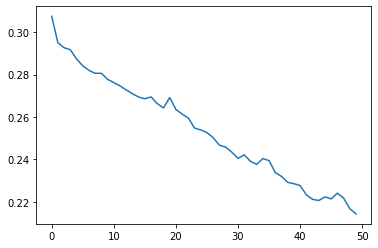

In [42]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes. 

For note pitch, it draws a sample from softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability.
Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The `temperature` parameter can be used to control the randomness of notes generated. You can find more details on temperature in [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

In [43]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [44]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [45]:
generated_notes.head(10)

pitch      step  duration     start       end
0     76  0.058278  0.085514  0.058278  0.143792
1     92  0.166633  0.966148  0.224911  1.191059
2     95  0.136742  1.066341  0.361653  1.427994
3     92  0.126643  1.069384  0.488296  1.557680
4     98  0.122968  1.066232  0.611264  1.677497
5     98  0.128121  1.078833  0.739385  1.818218
6     89  0.129388  1.078044  0.868773  1.946817
7     98  0.117285  1.048614  0.986058  2.034672
8     91  0.130287  1.081855  1.116344  2.198199
9     92  0.122702  1.057928  1.239046  2.296974

In [46]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

You can also download the audio file by adding the two lines below:

```
from google.colab import files
files.download(out_file)
```

Visualize the generated notes.

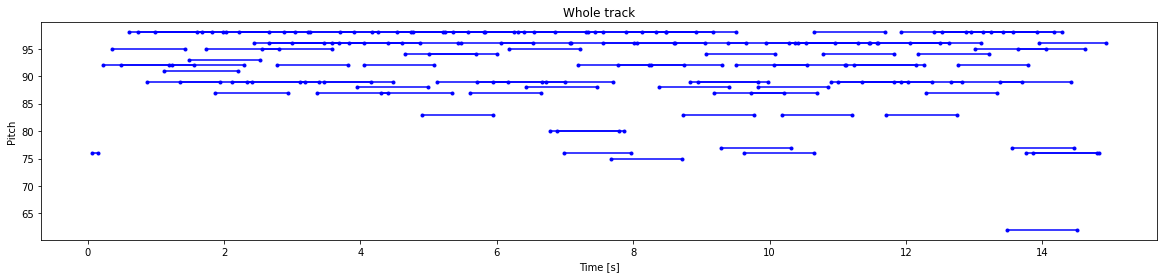

In [47]:
plot_piano_roll(generated_notes)

Check the distributions of `pitch`, `step` and `duration`.

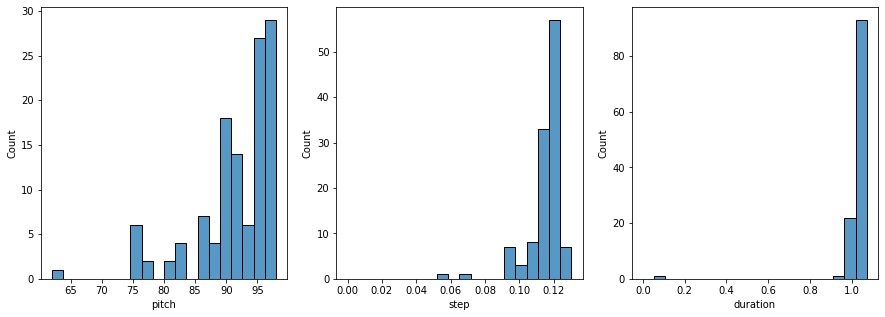

In [48]:
plot_distributions(generated_notes)

In the above plots, you will notice the change in distribution of the note variables.
Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss. 
This is particularly relevant for `step` and `duration`, which has uses MSE loss.
For `pitch`, you can increase the randomness by increasing the `temperature` in `predict_next_note`.



## Next steps

This tutorial demonstrated the mechanics of using an RNN to generate sequences of notes from a dataset of MIDI files. To learn more, you can visit the closely related [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial, which contains additional diagrams and explanations. 

An alternative to using RNNs for music generation is using GANs. Rather than generating audio, a GAN-based approach can generate a entire sequence in parallel. The Magenta team has done impressive work on this approach with [GANSynth](https://magenta.tensorflow.org/gansynth). You can also find many wonderful music and art projects and open-source code on [Magenta project website](https://magenta.tensorflow.org/).